# 0. Data Priming

## 0.1 Import Libraries

In [1]:
# Import Libraries

# Section 1 - Regression Methods
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA
import copy
from statsmodels.tsa.api import VAR

# Section 2 - Bond Pricing
from scipy.stats import pearsonr, iqr

# Section 4 - Robust Statistics and Non Linear Methods
from statsmodels.robust.scale import mad
from sklearn import linear_model

# Section 5 - Graphs in Finance
import seaborn as sns
import networkx as nx
from tslearn.metrics import dtw as ts_dtw

## 0.2 Global Variables

In [2]:
# Relative path to data folder
data_folder = 'Data/'

In [3]:
# Used CMAP for plotting
CMAP = 'jet'
CMAP_OBJ = plt.cm.jet

In [4]:
# Lines formatting.
fmt_lines = {
    'linewidth' : 2,
}

# Labels formatting.
fmt_label = {
    'fontsize' : 12,
    'fontweight': 'normal',
}

# Titles formatting.
fmt_title = {
    'fontsize' : 14,
    'fontweight': 'bold',
}

# Parameters formatting.
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

In [5]:
# Unicode mappings for special characters
sp_chars = {
        'i'        : ('\u2071',   '\u1d62'      ),
        'k'        : ('\u1d4f',   '\u2096'      ),
        'm'        : ('\u1d50',   '\u2098'      ),
        'o'        : ('\u1d52',   '\u2092'      ),
        's'        : ('\u02e2',   '\u209b'      ),
        't'        : ('\u1d57',   '\u209c'      ),
}

# Greek characters.
greek_chars =  {
    ':alpha' : '\u03B1',
    ':beta' : '\u03B2'
}

## 0.3 Helper Functions

In [7]:
def visualise_data(ax, var, var2 = None, label = '', color = CMAP_OBJ(0), alpha = 1):
    '''
    Function to plot one or two variable plots nicely in a specific axis.

    Arguments:
    - ax: Axis in which the plot must be included.
    - var: If var2 is None, this will be considered as the data series to be plot.
    - var2: If var2 is not None, var and var2 will be plotted together.
    - label: Label for the plot.
    - color: Color of the plot (default is 'blue').
    - alpha: Alpha value for transparency (default is 1).
    '''

    # Plot single variable if var2 is None
    if var2 is None:
        if color == CMAP_OBJ(0):
            if isinstance(var, np.ndarray) or isinstance(var, list) :
                ax.plot(var, **fmt_lines, label = label, color = color, alpha = alpha)
            else:
                var.plot(ax = ax,  **fmt_lines, label = label, cmap = CMAP)
        else:
            if isinstance(var, np.ndarray):
                ax.plot(var, **fmt_lines, label = label, color = color, alpha = alpha)
            else:
                var.plot(ax = ax,  **fmt_lines, label = label, color = color, alpha = alpha)
    else:
        # Else plot both variables.
        ax.plot(var, var2, **fmt_lines, label = label, color = color, alpha = alpha)

In [8]:
def format_plot(ax, xlabel = '', ylabel = '', title = '', color = 'k',
                   legend_on = True, legend_out = False, grid_on = True,
                   display_names = []):
    '''
    Function to add labels, title, legend, and other formatting features to plots.

    Arguments:
    - ax: Axis to format.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    - title: Title for the plot.
    - color: Color for the labels and title.
    - legend_on: Boolean indicating whether to display the legend.
    - legend_out: Boolean indicating whether to place the legend outside the plot.
    - grid_on: Boolean indicating whether to display grid lines.
    - display_names: List of names to display in the legend.
    '''

    # Set labels, title and ticks.
    ax.set_xlabel(xlabel, color = color, **fmt_label)
    ax.set_ylabel(ylabel, color = color, **fmt_label)
    ax.set_title(title, color = color, **fmt_title)
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

    # Set grid lines.
    ax.grid(grid_on)

    # Set legend
    if legend_on:
        if legend_out:
            if len(display_names) == 0:
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            else :
                ax.legend(display_names, bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            if len(display_names) == 0:
                ax.legend()
            else :
                ax.legend(display_names)
    elif ax.get_legend():
        # Remove legend if present.
        ax.get_legend().remove()

In [9]:
def configure_subplots(rows, cols, fig_size=(6, 6), hspace=0.6, wspace=0.6):
    '''
    Initialize subplot with tight layout and specified figure size and spacing.

    Arguments:
    - rows: Number of rows in the subplot.
    - cols: Number of columns in the subplot.
    - fig_size: Tuple specifying the figure size (default is (6, 6)).
    - hspace: Height spacing between subplots (default is 0.6).
    - wspace: Width spacing between subplots (default is 0.6).

    Returns:
    - fig: The created figure object.
    - axes: The array of axes subplot objects.
    '''
    fig, axes = plt.subplots(rows, cols, figsize=fig_size)

    fig.tight_layout()
    fig.subplots_adjust(hspace=hspace, wspace=wspace)

    return fig, axes

In [10]:
def clean_print(var, text=''):
    '''
    Print tuples, lists, and np.arrays in a tidy
    and easy to read fashion.

    Arguments:
    - var : the variable to print
    - text: the name of the variable to display
            next to it.

    var and text MUST have the same size.
    '''

    print('----------------------------------------------------------')

    if isinstance(var, (list, np.ndarray)) and len(var) > 1:
        # If a list or array, print it in the form:
        # [
        #   text[i]: var[i]
        # ]
        print(f'{text} : [')
        for el in var:
            print(f'    {el},')
        print(']')

    elif isinstance(var, tuple) and isinstance(text, tuple):
        # If var is a tuple, print it in the form:
        # text[i]: var[i]
        max_text_length = max(len(label) for label in text)
        for i, value in enumerate(var):
            label = text[i].ljust(max_text_length)
            print(f'{label} : {value}')

    else:
        # else just print it.
        print(f'{text.ljust(20)} : {var}')

    print('----------------------------------------------------------')


In [11]:
def compute_jb_stat(var, index):
    '''
    Function to compute the Jarque-Bera statistic of a series.

    Arguments:
    - var: DataFrame or Series containing the data series.
    - index: index of data in the series.
    '''
    # Convert var to pandas DataFrame or Series if it's a list
    if isinstance(var, list):
        var = pd.Series(var)

    x = [i for i in range(100, len(var.dropna()), 100)]
    jb = [stats.jarque_bera(var.dropna()[:i])[index] for i in x]
    return jb, x

In [12]:
def compute_opt_weights(C, returns):
    '''
    Function to find optimal weights from correlation matrix.

    Arguments:
    - C: correlation matrix.
    - returns: returns data.
    '''
    one_matrix = np.ones((returns.shape[1], 1))
    lagrange_multiplier = 1 / ((one_matrix.T @ np.linalg.inv(C).T) @ one_matrix)
    opt_weights = lagrange_multiplier * (np.linalg.inv(C) @ one_matrix)
    opt_weights = opt_weights.reshape(-1, )

    return opt_weights

In [13]:
def get_portfolio_stats(portfolio):
    '''
       Function to retrieve portfolio statistics.
    '''

    # Compute and return cumulative sum, mean and variance.
    cumsum = portfolio.cumsum()
    mean = portfolio.mean()
    var = portfolio.std() ** 2
    return [str(round(mean, 10)), str(round(cumsum[-1], 10)), str(round(var, 10))]

In [14]:
def hist_plot_w_gauss_fit(ax, data, bins = 100, color = CMAP_OBJ(0), label = ''):
    '''
    Plot histogram with a single Gaussian fit.

    Arguments:
    - ax: Axis in which the plot must be included.
    - data: Data to compute histogram.
    - bins: Number of bins in the histogram (default is 100).
    - color: Color of the histogram bars (default is CMAP_OBJ(0)).
    - label: Label for the histogram (default is '').

    Returns:
    - None
    '''

    # Compute histogram and fit a Gaussian curve
    if isinstance(data, (np.ndarray, list)):
        weights = np.ones_like(data) / len(data)
        (mu, std) = norm.fit(data)
        ax.hist(data, bins = bins, color = color, weights = weights, label = label)
    else:
        data = data.dropna()
        weights = np.ones_like(data) / len(data)
        (mu, std) = norm.fit(data)
        data.hist(ax = ax, bins = bins, color = color, weights = weights)

    # Plot the Gaussian curve (PDF)
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    p = p / sum(p) * (100 / bins)
    ax.plot(x, p, linewidth=2, color=CMAP_OBJ(0.9))

    # Set y-axis ticks to percentages
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

In [15]:
def plot_z_bounds(ax, data, roll_mean, upper_bound, lower_bound, color_data = CMAP_OBJ(0), color_mean = CMAP_OBJ(0.9),
               xlabel = '', ylabel = '', title = '', legend = None):
    '''
    Plot Z-bounds for price data.

    Arguments:
    - ax: The axis in which the plot must be included.
    - data: The price data.
    - roll_mean: The rolling mean series.
    - upper_bound: The upper bound for the Z-score.
    - lower_bound: The lower bound for the Z-score.
    - color_data: Color for plotting the data (default is 'tab:blue').
    - color_mean: Color for plotting the rolling mean (default is 'tab:orange').
    - xlabel: Label for the x-axis (default is '').
    - ylabel: Label for the y-axis (default is '').
    - title: Title for the plot (default is '').
    - legend: List of legend labels (default is None).
    '''

    # Plot data and rolling mean in dark blue and red.
    ax.plot(data, color = color_data)
    ax.plot(roll_mean, color = color_mean)

    # Plot bounds in faded dark blue.
    ax.plot(upper_bound, ':', color = color_data, alpha = 0.25)
    ax.plot(lower_bound, ':', color = color_data, alpha = 0.25)

    # Fill region between bounds in faded dark blue.
    ax.fill_between(roll_mean.index, upper_bound, lower_bound, color = color_data, alpha = 0.25)

    # Format axes.
    format_plot(ax, xlabel, ylabel, title, legend_out = True, display_names = legend)

In [16]:
def network_plotter(links, mean_corrs = None, cmap = plt.cm.Blues, node_color = 'skyblue',
                  with_labels = True, font_size = 14, width = 3, ax = None,
                  mean = 0.4, std = 0.15, factor = 3000):
    '''
    Plot a graph with formatted nodes and edges.

    Arguments:
    - edges: Pairs of connected elements to be included in the graph.
    - mean_corrs: Mean correlation for assets (optional).
    - cmap: Colormap for edges (default is plt.cm.Blues).
    - node_color: Color for nodes (default is 'skyblue').
    - with_labels: Whether to include labels (default is True).
    - font_size: Font size for labels (default is 14).
    - width: Width of edges (default is 3).
    - ax: Axis to plot the graph (default is None, uses current axis).
    - mean: Mean for node size calculation (default is 0.4).
    - std: Standard deviation for node size calculation (default is 0.15).
    - factor: Scaling factor for node size (default is 3000).
    '''

    if ax is None:
        ax = plt.gca()

    # Build the graph with networkx from the links.
    Graph = nx.from_pandas_edgelist(links, 'var1', 'var2')

    # Get weights for connections.
    weights = []
    for var1, var2 in Graph.edges:
        indexes_var1 = links.index[links['var1'] == var1].tolist()
        indexes_var2 = links.index[links['var2'] == var2].tolist()
        row = list(set(indexes_var1).intersection(indexes_var2))
        if len(row) == 0:
            weights.append(0)
        else:
            weights.append(links.loc[row[0]].value)
    weights = tuple(weights)


    if mean_corrs is None:
        # Default node size
        node_size = 2000
    else:
        # Compute dynamic weights for nodes.
        nodes = nx.nodes(Graph)
        node_size = np.array([])
        for n in nodes:
            node_size = np.append(node_size, mean_corrs.loc[n].values[0])

        # Standardise sizes to mean and std, then scale by factor.
        node_size = ((node_size - mean)/ std) * factor

    # Plot the network.
    nx.draw(Graph, with_labels = with_labels, edge_cmap = cmap,
            node_color = node_color, node_size = node_size, edgelist = Graph.edges,
            edge_color = weights, width = width, font_size = font_size, ax = ax)

# 1. Regression Methods

In this section, regression methods are used to analyse the performance of some of the S&P 500 companies.

## 1.1 Processing Stock Price Data in Python

### 1.1.1 Perform the natural logarithm of the price data and plot the time series

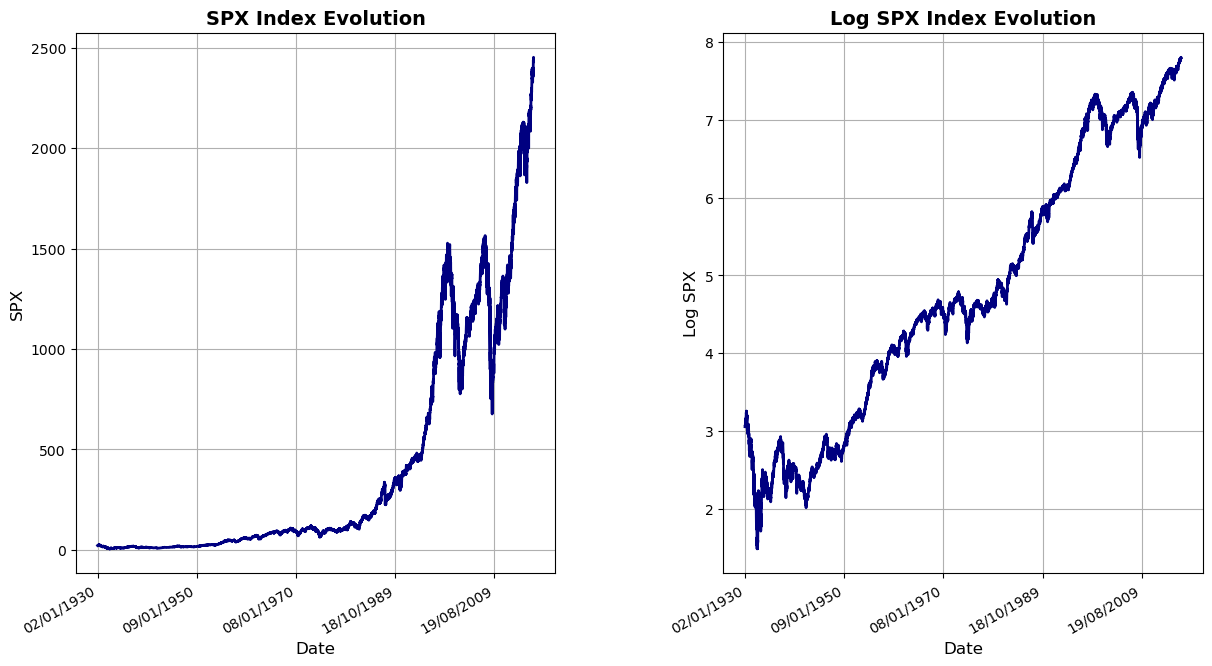

In [17]:
# Import and format price data.
px = pd.read_csv(data_folder + "priceData.csv", index_col = 0)
px = px.dropna()

# Take natural logarithm of price data
logpx = np.log(px)

# Initialise subplot.
fig, axes = configure_subplots(1, 2, fig_size = (12, 6), wspace = 0.35)

# Plot prices and log-prices.
visualise_data(axes[0], px)
visualise_data(axes[1], logpx)

# Format subplots.
format_plot(axes[0], 'Date', 'SPX', 'SPX Index Evolution', legend_on = False)
format_plot(axes[1], 'Date', 'Log SPX', 'Log SPX Index Evolution', legend_on = False)

### 1.1.2 Using a sliding window of 252 days, compute and store the evolution of the “sliding-window-based” first and second-order statistics (mean and variance) of the price and log-price time series, using 1-day increments, and plot these as a function of time on separate figures. Comment on the stationarity of price time-series with reference to your figures.


A stochastic signal is deemed wide-sense stationary if its first moment (the mean) remains constant over time, and its autocorrelation function depends solely on the time differences, that is

\begin{equation}
    m_x(t)=m_x(t+T)
\end{equation}

for any $T$ and

\begin{equation}
    R_{xx}(t_1,t_2)=R_{xx}(t_1-t_2),
\end{equation}

for any $t_1$, $t_2$.

Stationarity holds significant importance in the analysis of financial markets. A stationary signal indicates that the signal's mean remains constant over time, and the autocorrelation is solely dependent on time differences. Such characteristics justify investment strategies based on the mean-reverting behaviour of the signal, as they suggest that deviations from the mean are likely to be temporary and the signal is likely to revert to its mean value over time. The figure below depicts the mean and standard deviation of both the price and log-price, computed using a sliding window of 252 days with 1-day increments.

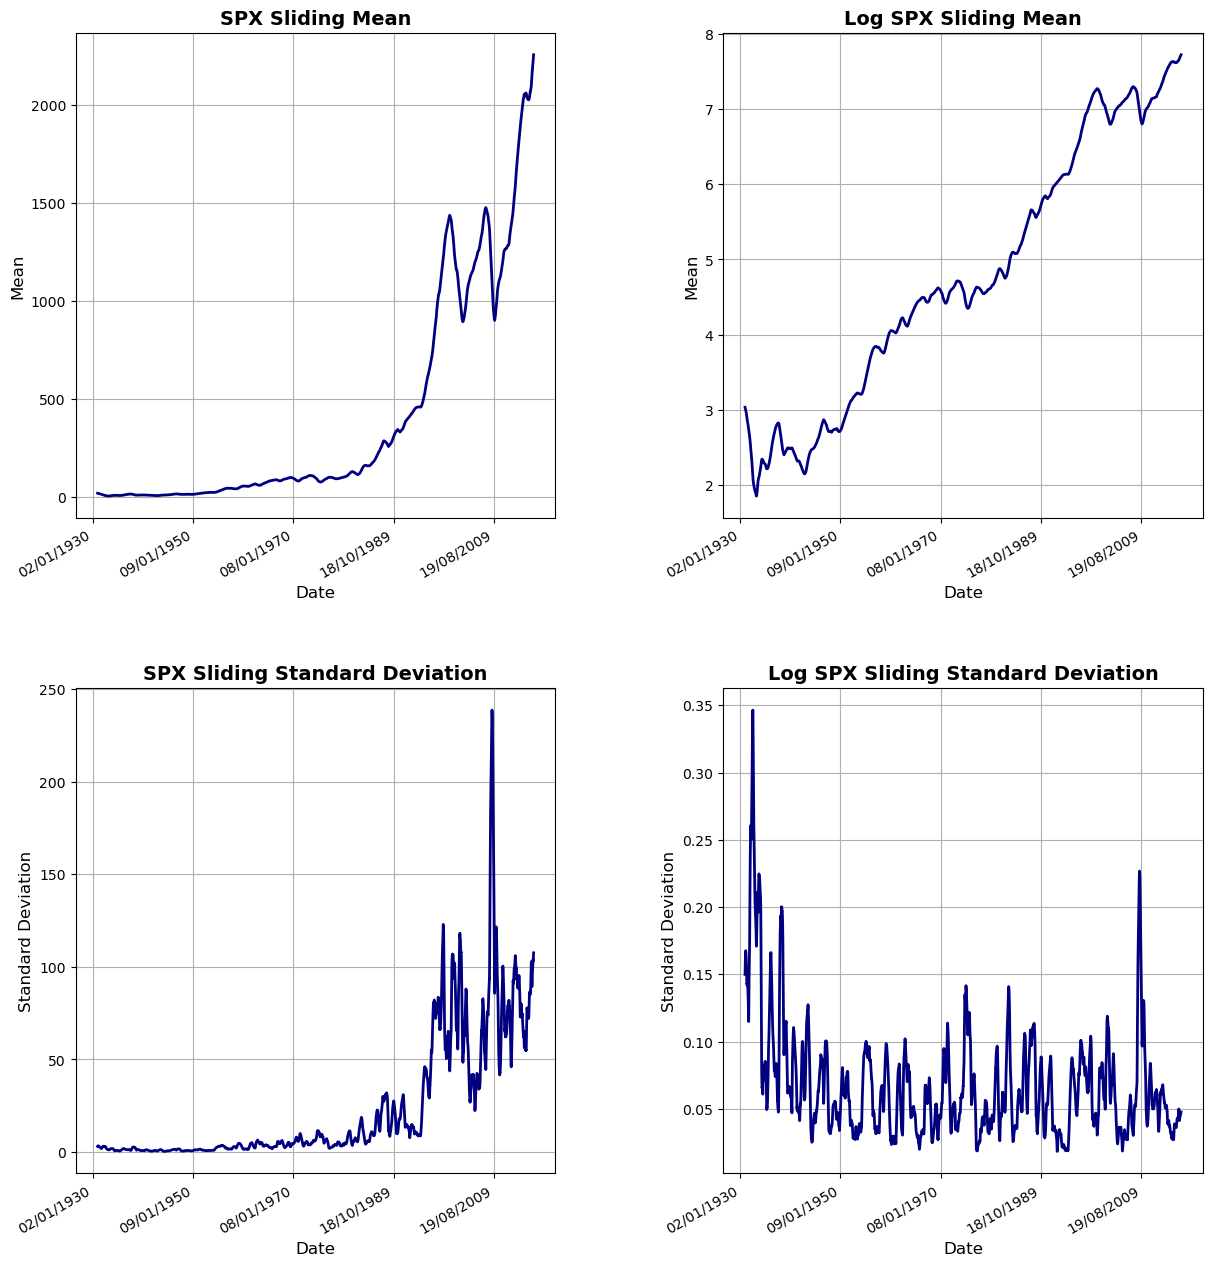

In [18]:
# Define a window size.
w = 252

# Initialise subplot.
fig, axes = configure_subplots(2, 2, fig_size = (12, 12), hspace = 0.35, wspace = 0.35)

# Plot sliding window analysis of the prices.
visualise_data(axes[0][0], px.rolling(w).mean())
visualise_data(axes[1][0], px.rolling(w).std())

# Format subplots.
format_plot(axes[0][0], 'Date', 'Mean', 'SPX Sliding Mean', legend_on = False)
format_plot(axes[1][0], 'Date', 'Standard Deviation', 'SPX Sliding Standard Deviation', legend_on = False)

# Plot sliding window analysis of log-prices.
visualise_data(axes[0][1], logpx.rolling(w).mean())
visualise_data(axes[1][1], logpx.rolling(w).std())

# Format subplots.
format_plot(axes[0][1], 'Date', 'Mean', 'Log SPX Sliding Mean', legend_on = False)
format_plot(axes[1][1], 'Date', 'Standard Deviation', 'Log SPX Sliding Standard Deviation', legend_on = False)

The sliding mean serves to smooth out fluctuations in the signal, while the standard deviation provides insights into price volatility. The plots in the figures above suggest non-stationarity, as the moving average exhibits an upward trend over time. Consequently, both the price and log-price time-series lack time-invariant statistics, indicating that they are non-stationary stochastic processes.

### 1.1.3 Compute the simple and log-return time-series from the price data. Then, produce "sliding" statistics of the obtained time-series and comment on the stationarity of these returns in comparison to the figures obtained in Question 1.1.2.

The simple return, denoted as $R_t$, is defined as:

\begin{equation}
    R_t = \frac{p_t}{p_{t-1}} -1
\end{equation}

where $p_t$ represents the price of a certain asset at time instant $t$ and $R_t$ is the simple return at the same time instant $t$.
Similarly, the logarithmic return, denoted as $r_t$, is defined as:

\begin{equation}
    r_t = \log(p_t) - \log(p_{t-1})
\end{equation}

where $p_t$ denotes the price of a certain asset at time instant $t$, and $r_t$ is the logarithmic return at the same time instant $t$. The figure below displays the sliding statistics analysis of both simple and log-return prices.

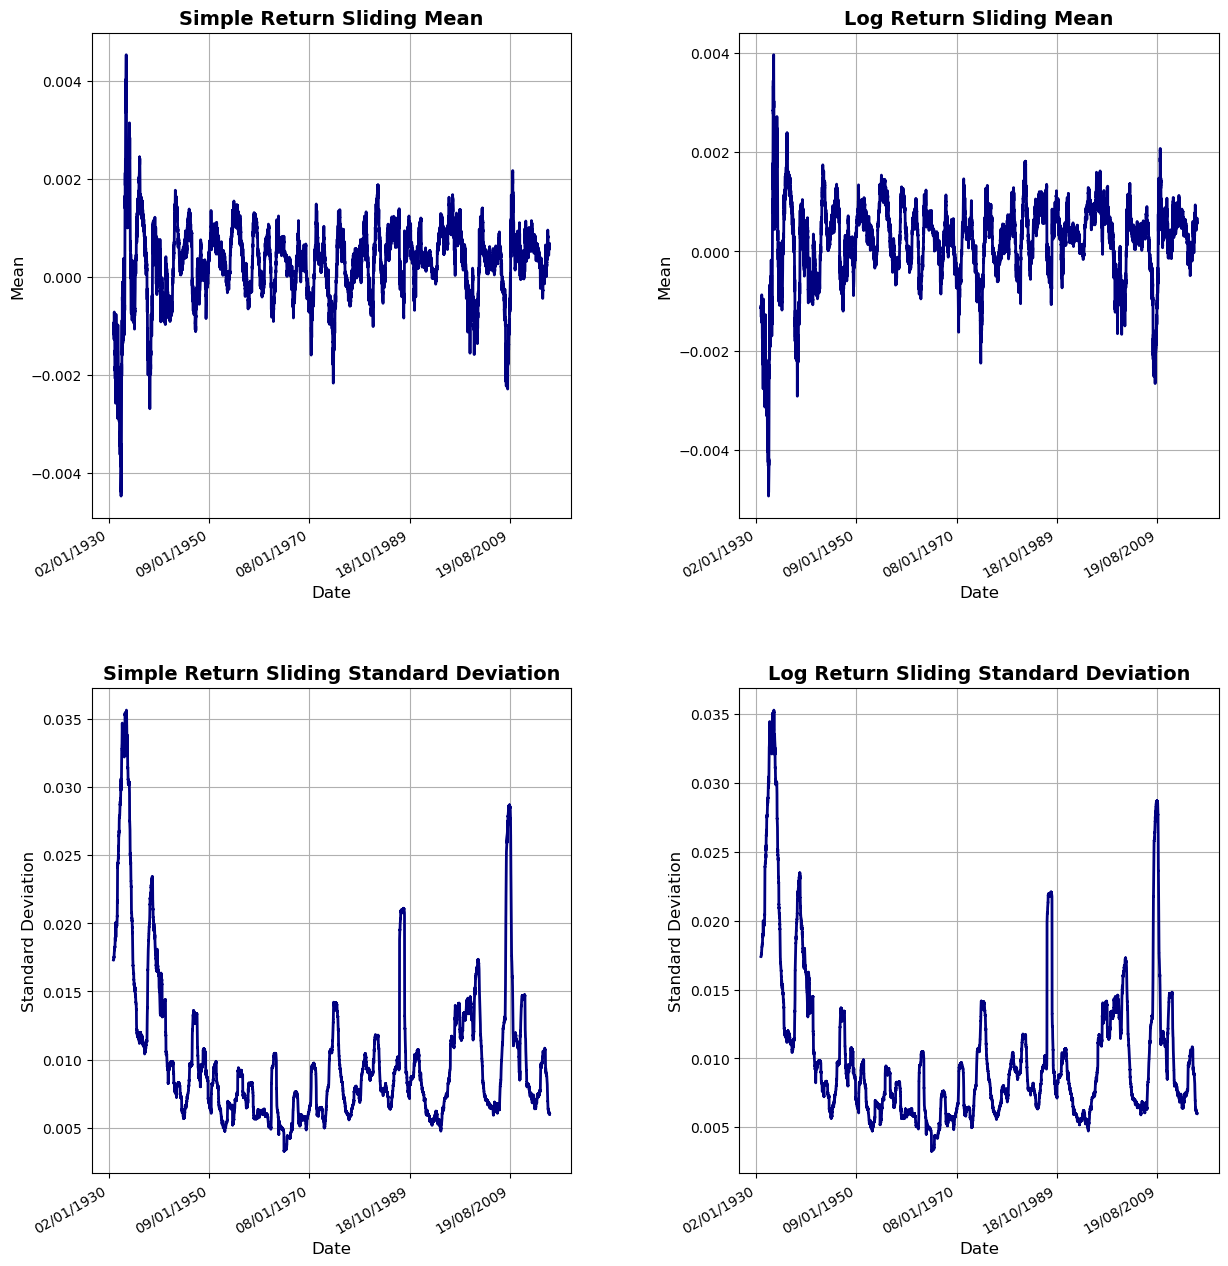

In [19]:
# Compute simple returns and log-returns.
simp_ret = px.pct_change()
log_ret = logpx.diff()

# Initialise subplot.
fig, axes = configure_subplots(2, 2, fig_size = (12, 12), hspace = 0.35, wspace = 0.35)

# Plot sliding window analysis of the simple returns.
visualise_data(axes[0][0], simp_ret.rolling(w).mean())
visualise_data(axes[1][0], simp_ret.rolling(w).std())

# Format subplots.
format_plot(axes[0][0], 'Date', 'Mean', 'Simple Return Sliding Mean', legend_on = False)
format_plot(axes[1][0], 'Date', 'Standard Deviation', 'Simple Return Sliding Standard Deviation', legend_on = False)

# Plot sliding window analysis of log-returns.
visualise_data(axes[0][1], log_ret.rolling(w).mean())
visualise_data(axes[1][1], log_ret.rolling(w).std())

# Format subplots.
format_plot(axes[0][1], 'Date', 'Mean', 'Log Return Sliding Mean', legend_on = False)
format_plot(axes[1][1], 'Date', 'Standard Deviation', 'Log Return Sliding Standard Deviation', legend_on = False)

From the figure above, we observe that both the simple and log-return means exhibit an oscillatory behaviour around zero. This behaviour suggests a greater degree of stationarity compared to the price statistics generated in Section 1.1.2.

### 1.1.4 Theoretically justify the suitability of log-returns over simple returns for signal processing purposes. Next, perform the “Jarque-Bera” test for Gaussianity on the data, and comment on the results in light of your theoretical answer

The application of logarithmic returns presents several advantages when compared to simple returns. Firstly, the logarithmic function ensures monotonicity, thereby preserving the relative order of values. Specifically, for any pair of values $a$ and $b$ where $a > b$, the logarithm of $a$ exceeds the logarithm of $b$. Moreover, empirical evidence suggests that prices often adhere to a log-normal distribution over relatively short time intervals. Consequently, the return at any given time $t$ ($r_t$) tends to ​follow a normal distribution. This Gaussian distribution property is of paramount importance, as numerous signal processing and statistical methodologies rely on this assumption. Furthermore, from a computational perspective, logarithms offer computational advantages, facilitating advanced calculus operations and providing enhanced numerical stability.

In light of these considerations, examining the Gaussian-like behaviour of returns through the visualisation of histograms comparing simple and log-return distributions proves insightful.

C:\Users\Prave\AppData\Local\Temp\ipykernel_63724\3921084399.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
C:\Users\Prave\AppData\Local\Temp\ipykernel_63724\3921084399.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


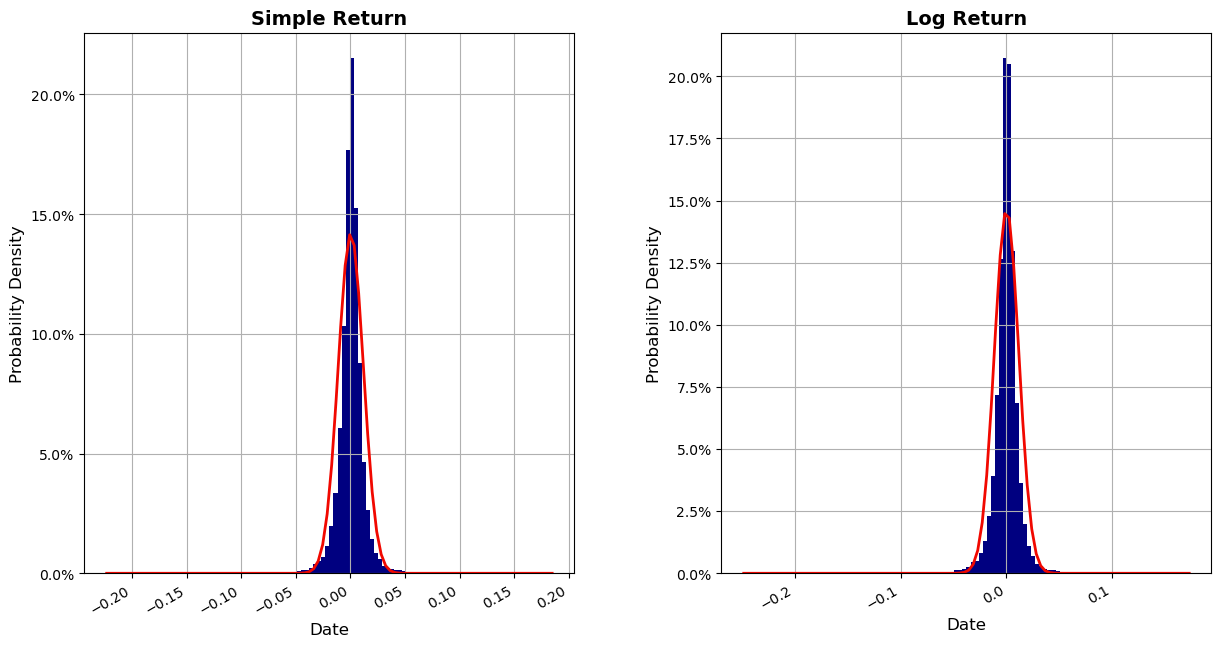

In [20]:
# Initialise subplot.
fig, axes = configure_subplots(1, 2, fig_size = (12, 6))

# Plot the PDF histogram of simple and log-returns.
hist_plot_w_gauss_fit(axes[0], simp_ret)
hist_plot_w_gauss_fit(axes[1], log_ret)

# Format subplots.
format_plot(axes[0], "Date", "Probability Density", 'Simple Return', legend_on = False)
format_plot(axes[1], "Date", "Probability Density", 'Log Return', legend_on = False)

In the realm of statistical analysis, the evaluation of data Gaussianity transcends mere visual assessment and necessitates the employment of rigorous quantitative methods. One such method is the Jarque-Bera goodness-of-fit test, a statistical measure designed to gauge the degree of alignment between the skewness and kurtosis of the sample data and those expected from a normal distribution. The skewness denotes asymmetry, while kurtosis signifies the shape of the distribution curve, with a normal distribution characterised by zero skewness and a kurtosis of three.

The figure below portrays the JB curve as a function of the number of data points considered, revealing a widening discrepancy between the log-returns curve and simple returns curve as the dataset size increases. Notably, the log-returns curve exhibits a more gradual departure from normality compared to simple returns, rendering them better suited for a myriad of statistical analyses.

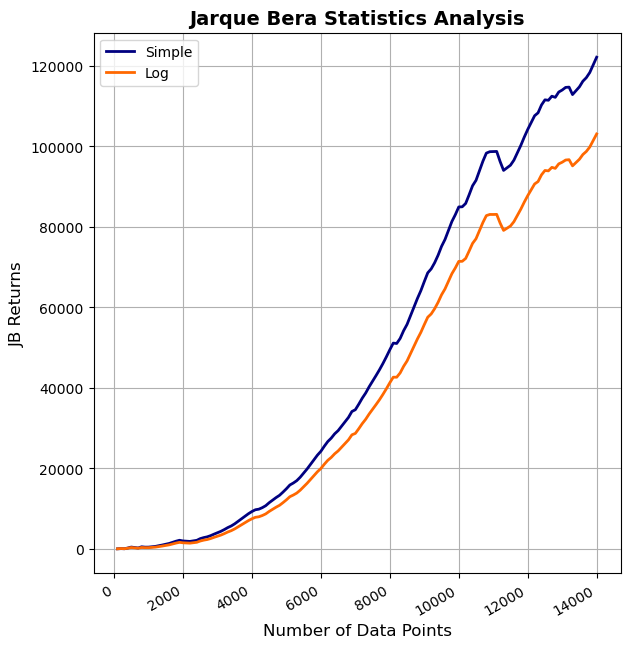

In [27]:
# Compute simple and logarithmic Jarque-Bera.
log_JB, _ = compute_jb_stat(log_ret, 0)
simple_JB, x = compute_jb_stat(simp_ret, 0)

# Initialise subplot.
fig, ax = configure_subplots(1, 1)

# Plot the JB statistic curve.
visualise_data(ax, x[:140], var2 = np.array(simple_JB[:140]), label = "Simple")
visualise_data(ax, x[:140], var2 = np.array(log_JB[:140]), label = "Log", color = CMAP_OBJ(0.8))

# Format axes.
format_plot(ax, 'Number of Data Points', 'JB Returns','Jarque Bera Statistics Analysis')

In [22]:
# Print simple and log return JB statistics and p-value.
clean_print(stats.jarque_bera(log_ret.dropna()), ('Log return JB', 'p-value'))
clean_print(stats.jarque_bera(simp_ret.dropna()), ('Simple return JB', 'p-value'))

----------------------------------------------------------
Log return JB : 309277.64126696065
p-value       : 0.0
----------------------------------------------------------
----------------------------------------------------------
Simple return JB : 257540.0649368358
p-value          : 0.0
----------------------------------------------------------


### 1.1.5 You purchase a stock for £1. The next day its value goes up to £2 and the following day back to £1. What are the simple and logarithmic returns over this period and what can you conclude about logarithmic returns on the basis of this example?

The simple returns over this period are $[1, -0.5]$, and the logarithmic returns over this period are $[0.69, -0.69]$. Overall, the value of the stock has not changed since it started at a value of £1 and ended the period with a value of £1. However, by looking at the simple returns, the sum of the returns isn't zero; whereas, the sum of the logarithmic returns is zero, giving us clearer intuition that the stock neither lost nor gained value. This characteristic serves as an illustrative example of why log-returns are superior to simple returns when depicting the changes in the value of an asset over time.

On the basis of this example, it can be seen that logarithmic returns, not only provide clearer intuition, but also give us greater mathematical tractability and numerical stability, since the addition of a small number is more stable when compared to multiplication with a small number.

In [23]:
# Print simple returns and log-returns for the example given.
example = pd.Series([1,2,1])
clean_print((example.pct_change()[1:].values, np.log(example).diff()[1:].values), ('Simple return', 'Log return'))

----------------------------------------------------------
Simple return : [ 1.  -0.5]
Log return    : [ 0.69314718 -0.69314718]
----------------------------------------------------------


### 1.1.6 Under what circumstances should you not use log-returns over simple returns?

It is worth noting that despite their advantages, log-returns possess certain properties that render them less suitable than simple returns in certain contexts. Firstly, log-normality diminishes over longer time spans, rendering it inconsequential for long-term analyses. Additionally, log-returns lack additivity across assets; whereas, simple returns exhibit this property. Consequently, simple returns are often considered a more appropriate choice in portfolio formulation.

## 1.2 ARMA vs. ARIMA Models for Financial Applications

The ARIMA (AutoRegressive Integrated Moving Average) model is a prevalent technique utilised for time-series forecasting. It represents an advancement over the ARMA (AutoRegressive Moving Average) model and is widely employed due to its sophistication. In the financial sector, particularly, the autoregressive (AR) component of the ARMA model endeavors to elucidate the dynamics of market momentum and mean reversion, phenomena often attributed to participation effects. Conversely, the moving-average (MA) component serves to capture the inherent "noise" stemming from exogenous shocks, such as news events, which remain unexplained by historical data alone.


### 1.2.1 Take the natural logarithm of the S&P 500 closing price data for the last 4 years and plot the time-series. Following the process in Question 1.1.2, comment on whether the ARMA or ARIMA model would be more appropriate.

The following figures show the natural logarithm of the daily closing price over the last 4 years, along with their corresponding sliding mean and standard deviation.

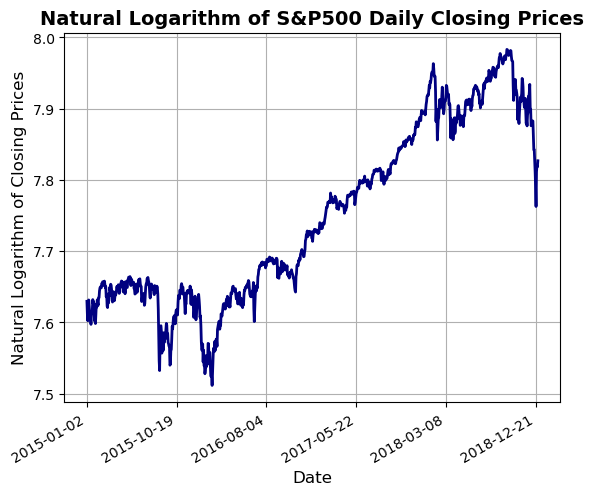

In [24]:
# Retrieve and process S&P 500 price data.
snp = pd.read_csv(data_folder + 'snp_500_2015_2019.csv')
snp.set_index(['Date'], inplace=True)
snp_close = snp['Close'].to_frame().apply(np.log)

# Plot natural logarithm of the S&P closing prices.
visualise_data(plt.gca(), snp_close)

# Format axes.
format_plot(plt.gca(), 'Date', 'Natural Logarithm of Closing Prices', 'Natural Logarithm of S&P500 Daily Closing Prices', legend_on = False)

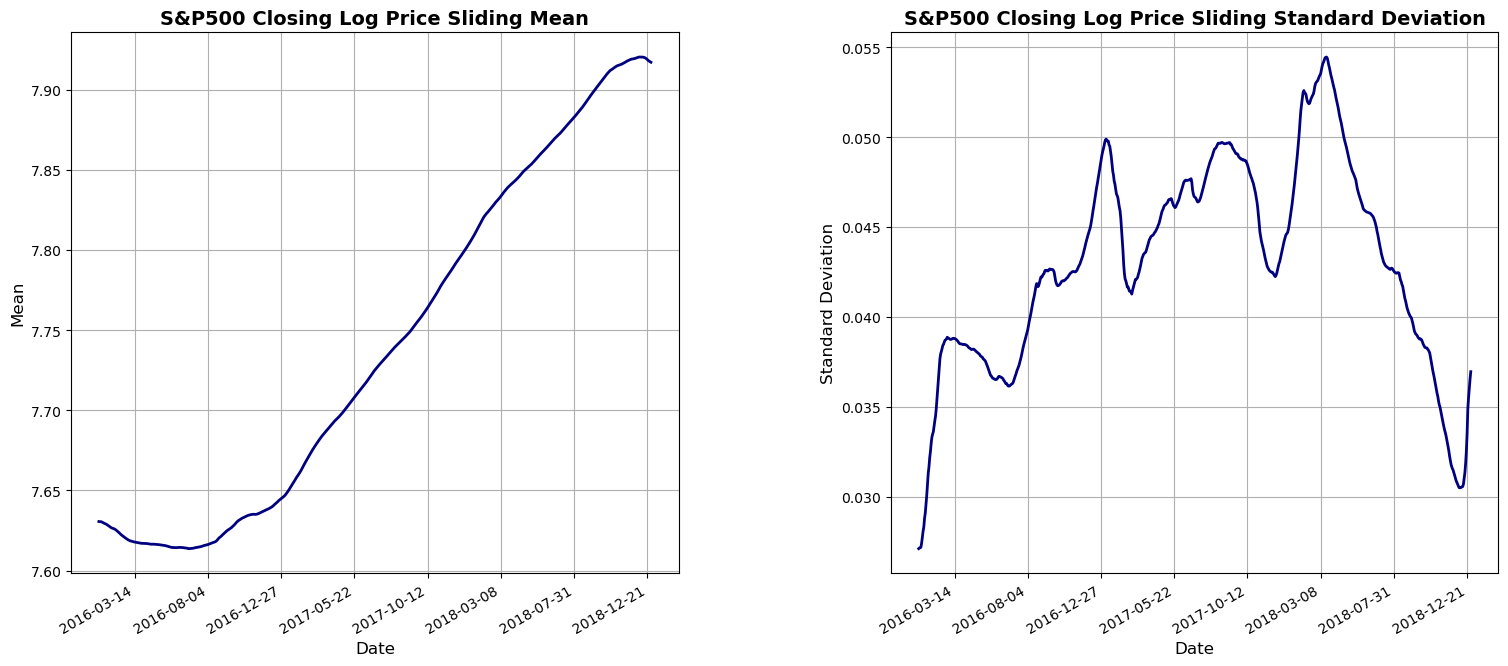

In [25]:
# Define window size.
w = 252

# Initialise subplot.
fig, axes = configure_subplots(1, 2, fig_size = (15, 6), wspace = 0.35)

# Plot sliding window statistics on natural logarithm of S&P500 closing prices.
visualise_data(axes[0], snp_close.rolling(w).mean())
visualise_data(axes[1], snp_close.rolling(w).std())

# Format axes.
format_plot(axes[0], 'Date', 'Mean', 'S&P500 Closing Log Price Sliding Mean', legend_on = False)
format_plot(axes[1], 'Date', 'Standard Deviation', 'S&P500 Closing Log Price Sliding Standard Deviation', legend_on = False)

As detailed in Section 1.1.2, the log-price curve exhibits characteristics indicative of non-stationarity upon visual examination. Notably, the mean of the curve exhibits a consistent upward trajectory over time, while the variance initially displays a positive trend followed by a sharp decline. The absence of time-invariant properties in both mean and variance statistics suggests the non-stationary nature of the underlying stochastic process. Consequently, the applicability of ARMA modelling for predictive purposes is limited, as ARMA models assume stationarity.

In contrast, an ARIMA model incorporates an additional integration step aimed at mitigating non-stationarity, rendering it a more suitable option for this particular scenario.

### 1.2.2 ARMA (1, 0) modelling

*Plot in the same figure both the prediction and the true signal. Inspect the model parameters. Comment on the results. Are these findings useful in practice?*

For this task, an ARIMA(1,0,0) model was used to fit the S&P500 data. This is a first order autoregressive model (AR(1) model) that can be mathematically represented as

\begin{equation}
    x[t]=\sum_{i=1}^{p}a_ix[t-i]+\eta[t]
\end{equation}

where $a_i$ denotes the autoregressive coefficients and $\eta$ denotes the noise.

The figure below shows both the predicted signal and the actual signal for the full time-series.

In [26]:
# Retrieve S&P500 data for ARMA model.
snp_arma = copy.deepcopy(snp_close)
snp_arma.columns = ['Actual']

# Find the residual fitting the model and deduce the prediction.
snp_arma['Residual'] = ARIMA(snp_arma['Actual'].values, order=(1, 0, 0)).fit().resid
snp_arma['Predicted'] = snp_arma['Actual'] - snp_arma['Residual']

c:\Users\Prave\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


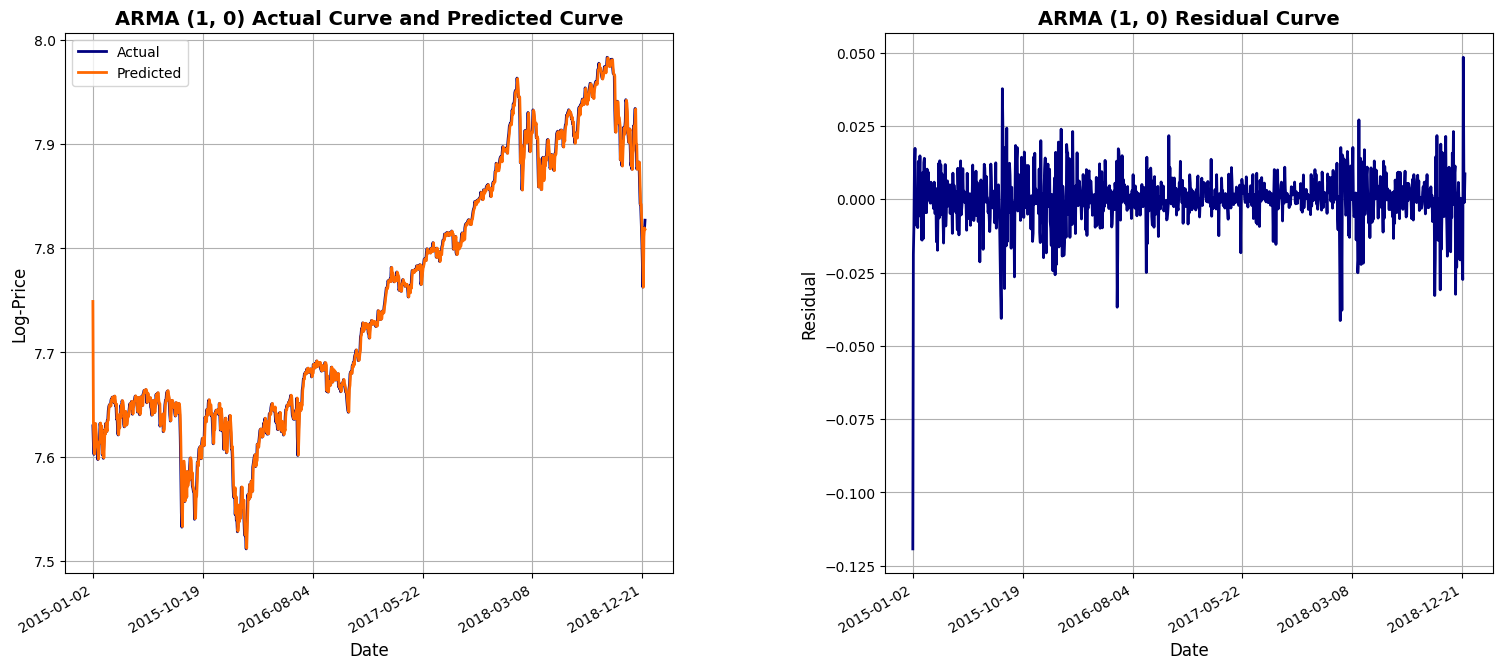

In [28]:
# Initialise subplot.
fig, axes = configure_subplots(1, 2, fig_size = (15, 6), wspace = 0.35)

# Plot actual and predicted log-prices for the whole time-series.
visualise_data(axes[0], snp_arma['Actual'], label = "Actual", color = CMAP_OBJ(0))
visualise_data(axes[0], snp_arma['Predicted'], label = "Predicted", color = CMAP_OBJ(0.8))

# Format first axis.
format_plot(axes[0], 'Date', 'Log-Price', 'ARMA (1, 0) Actual Curve and Predicted Curve')

# Plot the residual only.
visualise_data(axes[1], snp_arma['Residual'])

# Format the second axis.
format_plot(axes[1], 'Date', 'Residual', 'ARMA (1, 0) Residual Curve', legend_on = False)

In [29]:
# Print Mean Absolute Residual.
clean_print(np.mean(abs(snp_arma['Residual'])), 'Mean Absolute Residual')

----------------------------------------------------------
Mean Absolute Residual : 0.00598200561569962
----------------------------------------------------------


From the figures above, it isn't possible to differentiate between the actual log-price curve and predicted log-price curve so it is necessary to zoom in on a specific time range to visualise differences.

The figure below illustrates the comparison between the actual and predicted log-price curves, along with the corresponding residuals over a 100-day period with a mean absolute residual of 0.005982. The zoomed version of the prediction curve below provides a clearer view of the model's accuracy in predicting log-price values, albeit with a slight delay from the actual signal. It is also worth noting that although the mean absolute residual is approximately 0.006, the residuals often exhibit significantly smaller values for well-behaved parts of the signal. These observations are expected as the model doesn't have a moving average part that models the shocks of exogenous events which can cause higher volatility.

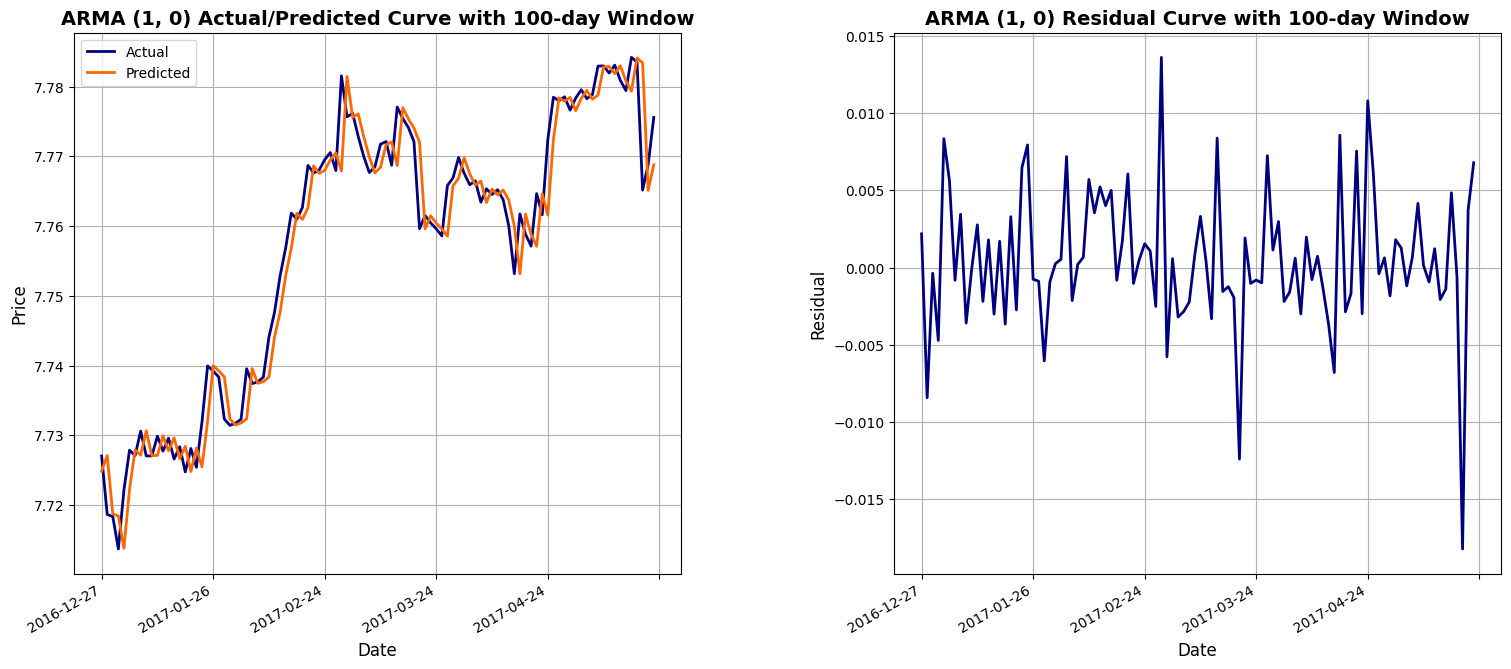

In [30]:
# Define window to zoom to depict lag clearly
days = range(500,600)

# Initialise subplot.
fig, axes = configure_subplots(1, 2, fig_size = (15, 6), wspace = 0.35)

# Plot actual vs predicted prices in the zoomed window.
visualise_data(axes[0], snp_arma['Actual'][days], label = "Actual", color = CMAP_OBJ(0))
visualise_data(axes[0], snp_arma['Predicted'][days], label = "Predicted", color = CMAP_OBJ(0.8))

# Format first axis.
format_plot(axes[0], 'Date', 'Price', 'ARMA (1, 0) Actual/Predicted Curve with 100-day Window')

# Plot the residuals only.
visualise_data(axes[1], snp_arma['Residual'][days])

# Format the second axis.
format_plot(axes[1], 'Date', 'Residual',
               'ARMA (1, 0) Residual Curve with 100-day Window', legend_on = False)

In [31]:
# Print the model parameters.
clean_print(ARIMA(snp_arma['Actual'].values, order=(1,0,0)).fit().arparams, 'Model Parameters')

----------------------------------------------------------
Model Parameters     : [0.99735438]
----------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The value of the AR(1) model parameter $a=0.99735$ aligns with expectations, given that the fitted autoregressive model closely resembles a first-order autoregressive process. In an AR(1) model where the autoregressive coefficient is equal to 1, the model essentially models a random walk. In other words, the value at time $t$ is solely determined by the value of the previous time step $t-1$. This relationship can be expressed mathematically as

\begin{equation}
    x[t]=0.99735x[t-1]+\eta[t]
\end{equation}

This equation elucidates the predictive model's representation of the predicted curve as a delayed version of the actual signal.

In practice, the AR(1) model may not be useful in practice for a number of reasons. Firstly, the model assumes the process behaves as a pure martingale by having an autoregression of order 1, which might not hold true in all cases. Additionally, the assumption of stationarity may not always be valid for many time-series datasets encountered in practice. Moreover, the model does not account for the effects of shocks, using a moving average component to capture the complexities of real-world phenomena.

Overall, these limitations suggest that the aforementioned AR(1) model may not be practically useful in many real-world scenarios, as it oversimplifies the underlying dynamics and fails to adequately represent the inherent complexities in the data.







### 1.2.3 Repeat Question 1.2.2, this time by fitting an ARIMA(1, 1, 0) model. Comment on the results. Compare your results with those in Question 1.2.2. Which analysis is more physically meaningful?

An ARIMA(1, 1, 0) model is similar in many ways to the ARIMA(1, 0, 0) model in Section 1.2.2, but a key difference is that the model initially applies an extra differentiation step of order 1 on the data to remove sources of non-stationarity. By repeating the steps undertaken in Section 1.2.2, the following figures are obtained.


In [32]:
# Define actual, predicted and residual for ARIMA(1, 1, 0) model.
actual = snp_arma['Actual']
residual = ARIMA(snp_arma['Actual'].values, order=(1, 1, 0)).fit().resid
predicted = snp_arma['Actual'] - residual

# Cast to pd.Series.
residual = pd.Series(data = residual, index = actual.index)
predicted = pd.Series(data = predicted, index = actual.index)

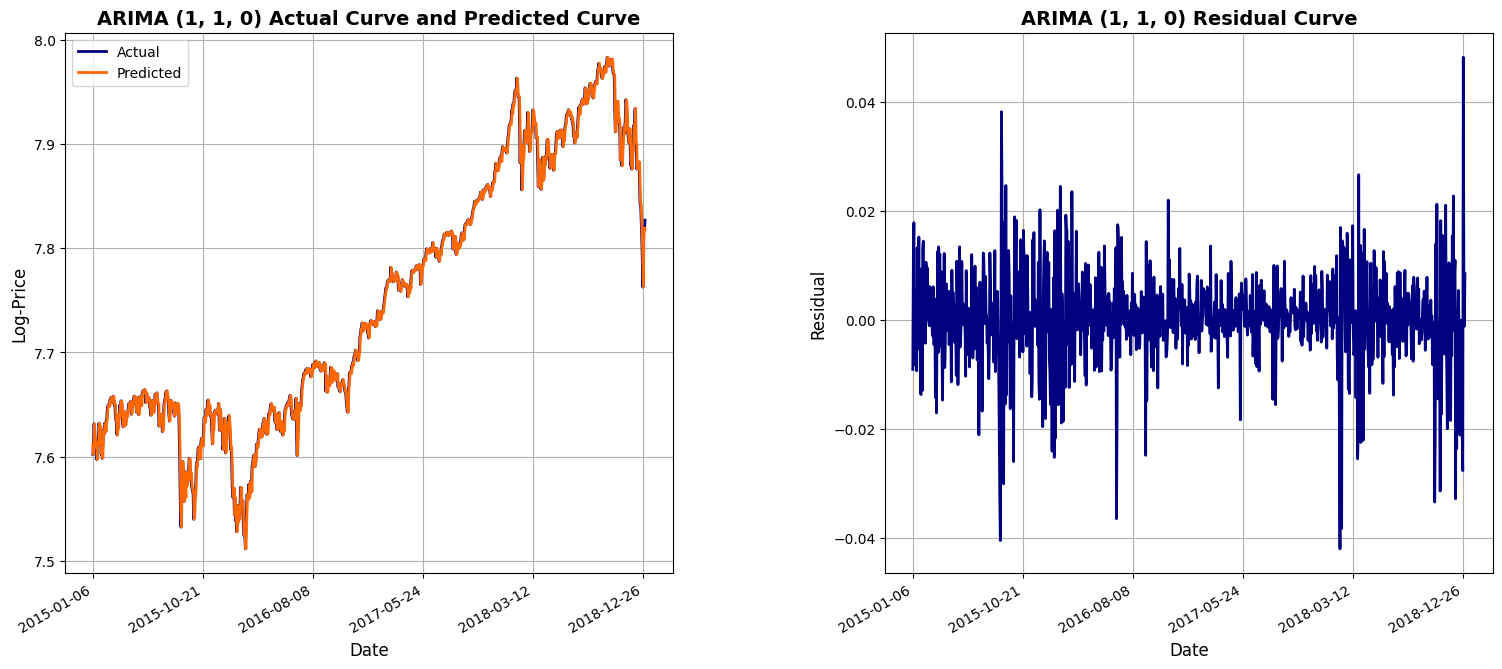

In [33]:
# Initialise subplot.
fig, axes = configure_subplots(1, 2, fig_size = (15, 6), wspace = 0.35)

# Plot actual and predicted log-prices for the whole time-series.
visualise_data(axes[0], actual[2:], label = "Actual", color = CMAP_OBJ(0))
visualise_data(axes[0], predicted[2:], label = "Predicted", color = CMAP_OBJ(0.8))

# Format first axis.
format_plot(axes[0], 'Date', 'Log-Price', 'ARIMA (1, 1, 0) Actual Curve and Predicted Curve')

# Plot the residual only.
visualise_data(axes[1], residual[2:])

# Format the second axis.
format_plot(axes[1], 'Date', 'Residual', 'ARIMA (1, 1, 0) Residual Curve', legend_on = False)

In [34]:
# Print Mean Absolute Residual.
clean_print(np.mean(abs(residual[2:])), 'Mean Absolute Residual')

----------------------------------------------------------
Mean Absolute Residual : 0.005842281454352869
----------------------------------------------------------


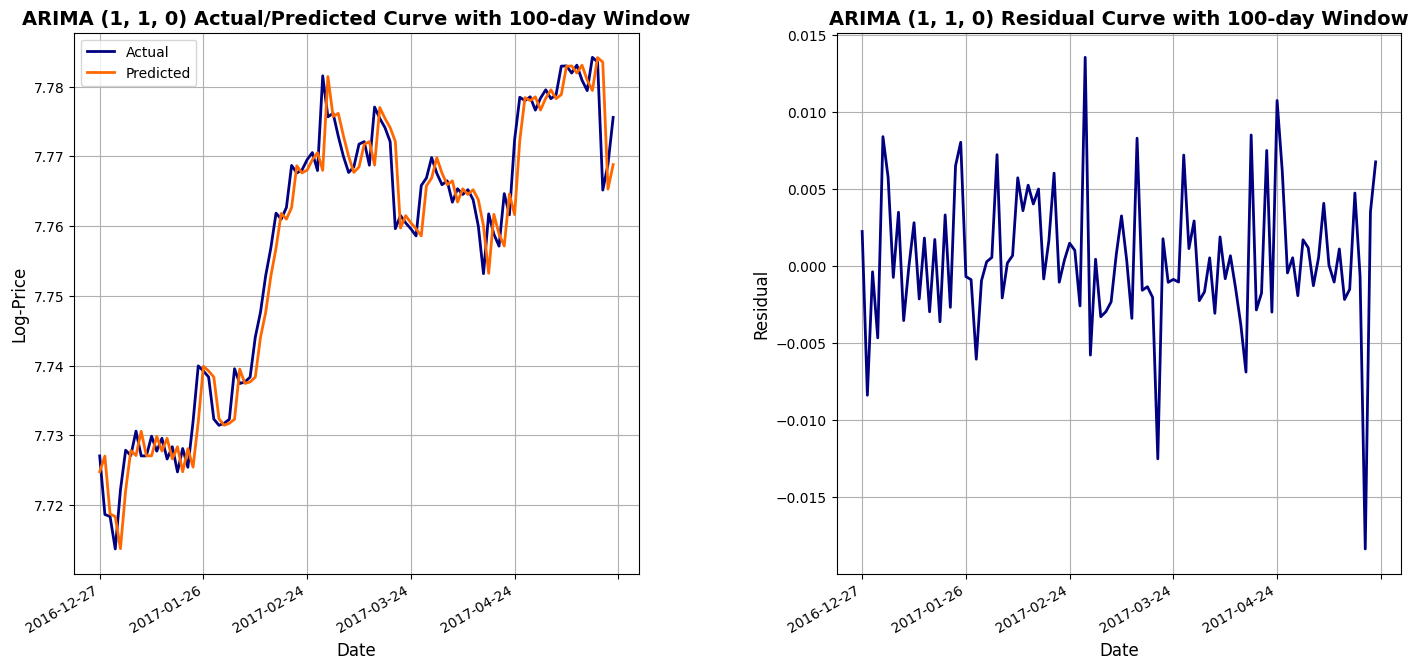

In [36]:
# Define window to zoom to depict lag clearly
days = range(500,600)

# Initialise subplot.
fig, axes = configure_subplots(1, 2, fig_size = (14, 6), wspace = 0.35)

# Plot actual vs predicted prices in the zoomed window.
visualise_data(axes[0], actual[days], label = "Actual", color = CMAP_OBJ(0))
visualise_data(axes[0], predicted[days], label = "Predicted", color = CMAP_OBJ(0.8))

# Format first axis.
format_plot(axes[0], 'Date', 'Log-Price', 'ARIMA (1, 1, 0) Actual/Predicted Curve with 100-day Window')

# Plot the residuals only.
visualise_data(axes[1], residual[days])

# Format the second axis.
format_plot(axes[1], 'Date', 'Residual',
               'ARIMA (1, 1, 0) Residual Curve with 100-day Window', legend_on = False)

In [37]:
# Print the model parameters.
clean_print(ARIMA(actual[2:].values, order=(1,1,0)).fit().arparams, 'Model Parameters')

----------------------------------------------------------
Model Parameters     : [-0.0090448]
----------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The negligible autoregressive coefficient $a=-0.00904$ is consistent with the expectation that the value at time instant $t$ has no discernible correlations with the previous time instant $t-1$, thanks to the differentiation step. While both models exhibit comparable Mean Absolute Residual (MAR) values, the superiority of the ARIMA(1,1,0) model over the AR(1) model stems from its adeptness at handling non-stationary log-price data. Moreover, the ARIMA(1,1,0) model's optimisation process is tailored to maximise an objective function representing log-returns by differencing the log-prices, thereby imbuing the model with a tangible interpretation — predicting maximum profit. Consequently, the ARIMA(1,1,0) model offers a more conceptually meaningful framework for analysing this dataset.

### 1.2.4 Comment on the necessity of taking the log of the prices for the ARIMA analysis.

There are five major benefits that are reaped by taking the natural logarithm of the prices for ARIMA analysis.

Firstly, as noted in Section 1.2.3, the interpretability of results can be enhanced. By taking the natural logarithm of prices, the model is able to optimise and objective function that accurately describes logarithmic returns. If the modelling were conducted on non-logarithmic price changes, the process would lack a clear physical interpretation - it can't be interpreted as simple returns. Therefore, employing the natural logarithm facilitates physically realisable interpretations to be made.

Another benefit of taking the natural logarithm of the prices is variance stabilisation. Prices in financial time series data often exhibit heteroscedasticity, meaning that the variance of the series changes over time. Taking the log of prices can help stabilise the variance, making the data more homoscedastic and suitable for analysis with ARIMA models, which assume constant variance.

One other benefit of taking the natural logarithm is linearisation of trends. In many cases, the growth rate of prices is more stable and linear than the absolute price levels themselves. Taking the log of prices effectively linearises any exponential growth or decay in the data, making it easier to model and interpret trends over time.

Moreover, taking the natural logarithm of prices can also help normalise the data, especially if the price levels span a wide range. Normalising the data can improve the performance of ARIMA models by ensuring that all values are on a comparable scale.

The final benefit of taking the natural logarithm of prices is residual interpretation. When using ARIMA models, it is important to examine the residuals to ensure that the model adequately captures the patterns in the data. Taking the log of prices can result in more normally distributed residuals, making it easier to interpret and assess the model's performance.








## 1.3 Vector Autoregressive (VAR) Models

Vector Autoregressive Models are multivariate extensions of AR models. A VAR(p) process is modelled by the following equation:

\begin{equation}
   \textbf y_t = \textbf{c} + \sum_{i = 1}^{p} \textbf A_i \textbf y_{t-i} + \textbf e_t  
\end{equation}

where $p$ is the model order, $\textbf y_i \in \mathbb{R}^{k\times1} \; \forall i \in [t-p, t-1]$ , $\textbf c \in \mathbb{R}^{k\times1}$ , $\textbf A_i \in \mathbb{R}^{k \times k} \; \forall i \in [1, p]$, and $\textbf e_t \in \mathbb{R}^{k\times1} \; \forall t$.

The above equation can be expanded in matrix form as:
\begin{equation}
    \begin{bmatrix}
    y_{1, t}\\
    y_{2, t} \\
    \vdots \\
    y_{k, t}
    \end{bmatrix} =
    \begin{bmatrix}
    c_{1}\\
    c_{2} \\
    \vdots \\
    c_{k}
    \end{bmatrix} +
    \sum_{i=1}^p
    \begin{bmatrix}
    a_{1, 1}^i & a_{1, 2}^i & \dots & a_{1, k}^i  \\
    a_{2, 1}^i & a_{2, 2}^i & \dots & a_{2, k}^i  \\
    \vdots & \vdots & \ddots & \vdots \\
    a_{k, 1}^i & a_{2k, 2}^i & \dots & a_{k, k}^i  \\
    \end{bmatrix}
    \begin{bmatrix}
    y_{1, t-i}\\
    y_{2, t-i} \\
    \vdots \\
    y_{k, t-i}
    \end{bmatrix} +
    \begin{bmatrix}
    e_{1, t}\\
    e_{2, t} \\
    \vdots \\
    e_{k, t}
    \end{bmatrix}\ ,
\end{equation}

### 1.3.1 Show that the above equation can be represented in a concise matrix form as

\begin{equation}
    \textbf{Y} = \textbf{BZ} + \textbf{U}
\end{equation}

where $\textbf Y \in \mathbb{R}^{K \times T}$ , $\textbf B \in \mathbb{R}^{K \times (KP+1)}$ , $\textbf Z \in \mathbb{R}^{(KP+1) \times T}$ and $\textbf U \in \mathbb{R}^{K \times T}$

By taking a matrix-oriented perspective, the above model can be succinctly rewritten by defining the following matrices:

\begin{equation}
    \textbf B = \begin{bmatrix}
    \textbf c & \textbf A_1 & \dots & \textbf A_p
    \end{bmatrix}
\end{equation}

\begin{equation}
    \textbf Z = \begin{bmatrix}
    1 \\
    \textbf y_{t-1} \\
    \vdots \\
    \textbf y_{t-p}
    \end{bmatrix}
\end{equation}

\begin{equation}
    \textbf Y = \textbf y_t
\end{equation}

\begin{equation}
    \textbf U = \textbf e_t
\end{equation}

The resulting equation for the VAR model is:

\begin{equation}
    \textbf{Y} = \textbf{BZ} + \textbf{U}
\end{equation}

However, the equation can be further generalised to accommodate the multi-period case, where multiple time steps of $T$ are modelled, instead of just $T=1$. This involves adding additional columns for each additional time step to $\textbf{Y}$, $\textbf{Z}$ and $\textbf{U}$. Consequently, the equation holds for matrices with dimensions $\textbf Y \in \mathbb{R}^{K \times T}$ , $\textbf B \in \mathbb{R}^{K \times (KP+1)}$ , $\textbf Z \in \mathbb{R}^{(KP+1) \times T}$ and $\textbf U \in \mathbb{R}^{K \times T}$. The generalised matrices have the following form:

\begin{equation}
    \textbf Y = \begin{bmatrix}
    \textbf y_{t} & \textbf y_{t+1} & \dots & \textbf y_{t+T}
    \end{bmatrix}
\end{equation}

\begin{equation}
    \mathbf{Z} = \begin{bmatrix}
    1 & 1 & \dots & 1 \\
    \mathbf{y}_{t-1} & \mathbf{y}_{t} & \dots & \mathbf{y}_{t-1+T} \\
    \mathbf{y}_{t-2} & \mathbf{y}_{t-1} & \dots & \mathbf{y}_{t-2+T} \\
    \vdots & \vdots & \ddots & \vdots \\
    \mathbf{y}_{t-p} & \mathbf{y}_{t-p+1} & \dots & \mathbf{y}_{t-p+T}
    \end{bmatrix}
\end{equation}


\begin{equation}
    \textbf U = \begin{bmatrix}
    \textbf e_{t} & \textbf e_{t+1} & \dots & \textbf e_{t+T}
    \end{bmatrix}
\end{equation}

### 1.3.2 Hence, show that the optimal set of coefficients $\textbf{B}$, denoted by $\textbf{B}_{opt}$ is obtained via

\begin{equation}
    \mathbf{B}_{opt} = \mathbf{Y}\mathbf{Z}^T (\mathbf{Z}\mathbf{Z}^T)^{-1}
\end{equation}

To solve the linear equation  $\mathbf{Y} = \mathbf{BZ} + \mathbf{U}$, the least-squares method is employed to minimise the squared elements of $\mathbf{U}$, which represent the error in the model. This problem can be formulated as an optimisation problem with the objective function

\begin{equation}
    J(\mathbf{B}) = (\mathbf{BZ} - \mathbf{Y})(\mathbf{BZ} - \mathbf{Y})^T
\end{equation}

Expanding this expression, we get

\begin{equation}
    J(\mathbf{B}) = \mathbf{BZZ}^T\mathbf{B}^T - 2\mathbf{YZ}^T\mathbf{B}^T + \mathbf{YY}^T
\end{equation}

Setting the derivative of  $J(\mathbf{B})$ with respect to $\mathbf{B}$ to zero yields

\begin{equation}
    \frac{{\delta J(\mathbf{B})}}{{\delta \mathbf{B}}} = 2\mathbf{BZZ}^T - 2\mathbf{YZ}^T = 0
\end{equation}

which simplifies to

\begin{equation}
    \mathbf{BZZ}^T = \mathbf{YZ}^T
\end{equation}

Finally, the optimal solution for $\mathbf{B}$ can be expressed as

\begin{equation}
    \mathbf{B}_{\text{opt}} = \mathbf{YZ}^T(\mathbf{ZZ}^T)^{-1}
\end{equation}


### 1.3.3 VAR Eigenvalues

Consider a VAR(1) process defined by the equation:

\begin{equation}
\mathbf{y}_t = \mathbf{A}\mathbf{y}_{t-1} + \mathbf{e}_t
\end{equation}

where $\mathbf{y}_t$ represents the variable at time $t$, $\mathbf{A}$ is a coefficient matrix, and $\mathbf{e}_t$ is a random error term.

Iterating backwards, we have

\begin{equation}
\mathbf{y}_{t-1} = \mathbf{A}\mathbf{y}_{t-2} + \mathbf{e}_{t-1}
\end{equation}

\begin{equation}
\mathbf{y}_{t-2} = \mathbf{A}\mathbf{y}_{t-3} + \mathbf{e}_{t-2}
\end{equation}

and so on.

Through substitution, we obtain

\begin{equation}
\mathbf{y}_t = \mathbf{A} (\mathbf{A}\mathbf{y}_{t-2} + \mathbf{e}_{t-1}) + \mathbf{e}_t
\end{equation}

This can be further expanded to

\begin{equation}
\mathbf{y}_t = \mathbf{A}^2 \mathbf{y}_{t-2} + \mathbf{A}\mathbf{e}_{t-1} + \mathbf{e}_t
\end{equation}

and so forth, until we reach

\begin{equation}
\mathbf{y}_t = \mathbf{A}^p \mathbf{y}_{t-p} + \sum_{i=0}^{p-1} \mathbf{A}^i \mathbf{e}_{t-i}
\end{equation}

The stability of the VAR model is contingent upon the eigenvalues of matrix $\mathbf{A}$ since the property $\mathbf{A}^p\mathbf{v}=\lambda^p\mathbf{v}$ holds. Specifically, for the model to be stable, the absolute values of all eigenvalues of $\mathbf{A}$ must be less than 1. This condition ensures that as $p$ approaches infinity, the term $\lim_{p \to \infty} \mathbf{A}^p = 0$, preventing the power of $\mathbf{A}$ from exploding in value.


### 1.3.4  Moving Average VAR Portfolio Analysis

Firstly, the required dataframes are loaded and formatted.

In [38]:
# Retrieve dataframes.
df = pd.read_csv(data_folder + 'snp_allstocks_2015_2019.csv')
df = df.set_index('Date')
info = pd.read_csv(data_folder + 'snp_info.csv', index_col = 0)

Then, a new dataframe denoting a subset of stocks is created from an existing dataframe. The figure below plots the stock prices time-series data.

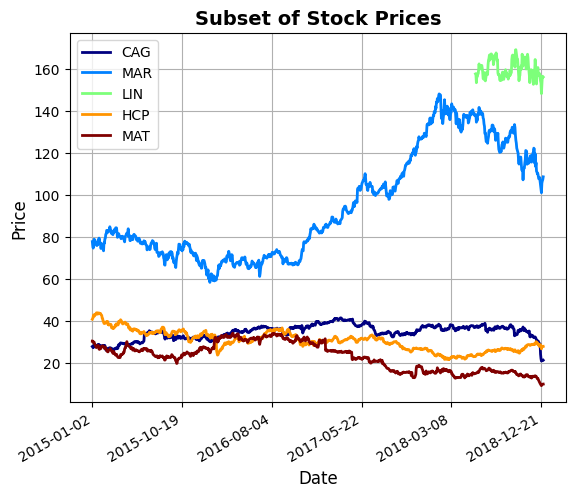

In [39]:
# Define new dataframe denoting a subset of stocks.
tickers = ['CAG', 'MAR', 'LIN', 'HCP', 'MAT']
stocks = df[tickers]

# Plot stock prices time-series.
visualise_data(plt.gca(), stocks)

# Format axes.
format_plot(plt.gca(), 'Date', 'Price', 'Subset of Stock Prices')

Afterwards, the new dataframe is detrended using an MA(66) model and the detrended stock prices are plotted.

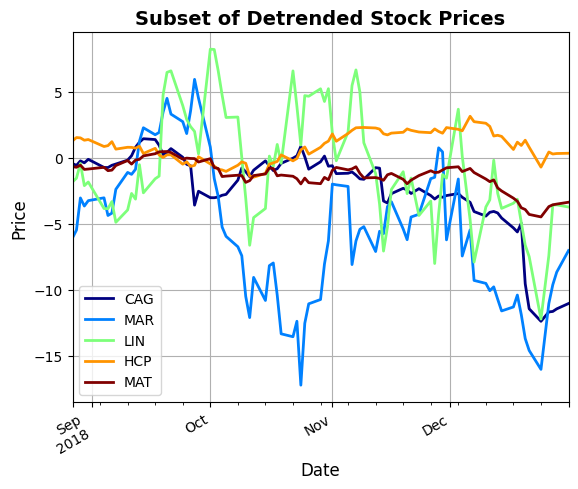

In [40]:
# Compute moving average.
stocks_ma = stocks.rolling(window = 66).mean()

# Detrend moving average.
detrended = stocks.sub(stocks_ma).dropna()
detrended.index = pd.DatetimeIndex(detrended.index).to_period('D')

# Plot detrended stock prices.
visualise_data(plt.gca(), detrended)

# Format axes.
format_plot(plt.gca(), 'Date', 'Price', 'Subset of Detrended Stock Prices')

By fitting a VAR(1) model to these stock prices and viewing the parameters, we observe a positive autocorrelation (as evidenced by the high positive values along the diagonal), which implies that the time-series tends to be positively autocorrelated with its lagged value, but minimally correlated across different assets (as non-diagonal elements are close to zero).

In [41]:
# Fit a VAR(1) model to these detrended stock prices
model = VAR(detrended)
results = model.fit(1)

# Display the parameters.
params = results.params[1:]
display(params)

CAG       MAR       LIN       HCP       MAT
L1.CAG  0.872786  0.113179 -0.281265  0.011912  0.058776
L1.MAR -0.063745  0.895820 -0.184820 -0.005004  0.022917
L1.LIN  0.000134 -0.111678  0.704023  0.004982 -0.025557
L1.HCP -0.084776 -0.083831 -0.401417  0.931708 -0.046406
L1.MAT  0.643072  0.094931  2.033036 -0.012884  0.802974

The eigenvalues of the regression matrix A are shown below.

In [42]:
# Compute and print the absolute values of the eigenvalues of the regression matrix A.
A = params.values
eigA, _ = np.linalg.eig(A)
clean_print(abs(eigA), 'EigA')

----------------------------------------------------------
EigA : [
    0.7260939285436442,
    0.7260939285436442,
    1.0063596404610209,
    0.860518942971363,
    0.9114451152082131,
]
----------------------------------------------------------


It's crucial to note the presence of an eigenvalue with an absolute value greater than 1. As discussed in Section 1.3.3, this is a symptom of instability in the VAR(1) model. For this reason, it would not make sense to construct a portfolio using these stocks.

### 1.3.5 Sector-based VAR Portfolio Analysis

As mentioned in the Section 1.3.3 and 1.3.4, via the same eigenanalysis, the maximum eigenvalue of each sector provides information on the stability of the VAR model used for price prediction. The table below presents the maximum and minimum eigenvalues per sector.

In [44]:
# Define tables of eigenvalues and returns.
eig_df = pd.DataFrame(columns = info['GICS Sector'].unique(),
                      index = ['min eigenvalue', 'max eigenvalue'])


In [45]:
for sector in info['GICS Sector'].unique():

    # Define portfolio of tickers from the same sector.
    tickers = info.loc[info['GICS Sector'] == sector]['Symbol'].tolist()
    stocks = df[tickers]

    # Compute moving average and detrend prices.
    stocks_ma = stocks.rolling(window = 66).mean()
    detrended = stocks.sub(stocks_ma).dropna()

    detrended.index = pd.DatetimeIndex(detrended.index).to_period('D')

    # Fit VAR(1) model.
    model = VAR(detrended)
    results = model.fit(1)

    # Compute and store eigenvalues.
    A = results.params[1:].values
    eigA, _ = np.linalg.eig(A)

    eig_df[sector]['min eigenvalue'] = np.min(abs(eigA))
    eig_df[sector]['max eigenvalue'] = np.max(abs(eigA))

# Display table
display(eig_df.T)


min eigenvalue max eigenvalue
Industrials                  0.371246       0.991721
Health Care                  0.092157       0.994153
Information Technology       0.374081       0.992738
Communication Services       0.752488       0.982263
Consumer Discretionary       0.447563        0.99065
Utilities                    0.042115       0.985648
Financials                   0.152575        1.00434
Materials                    0.137838       0.991744
Real Estate                  0.763563       0.982785
Consumer Staples             0.546458       0.991508
Energy                       0.825707       0.985577

We observe that all sectors, except for the Financials sector, exhibit a maximum eigenvalue with an absolute value less than 1. This indicates that these sectors can be effectively represented by a stable VAR(1) model. While grouping stocks by sector proves advantageous in mitigating the risk of instability when employing a VAR(1) model for portfolio modelling, it inevitably leads to a lack of investment diversification. Constructing a portfolio composed of closely clustered assets is generally deemed unfavourable as it fails to distribute risk across multiple market sectors. Conversely, diversification across various sectors enhances the portfolio's resilience against poor performance in specific market areas, while potentially benefiting from positive performances in other areas.

The figure below illustrates the mean price time-series of different portfolios, each comprising stocks grouped by sector. Examining the graph's profile, we observe sectors like Information Technology, Health Care, and Communication Services exhibiting the largest Sharpe ratios. Notably, the S&P500 stands among the highest, whilst enjoying the benefits of risk mitigation through diversification.

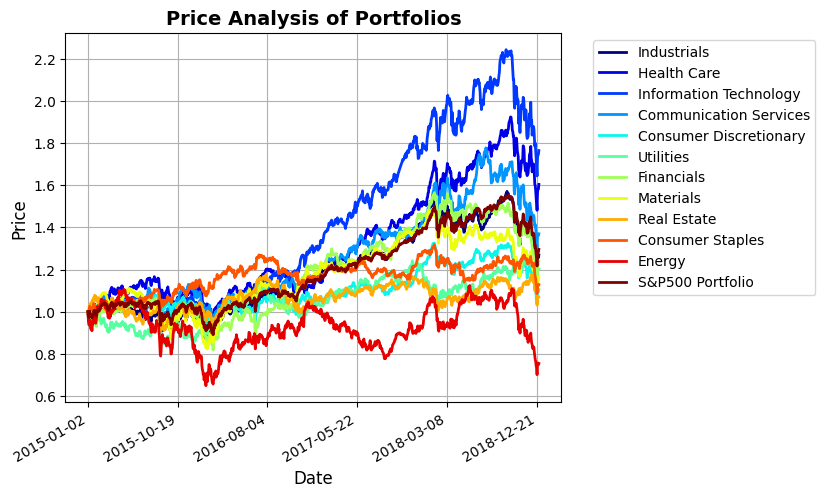

In [46]:
# Define a dataframe containing the mean prices of sector-wise portfolios

df = df.dropna(axis=1)
portfolios = pd.DataFrame(columns = info['GICS Sector'].unique())

# For each sector compute the mean price and store it in the dataframe.
for sector in info['GICS Sector'].unique():

    # Define portfolio of tickers from the same sector.
    tickers_tmp = info.loc[info['GICS Sector']==sector]['Symbol'].tolist()
    tickers = [ticker for ticker in tickers_tmp if df.columns.__contains__(ticker)]

    # Store the mean price of the sector in the dataframe.
    stocks = df[tickers].dropna()
    norm_ensemble = stocks / stocks.iloc[0,:]
    portfolios[sector] = norm_ensemble.mean(1)

# Define aggregate portfolio.
stocks = df
norm_ensemble = stocks / stocks.iloc[0,:]
portfolios['S&P500 Portfolio'] = norm_ensemble.mean(1)

# Plot the mean price time-series of the portfolio.
visualise_data(plt.gca(), portfolios)

# Format axes.
format_plot(plt.gca(), 'Date', 'Price', 'Price Analysis of Portfolios', legend_out = True)

# 2 Bond Pricing

## 2.1 Examples of bond pricing

### 2.1.1 An investor receives USD 1,100 in one year in return for an investment of USD 1,000 now. Calculate the percentage return per annum with: a) Annual compounding, b) Semi-annual compounding, c) Monthly compounding, d) Continuous compounding

From the given scenario, it is clear that the effective interest rate, $r_{eff}$, is $10\%$. However, the nominal interest rates per annum can vary based on the length of the compounding interval. Formally, the relationship between the effective interest rates, $r_{eff}$, and nominal interest rates, $r$, is represented by the equation

\begin{equation}
    1 + r_{eff} = (1 + \frac{r}{n})^n
\end{equation}

where $n$ denotes the number of compounding periods within a year. Consequently, the nominal rate, $r$, can be expressed as

\begin{equation}
    r = n \left( (1 + r_{eff})^\frac{1}{n} - 1 \right)
\end{equation}

For (a) annual, (b) semi-annual, and (c) monthly compounding (where $n = 1, 2, 12$ respectively), the corresponding nominal rates of return per annum for an effective rate of $10\%$ are

\begin{array}{ll}
    (a) & 10.00\% \\
    (b) & 9.76\% \\
    (c) & 9.57\%
\end{array}

In the limit as $n$ approaches infinity, referred to as continuous compounding, the rate converges to

\begin{equation}
    \lim_{n \to \infty} (1 + \frac{r}{n})^{nt} = e^{rt}
\end{equation}

Thus, the continuous compounding rate of return after 1 year is given by

\begin{equation}
    r = \ln(1 + r_{eff})
\end{equation}

which equates to

\begin{array}{ll}
    (d) & 9.53\%
\end{array}



### 2.1.2 What rate of interest with continuous compounding is equivalent to 15% per annum with monthly compounding?

By the same notation as in Section 2.1.1, if $r = 15\%$ per annum with monthly compounding, the effective rate is given by

\begin{equation}
    r_{eff} = (1 + \frac{r}{12})^{12} - 1 = 16.08\%
\end{equation}

Therefore, the equivalent nominal rate for continuous compounding is given by

\begin{equation}
    r = \ln(1 + 0.1608) = 14.91\%
\end{equation}

### 2.1.3 A deposit account pays 12% per annum with continuous compounding, but interest is actually paid quarterly. How much interest will be paid each quarter on a USD 10,000 deposit?

By the same notation as in Section 2.1.1, if $r = 12\%$ with continuous compounding, the effective rate is given by

\begin{equation}
    r_{eff} = e^{0.12} - 1 = 12.75\%
\end{equation}

Therefore, the equivalent nominal rate for quarterly compounding is given by

\begin{equation}
    r = 4 \left( (1 + 0.1275)^\frac{1}{4} - 1 \right) = 12.18\%
\end{equation}

In terms of quarterly cashflow, this would generate USD 304.55 in Q1, USD 313.83 in Q2, USD 323.39 in Q3 and USD 333.23 in Q4 for an initial investment of USD 10000.


## 2.2 Forward Rates

### 2.2.1 Suppose that the one–year interest rate, $r_1$ is 5%, and the two–year interest rate, $r_2$ is 7%. If you invest USD 100 for one year, your investment grows to 100 × 1.05 = USD 105; if you invest for two years, it grows to 100 × 1.072 = USD 114.49. The extra return that you earn for that second year is 1.072/1.05−1 = 0.090, or 9%.

#### 2.2.1.a Would you be happy to earn that extra 9% for investing for two years rather than one?

In the context of financial markets, the additional return realised in the second year can be interpreted as the market's expectation of the future spot rate. Under the assumption that the spot rate evolves as predicted, committing to a 2-year investment from the outset or opting for two separate 1-year investments yield identical outcomes. However, it is pertinent to acknowledge that typical investors may not have unlimited liquidity at their disposal. Consequently, there may arise circumstances necessitating access to funds within a 2-year timeframe. In such scenarios, opting for a 1-year investment provides investors with greater flexibility to access funds in the event of emergencies.

#### 2.2.1.b  Comment on the 5%, 7%, and 9% investment strategies

When deciding between investment periods, investors should prioritise evaluating the opportunity cost of potential alternative investments and assessing liquidity considerations over simply focusing on the rates. This is because the market's expectation of next year's spot rates is inherently factored into the current rates so there aren't any clear advantages of committing to a 2-year investment over a 1-year investment. Furthermore, shorter investment periods afford investors greater flexibility, enabling earlier cash-out options and facilitating the exploration of alternative investment strategies, should they be deemed advantageous.

#### 2.2.1.c Comment on the advantages and disadvantages of the forward rate of 9%.

It's evident that opting for longer-term investments carries higher inherent risks, given their exposure to a more extended timeframe during which various unforeseen factors could adversely affect the investment. Consequently, it's anticipated that the forward rate $f_{1,2}$ is higher than both $r_1$ and $r_2$. Thus, under the assumption of stable market conditions, the forward rate yields greater returns compared to a strategy involving two separate 1-year investments. However, fixing the rate could either prove advantageous or disadvantageous depending on market fluctuations throughout the investment period.

#### 2.2.1.d How much would you need to go from 1y investment to 2y investment and what does it depend upon?

Using the current spot rate curves and the implied forward rate defined in the forward rate equation below, you can compute how much would be needed to go from a 1-year investment strategy to a 2-year investment strategy.

\begin{equation}
    (1 + r_j)^j = (1 + r_i)^i (1 + f_{i,j})^{j−i}
\end{equation}

## 2.3 Duration of a coupon-bearing bond

### 2.3.1 Duration

The Macaulay Duration ($D$), as defined in the equation below, is the weighted average of the times to each of the cash payments. The times ($t_k$) are the future years 1, 2, 3, etc., extending to the final maturity date, which we call $T$. The weight for each year is the present value of the cash flow ($PV_k$) received at that time divided by the total present value of the bond ($PV_{tot}$).

\begin{equation}
  D = \sum_{k = 1}^T t_k \frac{PV_k}{PV_{tot}}
\end{equation}

The Table below shows how to compute duration for the 1\% seven-year Treasuries, assuming annual payments. First, we value each of the coupon payments of USD 10 and the final payment of coupon plus face value of USD 1,010. The present values of these payments add up to the bond price of USD 768.55. Then, we calculate the fraction of the price accounted for by each cash flow and multiply each fraction by the year of the cash flow.

![Table 1 from Coursework Document](section2-3-1-table.png)

#### 2.3.1.a  Calculate the duration for the 1\% bond in the Table.

The Macaulay duration of the 1\% bond in the table above is computed by summing the elements of the last row, which results in a duration of 6.76 years. The completed version of the table above is shown below.

In [47]:
# Completed Table
PVk_over_tot = 'PV' + sp_chars['k'][1] + ' / PV' + sp_chars['t'][1] + sp_chars['o'][1] + sp_chars['t'][1]
onepercbonddf = pd.DataFrame(columns=['year 1','year 2','year 3','year 4','year 5','year 6','year 7','Total'])

onepercbonddf.loc['Payment'] = [10,10,10,10,10,10,1010,1070]
onepercbonddf.loc['PV' + sp_chars['k'][1]] = [9.52,9.07,8.64,8.23,7.84,7.46,717.79,768.55]
onepercbonddf.loc[PVk_over_tot] = [0.0124,0.0118,0.0112,0.0107,0.0102,0.0097,0.0934,1]
onepercbonddf.loc['t' + sp_chars['k'][1] + ' * ' + PVk_over_tot] = [0.0124,0.0236,0.0337,0.0428,
                                                        0.0510,0.0583,6.5377,6.7595]

In [48]:
display(onepercbonddf)

year 1   year 2   year 3   year 4   year 5   year 6  \
Payment           10.0000  10.0000  10.0000  10.0000  10.0000  10.0000   
PVₖ                9.5200   9.0700   8.6400   8.2300   7.8400   7.4600   
PVₖ / PVₜₒₜ        0.0124   0.0118   0.0112   0.0107   0.0102   0.0097   
tₖ * PVₖ / PVₜₒₜ   0.0124   0.0236   0.0337   0.0428   0.0510   0.0583   

                     year 7      Total  
Payment           1010.0000  1070.0000  
PVₖ                717.7900   768.5500  
PVₖ / PVₜₒₜ          0.0934     1.0000  
tₖ * PVₖ / PVₜₒₜ     6.5377     6.7595

#### 2.3.1.b  Calculate the modified durations for the 1% bonds in the above table, and elaborate on the differences from the calculation in Part a).

The modified duration, denoted as $D_m$, is a measure of bond sensitivity defined by the derivative of the price-yield curve with respect to yield, normalised by the bond price. Mathematically, it can be expressed as:

\begin{equation}
    D_m = \frac{1}{P(\lambda_0)}\frac{dP(\lambda)}{d\lambda} \text{ for } \lambda = \lambda_0
\end{equation}

Here, $P(\lambda)$ represents the price of the bond as a function of the yield $\lambda$. The modified duration stems from the Taylor series approximation of the price-yield curve.

It is established that $D_m$ can be related to the Macaulay duration $D$ by the expression:

\begin{equation}
    D_m = D\left(1 + \frac{y}{m}\right)
\end{equation}

For a yield, $y$, of 5\%, $D_m$ is equal to $D\left(1 + \frac{y}{m}\right) = 6.4376\%$, where $m = 1$ since payments occur annually. This value is marginally lower than the Macaulay duration, reflecting the influence of the yield.

Intriguingly, it is noteworthy that under continuous compounding, where $m$ tends to infinity, the two duration measures converge.

#### 2.3.1.c Explain why duration (or modified duration) are convenient measures to protect the pension plan against unexpected changes in interest rates.

Duration, particularly modified duration, serves as a vital metric for safeguarding pension plans against unforeseen fluctuations in interest rates. Long-term investments, like a pension plan, typically have a higher duration compared to short-term bonds, making them more susceptible to interest rate changes due to the greater number of future coupon payments associated with them.

As elucidated in Section 2.3.1.b, modified duration provides a quantifiable assessment of a bond's risk profile. This metric, alongside traditional duration, provides investors with actionable insights into interest rate fluctuations, thereby facilitating a comprehensive evaluation of market conditions and enabling proactive measures to be taken to shield pension plans from abrupt market shifts.

Immunisation, a strategic approach grounded in statistical principles such as Duration and Convexity, emerges as an effective mechanism for fortifying portfolios against volatility. This technique revolves around aligning the portfolio's characteristics, notably price and duration, with predefined targets. By carefully selecting and allocating bonds, investors aim to achieve alignment between desired and actual portfolio characteristics, thereby mitigating the adverse effects of interest rate fluctuations.

Furthermore, the Taylor series approximation offers a theoretical framework for expanding the immunisation strategy to incorporate higher-order terms, including bond convexity. This comprehensive approach aims to optimise portfolio resilience by aligning multiple terms of the Taylor series expansion with the desired objectives, thereby enhancing the plan's ability to weather market uncertainties and ensure long-term financial stability.

## 2.4 Capital Asset Pricing Model (CAPM) and Arbitrage Pricing Theory (APT)

This section delves into the application of the Capital Asset Pricing Model (CAPM) and the Arbitrage Pricing Theory (APT) using the daily return data of 157 European companies.

CAPM is a framework used to price individual assets within the context of a risk-free asset. It establishes a relationship between an asset's rate of return and its beta, also known as systematic risk (the portion of risk that cannot be diversified away). The CAPM equation is expressed as

\begin{equation}
    E[R_i] = R_f + \beta_i(E[R_m] - R_f)
\end{equation}

where $E[R_i]$ denotes the expected return of the company, $R_f$ is the risk-free rate of interest, $E[R_m]$ represents the expected market return,  and $\beta_i = \frac{{cov(R_i, R_m)}}{{var(R_m)}}$.

On the other hand, APT is an extension of CAPM, which operates on fewer restrictive assumptions and incorporates multiple macroeconomic and specific factors (such as company size, momentum, etc.) to dissect the return of an asset. It is expressed mathematically as

\begin{equation}
    r_i = \alpha_i + \sum_j \beta_{ij} F_j + \epsilon_i
\end{equation}

where $\alpha_i$ represents the excess return, $\beta_{ij}$ denotes the sensitivity of the $i^{th}$ company's return to the $j^{th}$ factor $F_j$, and $\epsilon_i$ captures any unexplained variation in the asset's return.

### 2.4.1 Estimate the market returns per day $R_{m_{t}}$= average(company returns).

To estimate the market return, the daily returns of individual companies are aggregated, with careful consideration given to data integrity. Companies with incomplete or missing information are systematically filtered out to ensure the accuracy and reliability of the analysis. The figure below illustrates the returns of all considered companies along with the non-weighted market returns. A discernible pattern emerges, characterised by relatively modest returns for most companies, punctuated by occasional spikes in volatility for selected assets. This fluctuating trend is mirrored in the market return curve, reflecting the inherent dynamism of the financial landscape. On average, the non-weighted market return registers at 0.00472% per day, with a standard deviation of 0.00665. The market volatility, which is the standard deviation weighted by the average return (1/Sharpe ratio) is found to be approximately 141 for the non-weighted returns. This meticulous data processing underscores the importance of methodological rigor in financial analysis, providing a solid foundation for subsequent modelling and inference.

In [49]:
# Retrieve dataframe.
df = pd.read_csv(data_folder + 'fsp_case_31_BSD.csv', index_col = 0, header = [0, 1])

# Pre-process returns data.
returns = df['ret'].copy().dropna(axis=1)
returns.index = pd.to_datetime(returns.index) # Set the index to date time type
returns = returns.sort_index() # sort by time
non_weighted_market_returns = returns.mean(1)

----------------------------------------------------------
Non-Weighted Returns Mean               : 4.720252923319845e-05
Non-Weighted Returns Standard Deviation : 0.006650324555998092
1/Sharpe Ratio                          : 140.88915708611628
----------------------------------------------------------


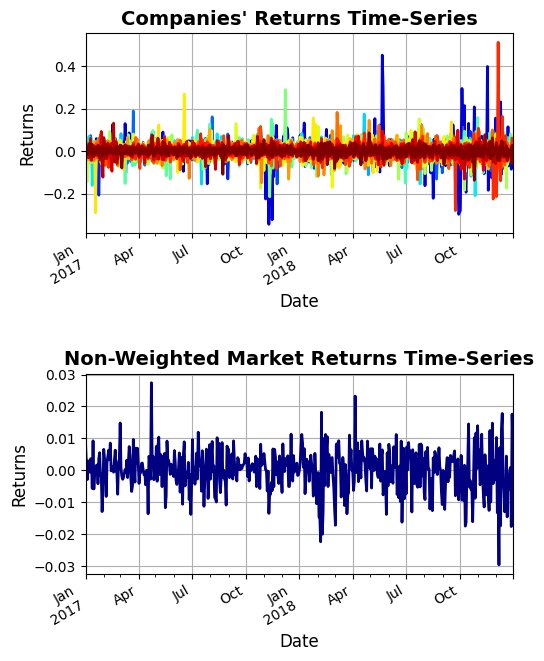

In [50]:
# Initialise subplot.
fig, axes = configure_subplots(2, 1, fig_size = (5, 6), hspace = 0.7)

# Plot company returns and format axes.
visualise_data(axes[0], returns)
format_plot(axes[0], xlabel = 'Date', ylabel = 'Returns', title = "Companies' Returns Time-Series", legend_on = False)

# Plot non-weighted returns and format axes.
visualise_data(axes[1], non_weighted_market_returns)
format_plot(axes[1], xlabel = 'Date', ylabel = 'Returns', title = 'Non-Weighted Market Returns Time-Series', legend_on = False)

# Print market statistics.
market_mean = non_weighted_market_returns.mean()
market_std = non_weighted_market_returns.std()
market_volatility = market_std/market_mean
clean_print((market_mean, market_std, market_volatility),
             ('Non-Weighted Returns Mean', 'Non-Weighted Returns Standard Deviation', '1/Sharpe Ratio'))

### 2.4.2 Estimate a rolling (sliding) beta, $\beta_{i,t}$, for every company $i$, with a rolling window of 22 days.

In this study, the estimation of market risk is undertaken through the calculation of the coefficient $\beta$, employing a rolling window of 22 trading days. This methodology involves computing the covariance of each asset with the market, normalised by the market variance. The resulting rolling $\beta$ values and associated histogram are illustrated in the figure below.

In [51]:
# Synthesise returns matrix
nwr = returns.copy()
nwr['market'] = non_weighted_market_returns.copy()

# Initialise beta dataframe
non_weighted_betadf = pd.DataFrame(columns = nwr.columns)

# Define window size
w = 22 # 1 trading month

for t in nwr.index[(w-1):]:
    # For each time step, calculate covariance matrix and betas.
    ret_cov = nwr[:t].iloc[-w:].cov()
    betas = ret_cov['market'] / ret_cov['market']['market']

    # Add to dataframe.
    non_weighted_betadf.loc[t] = betas

<ipython-input-15-7b1abdda64a3>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


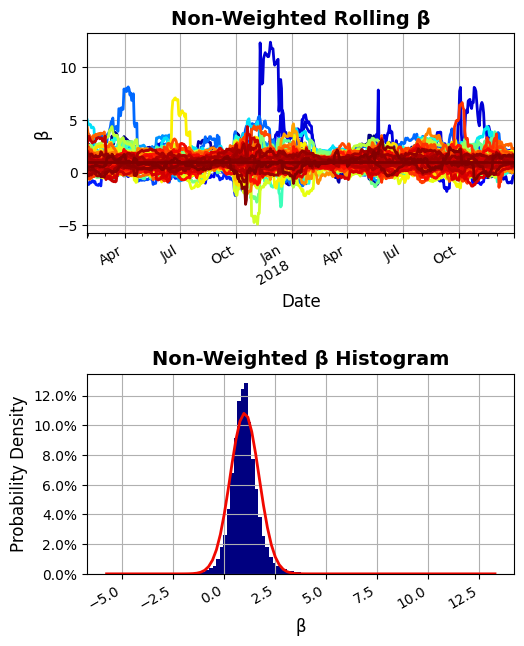

In [52]:
# Initialise subplot.
fig, axes = configure_subplots(2, 1, fig_size = (5, 6), hspace = 0.7)

# Plot rolling beta and format axes.
visualise_data(axes[0], non_weighted_betadf)
format_plot(axes[0], 'Date', greek_chars[':beta'], 'Non-Weighted Rolling '+ greek_chars[':beta'], legend_on = False)

# Plot the betas PDF in a histogram and format axes.
hist_plot_w_gauss_fit(axes[1], non_weighted_betadf.values.reshape(-1))
format_plot(axes[1], greek_chars[':beta'], 'Probability Density', 'Non-Weighted ' + greek_chars[':beta'] + ' Histogram', legend_on = False)

In [53]:
# Print beta mean and std.
clean_print((np.mean(non_weighted_betadf.values.reshape(-1)),
              np.std(non_weighted_betadf.values.reshape(-1))), ('mean ' + greek_chars[':beta'], 'std ' + greek_chars[':beta']))

----------------------------------------------------------
mean β : 1.0
std β  : 0.708104366971137
----------------------------------------------------------


In order to evaluate the risk associated with asset inclusion in a portfolio, investors have conventions for interpretting the $\beta$ magnitude. A $\beta$ value less than 1 implies that the asset is less volatile than the market, so its inclusion in a market portfolio could reduce overall portfolio risk. Conversely, a $\beta$ value exceeding 1 signifies that the asset is more volatile than the market, which may increase portfolio risk, albeit potentially accompanied by higher returns. Notably, a $\beta$ value equal to 1 denotes perfect correlation with the market, resulting in no change in portfolio risk upon inclusion.

Applying these concepts to the dataset under examination, the average systematic risk coefficient is estimated to be 1.0, aligning with expectations for a non-weighted portfolio comprising all market assets. The standard deviation, on the other hand, is estimated to be 0.708, which suggests that risk profile of assets are rather diverse within the market. These two statistics can be visualised in the histogram above.

Notably, the peaks observed in the rolling $\beta$ graph represent instances of idiosyncratic shocks associated with $\epsilon$, as previously discussed. These shocks, attributed to various factors including news events, are characterised by a zero-mean distribution, indicating risks that can be diversified away.

### 2.4.3 Cap-Weighted Market Return

In this section, we shift our focus from a non-weighted portfolio to the construction of a market portfolio, leveraging the weighted market return. This portfolio, comprising assets weighted according to their market capitalisation, offers insights into risk aversion and portfolio optimisation. Formally, the weighted market return ($R_m$) is computed as the sum of each asset's return multiplied by its market capitalisation, divided by the total market capitalisation.

\begin{equation}
\sum_i {r_i \frac{mcap_i}{\sum_i mcap_i}}
\end{equation}

This weighted approach aligns with the principles of the one-fund theorem, facilitating the formation of an efficient portfolio in the Markowitz sense when combined with a risk-free asset.

The figure below shows the weighted market returns, which has a mean of $0.018842\%$ and a standard deviation of $0.006599$. It is key to note that the market volatility factor is $35$, which is indicative of reduced risk compared to the non-weighted approach, which had a market volatility factor of $141$. This is because smaller-cap assets, which are inherently riskier, are represented in smaller proportions within the market portfolio. Intuitively, this has the effect of reducing portfolio volatility, which the extracted statistics support. This contrast in risk expression emphasises the utility of the weighted market portfolio in optimising risk-adjusted returns, a fundamental consideration in portfolio management and asset allocation strategies.

In [54]:
# Retrieve market caps.
market_cap = df['mcap'].copy()
market_cap.index = pd.to_datetime(market_cap.index)
market_cap = market_cap[returns.columns]

# Compute the weights based on the market cap.
weights = market_cap.divide(market_cap.sum(1), 0)

# Compute the weighted market returns.
weighted_returns = weights * returns.copy()
weighted_market_returns = weighted_returns.sum(1)

----------------------------------------------------------
Weighted Returns Mean               : 0.00018841990142144172
Weighted Returns Standard Deviation : 0.006599318685834846
1/Sharpe Ratio                      : 35.02453103971246
----------------------------------------------------------


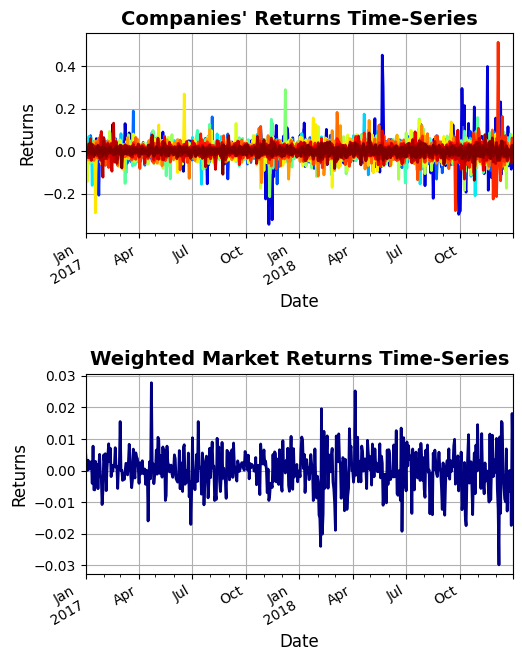

In [55]:
# Initialise subplot.
fig, axes = configure_subplots(2, 1, fig_size = (5, 6), hspace = 0.7)

# Plot company returns and format axes.
visualise_data(axes[0], returns)
format_plot(axes[0], xlabel = 'Date', ylabel = 'Returns', title = "Companies' Returns Time-Series", legend_on = False)

# Plot weighted returns and format axes.
visualise_data(axes[1], weighted_market_returns)
format_plot(axes[1], xlabel = 'Date', ylabel = 'Returns', title = 'Weighted Market Returns Time-Series', legend_on = False)

# Print market statistics.
market_mean = weighted_market_returns.mean()
market_std = weighted_market_returns.std()
market_volatility = market_std/market_mean
clean_print((market_mean, market_std, market_volatility), ('Weighted Returns Mean', 'Weighted Returns Standard Deviation', '1/Sharpe Ratio'))

### 2.4.4 Estimate a rolling $\beta_{m_{i,t}}$ like in Part 2 above but with the market return from Part 3. Compare the two betas in Part 2 and Part 4, that is, the equally-weighted $\beta_m$ and the cap-weighted $\beta_m$. For the rest of the exercise, we will use the cap-weighted $\beta_m$ (CAPM $\beta$).

Employing the same procedure as performed in Section 2.4.2, a systematic risk statistic analysis can be performed for the new weighted portfolio.

In [56]:
# Synthesise returns matrix
wr = returns.copy()
wr['market'] = weighted_market_returns.copy()

# Initialise beta dataframe
weighted_betadf = pd.DataFrame(columns = wr.columns)

# Define window size.
w = 22 # 1 trading month

for t in wr.index[w-1:]:
    # At each time step calculate covariance matrix and betas.
    ret_cov = wr[:t].iloc[-w:].cov()
    betas = ret_cov['market'] / ret_cov['market']['market']

    # Add to dataframe.
    weighted_betadf.loc[t] = betas

<ipython-input-15-7b1abdda64a3>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


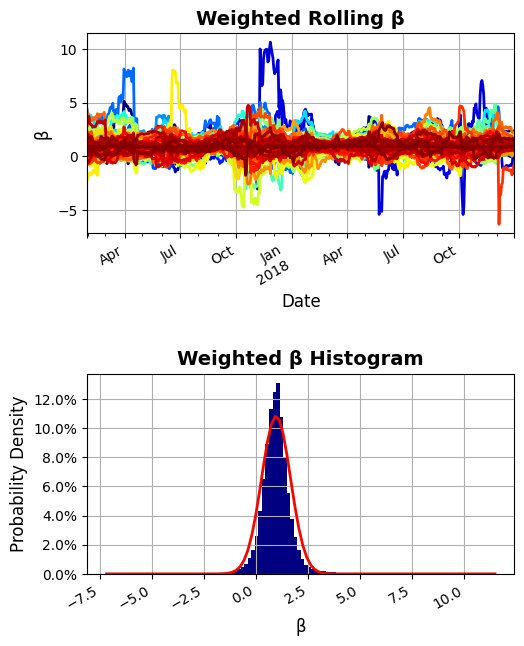

In [57]:
# Initialise subplot.
fig, axes = configure_subplots(2, 1, fig_size = (5, 6), hspace = 0.7)

# Plot rolling beta and format axes.
visualise_data(axes[0], weighted_betadf)
format_plot(axes[0], 'Date', greek_chars[':beta'], 'Weighted Rolling ' + greek_chars[':beta'], legend_on = False)

# Plot the betas pdf in a histogram and format axes.
hist_plot_w_gauss_fit(axes[1], weighted_betadf.values.reshape(-1))
format_plot(axes[1], greek_chars[':beta'], 'Probability Density',
               'Weighted ' + greek_chars[':beta'] + ' Histogram', legend_on = False)

In [58]:
# Print beta mean and std.
clean_print((np.mean(weighted_betadf.values.reshape(-1)),
              np.std(weighted_betadf.values.reshape(-1))), ('mean ' + greek_chars[':beta'], 'std ' + greek_chars[':beta']))

----------------------------------------------------------
mean β : 0.9616577418388089
std β  : 0.6940217680471462
----------------------------------------------------------


The average systematic risk for this portfolio is $0.961658$, which is less than the average systematic risk for the non-weighted portfolio. The standard deviation for this portfolio is also approximately $2\%$ less than the standard deviation of the non-weighted portfolio, with a value of $0.694022$. Both statistics suggest that the weighted portfolio has lower volatility when compared to the non-weighted portfolio, but the distinction isn't large, as expected, due to the risky nature of small-cap companies.

### 2.4.5. Arbitrage pricing theory

Assume that the arbitrage pricing theory (APT) holds for a two-factor model, and assume that the exposure to size is $b_{s_{i}} = \ln(\text{size})$, that is, per company $i$ and per every day $t$. Run for every day, $t$, the following cross-sectional regression

\begin{equation}
r_i = a + b_{m_{i}} R_m + b_{s_{i}} R_s + \epsilon_i
\end{equation}

where $\epsilon_i$ is the residual of this regression (aka specific return), and $r_i$ denotes the return per company. Effectively, we regress for $a$, $R_m$, and $R_s$ (or for $R_{s_{t}}$ as this is for every day), and after this regression, you will have one $a$, one $R_m$, and one $R_s$ per day.

#### 2.4.5.a Estimate $a$, $R_m$, and $R_s$.

In order to estimate the parameters $a$, $R_m$, and $R_s$ for every day of the time-series, the Ordinary Least Square (OLS) regression analysis is used. Firstly, we define the following matrices:

\begin{equation}
    \mathbf{r} = \mathbf{A}\mathbf{x}+\mathbf{\epsilon}
\end{equation}

which in expanded form would be represented as

\begin{equation}
    \begin{bmatrix}
        r_1 \\
        r_2 \\
        \vdots \\
        r_n \\
    \end{bmatrix}
    =
    \begin{bmatrix}
        1 & \beta_{m,1} & \beta_{s,1} \\
        1 & \beta_{m,2} & \beta_{s,2} \\
        \vdots & \vdots & \vdots \\
        1 & \beta_{m,n} & \beta_{s,n} \\
    \end{bmatrix}
    \begin{bmatrix}
        \alpha \\
        R_m \\
        R_s \\
    \end{bmatrix}
    +
    \begin{bmatrix}
        \epsilon_1 \\
        \epsilon_2 \\
        \vdots \\
        \epsilon_n \\
    \end{bmatrix}
\end{equation}

The solution to this OLS problem is given by

\begin{equation}
    \hat{\mathbf{x}} = (\mathbf{A}^T\mathbf{A})^{-1}\mathbf{A}^T\mathbf{r}
\end{equation}


In [59]:
# Copy returns
copy_returns = returns.copy()
copy_returns = copy_returns.loc[weighted_betadf.index]

# Retrieve market beta
market_beta = weighted_betadf.iloc[:, :-1]

# Retrieve size of beta
beta_size = np.log(market_cap.loc[weighted_betadf.index])

# Initialize the R_m, R_s, a and E_i matrices.
Rm = pd.Series(index = copy_returns.index, dtype='float64')
Rs = pd.Series(index = copy_returns.index, dtype='float64')
a = pd.Series(index = copy_returns.index, dtype='float64')
e = pd.DataFrame(index = copy_returns.index, columns = copy_returns.columns)

for t in copy_returns.index:
    # At each time frame compute current return, current market beta and current beta size.
    curr_ret = copy_returns.loc[t].values.reshape(-1,1)
    curr_market_beta = market_beta.loc[t].values.reshape(-1,1)
    curr_beta_size = beta_size.loc[t].values.reshape(-1,1)

    # Compute A and x.
    one_matrix = np.ones((curr_market_beta.shape))
    A = np.hstack((one_matrix, curr_market_beta, curr_beta_size))
    x = (np.linalg.inv(A.T @ A) @ A.T) @ curr_ret

    # save current values for R_m, R_s, a and E_i.
    Rm[t] = float(x[1])
    Rs[t] = float(x[2])
    a[t] = float(x[0])
    e.loc[t] = (curr_ret - A @ x).reshape(1,-1)

<ipython-input-59-9501fab028eb>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Rm[t] = float(x[1])
<ipython-input-59-9501fab028eb>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Rs[t] = float(x[2])
<ipython-input-59-9501fab028eb>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a[t] = float(x[0])


#### 2.4.5.b Comment on the magnitude and variance of $a$, $R_m$, and $R_s$.


<ipython-input-15-7b1abdda64a3>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


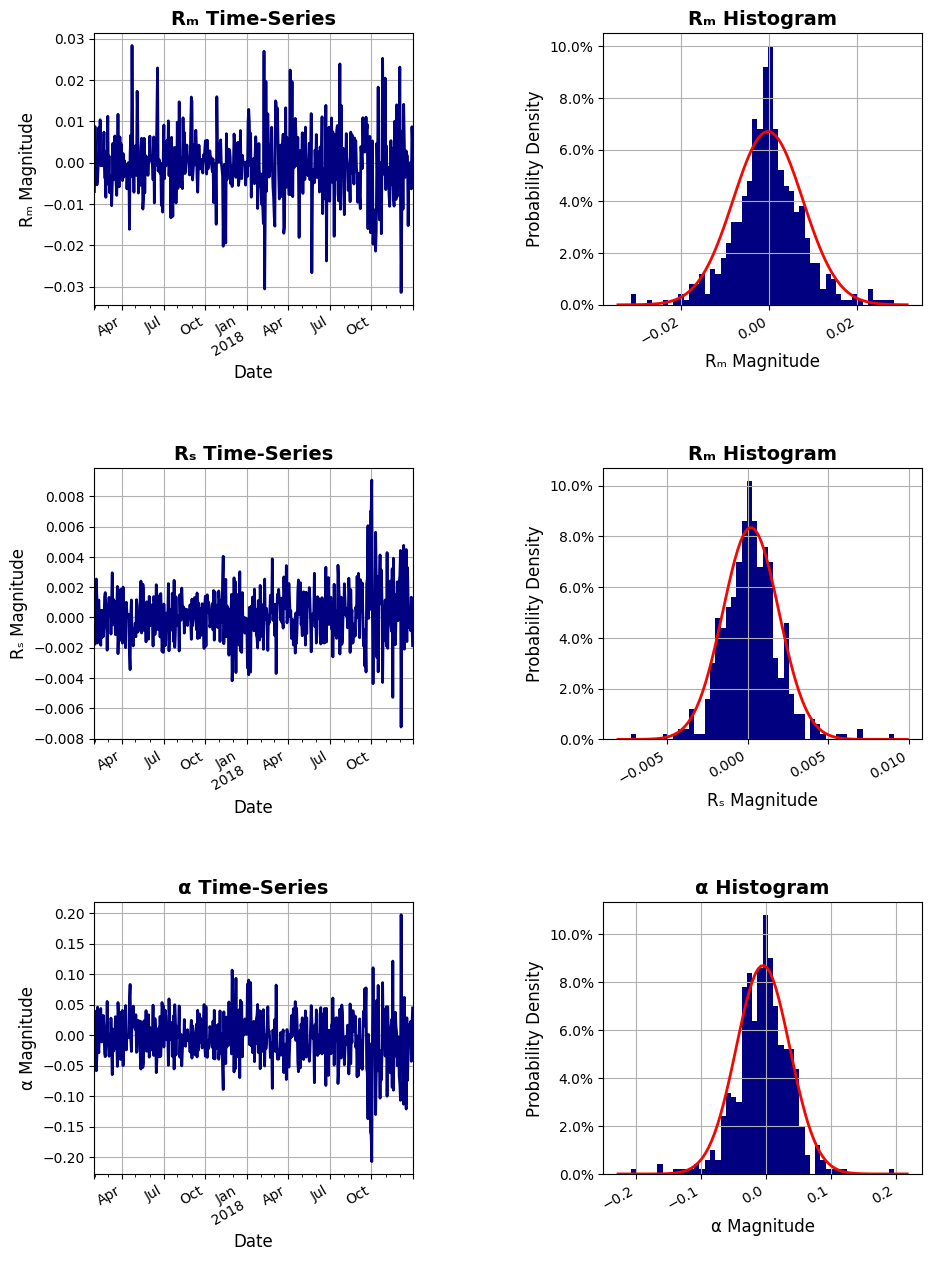

In [60]:
# Initialise subplot.
fig, axes = configure_subplots(3, 2, fig_size = (9, 12))

# Plot and format parameters' time-series.
visualise_data(axes[0][0], Rm)
format_plot(axes[0][0], xlabel='Date', ylabel = 'R' + sp_chars['m'][1] + ' Magnitude', title = 'R' + sp_chars['m'][1] + ' Time-Series', legend_on = False)

visualise_data(axes[1][0], Rs)
format_plot(axes[1][0], xlabel='Date', ylabel = 'R' + sp_chars['s'][1] + ' Magnitude', title = 'R' + sp_chars['s'][1] + ' Time-Series', legend_on = False)

visualise_data(axes[2][0], a)
format_plot(axes[2][0], xlabel='Date', ylabel = greek_chars[':alpha'] + ' Magnitude', title = greek_chars[':alpha'] + ' Time-Series', legend_on = False)


# Plot and format the PDFs obtained for each parameter.
hist_plot_w_gauss_fit(axes[0][1], Rm, bins = 50)
format_plot(axes[0][1], 'R' + sp_chars['m'][1] + ' Magnitude', 'Probability Density', title = 'R' + sp_chars['m'][1] + ' Histogram', legend_on = False)

hist_plot_w_gauss_fit(axes[1][1], Rs, bins = 50)
format_plot(axes[1][1], 'R' + sp_chars['s'][1] + ' Magnitude', 'Probability Density', title = 'R' + sp_chars['m'][1] + ' Histogram', legend_on = False)

hist_plot_w_gauss_fit(axes[2][1], a, bins = 50)
format_plot(axes[2][1], greek_chars[':alpha'] + ' Magnitude', 'Probability Density', title = greek_chars[':alpha'] + ' Histogram', legend_on = False)

The figure above shows the time-series plots of the daily estimates of the parameters, along with corresponding histograms, whilst the table below presents key statistics for the data. From the histograms, we observe that all of the parameters are approximately zero-mean normally random variables. From the table, it can be seen that the estimate of the magnitude of $\alpha$ is the largest on average, followed by $R_m$ and $R_s$, which is expected as $\alpha$ has the largest impact on the returns. Similarly, the standard deviation of $\alpha$ is largest followed by $R_m$ and $R_s$.

Notably, $R_m$ has the largest mean-normalised standard deviation, reflecting the inherent chaotic nature of the market.

In [61]:
# Populate table with stats for the parameters
stats = pd.DataFrame(index=['Rm','Rs','a','|Rm|','|Rs|','|a|'], columns=['mean', 'std', '|std/mean|'])

stats.loc['Rm'] =[Rm.mean(), Rm.std(), abs(Rm.std()/Rm.mean())]
stats.loc['Rs'] =[Rs.mean(), Rs.std(), abs(Rs.std()/Rs.mean())]
stats.loc['a'] =[a.mean(), a.std(), abs(a.std()/a.mean())]
stats.loc['|Rm|'] =[Rm.abs().mean(), Rm.abs().std(), abs(Rm.abs().std()/Rm.abs().mean())]
stats.loc['|Rs|'] =[Rs.abs().mean(), Rs.abs().std(), abs(Rs.abs().std()/Rs.abs().mean())]
stats.loc['|a|'] =[a.abs().mean(), a.abs().std(), abs(a.abs().std()/a.abs().mean())]

stats

mean       std |std/mean|
Rm   -0.000286  0.007913  27.670946
Rs    0.000192  0.001732   9.004126
a    -0.004216  0.041191   9.771005
|Rm|  0.005729  0.005459   0.952967
|Rs|  0.001295  0.001165   0.899203
|a|    0.03079  0.027651   0.898066

#### 2.4.5.c Now, we are moving to the temporal domain rather than the spatial (cross-sectional) domain. Find the correlation through time for every company, that is, $< \epsilon_i, r_i >$, where $\epsilon_i$ is called the specific return.

The decomposition of returns based on factors is typically conducted spatially, across various stocks. However, the focus of this section is on examining the temporal characteristics. The figure below illustrates the correlation between each company's return ($r_i$) and specific return ($\epsilon_i$), denoted as $\langle \epsilon_i, r_i \rangle$. The specific return represents the disparity between a company's actual return and the return explainable by the factors considered in the analysis, namely, the market and size factors discussed in Section 2.4.5.b. From the histogram below, it can be seen that the mean correlation is very high for the two factors, with a mean correlation of $81\%$. This implies that the factors under scrutiny are insufficient to fully elucidate the observed returns. Consequently, additional factors are warranted for the Arbitrage Pricing Theory model to enhance its predictive capacity regarding companies' actual returns.



<ipython-input-15-7b1abdda64a3>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


----------------------------------------------------------
correlation mean : 0.8114918953521891
correlation std  : 0.07592528090185083
----------------------------------------------------------


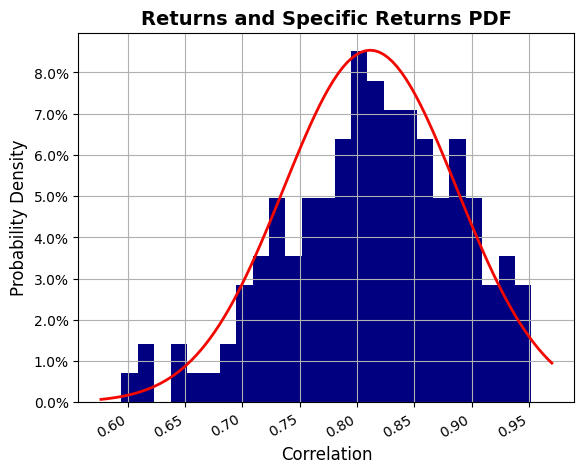

In [62]:
# Compute the correlation between returns and specific returns.
specific_returns_correlation = pd.Series(index = e.columns, dtype = 'float64')

for company in e.columns:
    specific_returns_correlation[company] = pearsonr(e[company], copy_returns[company])[0]


# Plot the correlation PDF for returns and specific returns.
hist_plot_w_gauss_fit(plt.gca(), specific_returns_correlation, bins = 25)

# Format axes
format_plot(plt.gca(), 'Correlation', 'Probability Density',
               'Returns and Specific Returns PDF', legend_on = False)


# Print the mean and variance of the correlation.
clean_print((specific_returns_correlation.mean(), specific_returns_correlation.std()), ('correlation mean', 'correlation std'))


#### 2.4.5.d Covariance Matrix Stability Analysis

From the results of Part 5a), you have two time series per day, that is, two vectors of returns, $R_m$ and $R_s$, which can be combined into the matrix

\begin{equation}
    R = \begin{bmatrix}
    R_{m_{1}} & R_{s_{1}} \\
    \vdots & \vdots \\
    R_{m_{500}} & R_{s_{500}} \\
    \end{bmatrix}
\end{equation}

Calculate the covariance matrix, $\mathbf{cov}(R)$ (Hint: it is of size $2 \times 2$) using a rolling window of 22 days.

Comment on the magnitude and stability of the covariance matrix.


In [63]:
# Synthesize R.
R = pd.DataFrame(columns=['Rm', 'Rs'])
R['Rm']= Rm
R['Rs']= Rs

# Run a rolling covariance analysis
R_Cov = []
w = 22
for t in R.index[(w-1):]:
    curr_R = R[:t].iloc[-w:]
    curr_R_cov = np.cov(curr_R.T)
    R_Cov.append(curr_R_cov)

R_Cov = np.array(R_Cov)

# Compute rolling magnitude and stability.
rolling_magnitude = pd.Series(index = R.index[(w-1):], dtype = 'float')
rolling_stability = pd.Series(index = R.index[(w-1):], dtype = 'float')

for i in range(1, R_Cov.shape[0]):
    # Estimate magnitude.
    curr_R_cov = R_Cov[i]
    rolling_magnitude[i] = (np.linalg.norm(curr_R_cov))

    # Estimate stability as the average absolute percentage change of successive covariances.
    prev_R_cov = R_Cov[i-1]
    rolling_stability[i] = (100 * np.mean(abs((curr_R_cov - prev_R_cov) / prev_R_cov)))


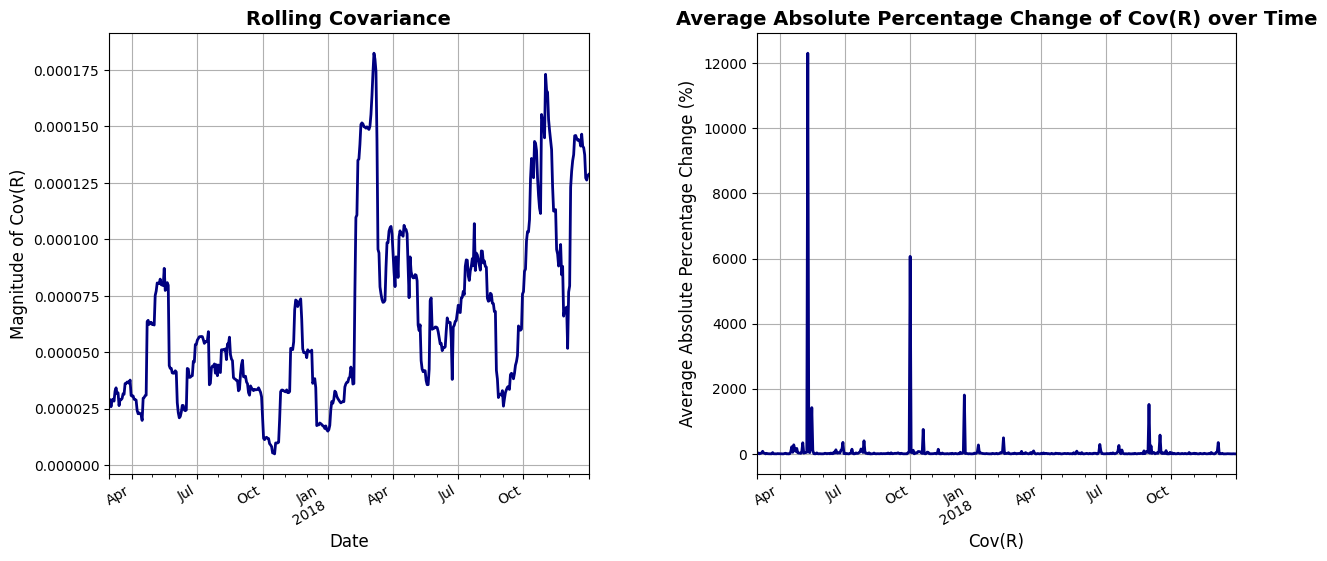

In [64]:
# Initialise subplot.
fig, axes = configure_subplots(1, 2, fig_size = (12, 5), wspace = 0.35)

# Plot rolling covariance magnitude.
visualise_data(axes[0], rolling_magnitude)
format_plot(axes[0], 'Date', 'Magnitude of Cov(R)', 'Rolling Covariance', legend_on = False)

# Plot percentage change of succesive covariances over time.
visualise_data(axes[1], rolling_stability)
format_plot(axes[1], 'Cov(R)', 'Average Absolute Percentage Change (%)',
               'Average Absolute Percentage Change of Cov(R) over Time', legend_on = False)


The pronounced oscillations evident in the upper subplot above suggest the inherent instability of the covariance matrix. This observation is backed by the average absolute percentage change between consecutive covariances depicted in the lower subplot. The abrupt fluctuations from one day to the next highlights the precarious nature of the covariance matrix and emphasise the redundancy of past covariance estimates for future applications.

#### 2.4.5.e Principal Component Analysis (PCA)

From Part 5a), you have for every company, $i$, and for every day, $t$, the specific return $\epsilon_{i,t}$. We can therefore form the following matrix $E$:

\begin{equation}
E =
    \begin{bmatrix}
    \epsilon_{1,t=0} & \dots & \epsilon_{157,t=0} \\
    \epsilon_{1,t=1} & \dots & \epsilon_{157,t=1} \\
    \vdots & \ddots & \vdots \\
    \epsilon_{1,t=500} & \dots & \epsilon_{157,t=500}
    \end{bmatrix}
\end{equation}

This matrix has dimensions $500 \times 157$. Estimate the covariance matrix of these specific returns, $\text{cov}(E)$ (Hint: the size of the matrix is $157 \times 157$).

Perform PCA on the covariance matrix from Part e), find the percentage of the variance explained by the first principal component, and comment on the result.

In this section, the dataset comprises stock prices from $141$ companies observed over $500$ time-steps, with $16$ of the expected $157$ data points omitted due to incompleteness. Therefore, the size of $\text{cov}(E)$ is expected to be $141 \times 141$. Via Principle Component Analysis (PCA), the eigenvectors and corresponding eigenvalues can be inferred from $\text{cov}(E)$. The figure below illustrates a Scree plot and a graph of cumulative variance, depicting the information retained in the first $x$ principal components.

<ipython-input-65-cfa858d8170c>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(['0.0%', '20.0%', '40.0%', '60.0%', '80.0%', '100.0%'])


[Text(0, 0.0, '0.0%'),
 Text(0, 20.0, '20.0%'),
 Text(0, 40.0, '40.0%'),
 Text(0, 60.0, '60.0%'),
 Text(0, 80.0, '80.0%'),
 Text(0, 100.0, '100.0%'),
 Text(0, 120.0, '')]

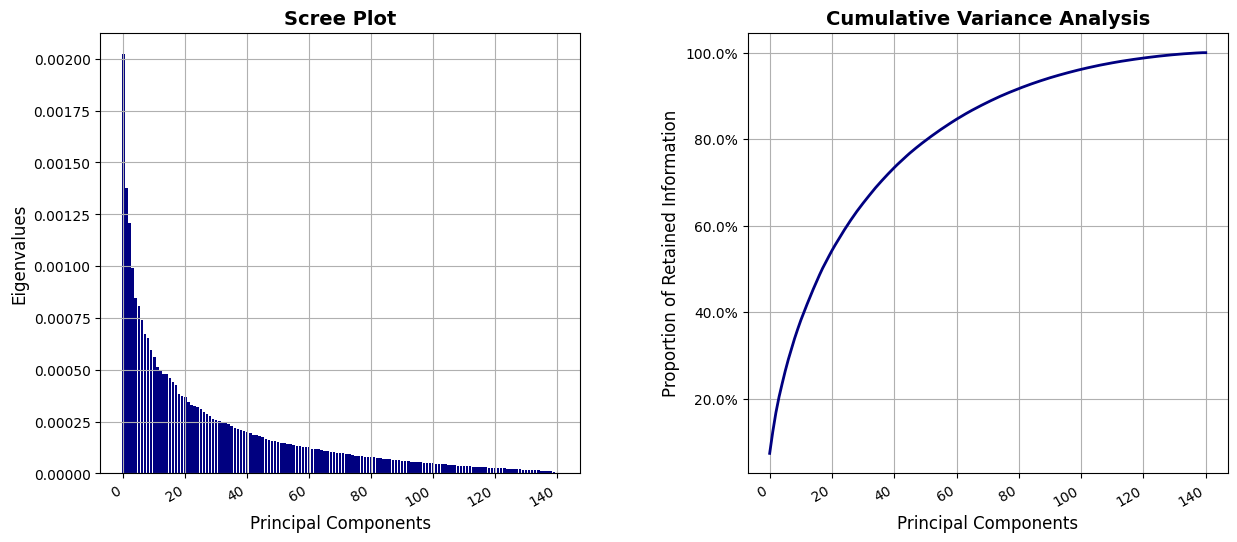

In [65]:
# Compute eigenvalues and eigenvectors.
eigvals, eigvecs = np.linalg.eigh(e.astype(float).cov())

# Initialise subplot.
fig, axes = configure_subplots(1, 2, fig_size = (12, 5), wspace = 0.35)

# Format eigenvalues and compute cumulative variance.
eigvals = eigvals[::-1]
cum_exp_var = np.cumsum(eigvals/sum(eigvals) * 100)

# Plot Scree Plot and format axes.
axes[0].bar(np.arange(len(eigvals)), eigvals.T, color = CMAP_OBJ(0))
format_plot(axes[0], xlabel = 'Principal Components', ylabel = 'Eigenvalues', title = 'Scree Plot', legend_on=False)

# Plot Cumulative Variance and format axes.
visualise_data(axes[1], cum_exp_var)
format_plot(axes[1], xlabel = 'Principal Components', ylabel = 'Proportion of Retained Information', title = 'Cumulative Variance Analysis', legend_on=False)

# Set ticks to percentages.
axes[1].set_yticklabels(['0.0%', '20.0%', '40.0%', '60.0%', '80.0%', '100.0%'])

In [66]:
clean_print(cum_exp_var[0], 'Percentage of Information Retained in PC1')

----------------------------------------------------------
Percentage of Information Retained in PC1 : 7.372197373910967
----------------------------------------------------------


The plots indicate that the initial 50 principal components encapsulate around $80\%$ of the variance in the data, while the subsequent components contribute insignificantly to the variance. Specifically, the first principal component elucidates approximately $7.37\%$ of the variance. It is clear from the conducted analysis that in order to model prices accurately, a very large number of dimensions are required. This necessity poses significant computational demands, which at times, can render large dimensional data processing tasks impossible.

# 3. Portfolio Optimisation

## 3.1 Adaptive Minumum-Variance Portfolio Optimisation

In this section, we explore how a portfolio can be optimised for minimum variance i.e. find the optimal rate of return for minimal risk. This can be posed as the following optimisation problem:

\begin{equation}
    \min_{\boldsymbol{w}} J(\boldsymbol{w}, \boldsymbol{C}) = \frac{1}{2} \boldsymbol{w}^T\boldsymbol{C}\boldsymbol{w}
\end{equation}

\begin{equation*}
    \text{subject to } \boldsymbol{w}^T\boldsymbol{1} = 1
\end{equation*}

where $\boldsymbol{w}$ represents the vector of portfolio weights and $\boldsymbol{C}$ represents the covariance matrix of all asset returns and $\boldsymbol{1}$ is a vector of ones. The expected return and variance of the portfolio are therefore defined as follows:

\begin{equation}
    \bar{\mu} = \boldsymbol{w}^T\boldsymbol{\mu}  \;\;\; \text{and} \;\;\; \bar{\sigma}^2 = \boldsymbol{w}^T\boldsymbol{C}\boldsymbol{w}
\end{equation}

### 3.1.1 Derive the optimal weights to construct the minimum variance portfolio by solving the optimisation problem above and derive the theoretical variance of your returns if we were to apply the minimum variance estimator.

The Lagrangian optimisation problem is defined as follows:

\begin{equation}
    \min_{\boldsymbol{w},\lambda} J'(\boldsymbol{w}, \lambda, \boldsymbol{C}) = \frac{1}{2} \boldsymbol{w}^T \boldsymbol{C}\boldsymbol{w} - \lambda(\boldsymbol{w}^T \boldsymbol{1} - 1)
\end{equation}

To solve the given minimisation task, the Langrangian is differentiated with respect to the Lagrange multiplier $\lambda$ and with respect to the weights vector $\boldsymbol{w}$, and then both derivatives are set to zero to obtain the optimality conditions and hence, the optimal weights vector. By differentiating the Lagrangian with respect to $\boldsymbol{w}$ and setting the derivative to zero, we obtain

\begin{equation}
    \frac{\partial L}{\partial \boldsymbol{w}} = \boldsymbol{C}\boldsymbol{w} - \lambda\boldsymbol{1} = 0
\end{equation}

Solving for $\boldsymbol{w}$, we get

\begin{equation}
    \boldsymbol{w} = \lambda \boldsymbol{C}^{-1} \boldsymbol{1}
\end{equation}

Similarly, by differentiating the Lagrangian with respect to $\lambda$ and setting the derivative to zero, we obtain

\begin{equation}
    \frac{\partial L}{\partial \lambda} = \boldsymbol{w}^{T}\boldsymbol{1} - 1 = 0
\end{equation}

Solving for $\boldsymbol{w}$, we get

\begin{equation}
    \boldsymbol{w}^{T}\boldsymbol{1} = 1
\end{equation}

Through substitution and some matrix manipulations, we have

\begin{equation}
    \boldsymbol{1}^T\boldsymbol{w} = 1 \Longrightarrow \boldsymbol{1}^T (\lambda \boldsymbol{C}^{-1} \boldsymbol{1}) = 1 \Longrightarrow \lambda\boldsymbol{1}^T\boldsymbol{C}^{-1}\boldsymbol{1} = 1 \Longrightarrow \lambda = \frac{1}{\boldsymbol{1}^T\boldsymbol{C}^{-1}\boldsymbol{1}}
\end{equation}

Substituting this value of $\lambda$ back into the expression for $w$, we get

\begin{equation}
    \boldsymbol{w_{opt}} = \frac{1}{\boldsymbol{1}^T\boldsymbol{C}^{-1}\boldsymbol{1}} \boldsymbol{C}^{-1} \boldsymbol{1} = \frac{\boldsymbol{C}^{-1} \boldsymbol{1}}{\boldsymbol{1}^T\boldsymbol{C}^{-1}\boldsymbol{1}}
\end{equation}

where $\boldsymbol{w_{opt}}$ denotes the optimal set of weights.

In order to derive the theoretical variance of returns using the minimum variance estimator, we can substitute the optimal weights $\boldsymbol{w_{opt}}$ into the variance formula, which gives us

\begin{equation}
    (\bar{\sigma}^{2})_{opt} = \boldsymbol{w_{opt}}^{T}\boldsymbol{C}\boldsymbol{w_{opt}} = (\frac{\boldsymbol{C}^{-1} \boldsymbol{1}}{\boldsymbol{1}^T\boldsymbol{C}^{-1}\boldsymbol{1}})^T C (\frac{\boldsymbol{C}^{-1} \boldsymbol{1}}{\boldsymbol{1}^T\boldsymbol{C}^{-1}\boldsymbol{1}}) = \frac{\boldsymbol{1}^T\boldsymbol{C}^{-1^{T}}\boldsymbol{C}\boldsymbol{C}^{-1}\boldsymbol{1}}{(\boldsymbol{1}^T\boldsymbol{C}^{-1^{T}}\boldsymbol{1})(\boldsymbol{1}^T\boldsymbol{C}^{-1}\boldsymbol{1})} =
    \frac{1}{\boldsymbol{1}^T \boldsymbol{C}^{-1} \boldsymbol{1}}
\end{equation}

as the variance of returns for the minimum variance portfolio.

### 3.1.2 Minimum-Variance Portfolio Analysis

In this section, a minimum-variance portfolio will be computed using the daily returns of 10 stocks from 2017 to 2018, and its performance will be tested by applying those computed optimal weights to the same stocks from 2018 to 2019. This is done by splitting the data using a 50:50 ratio into a training set and testing set. The first figure below shows the daily returns for the 10 stocks in the dataset from 2017 to 2019. The second figure below presents the results obtained on both sets for both the equally-weighted portfolio and minimum-variance portfolio.

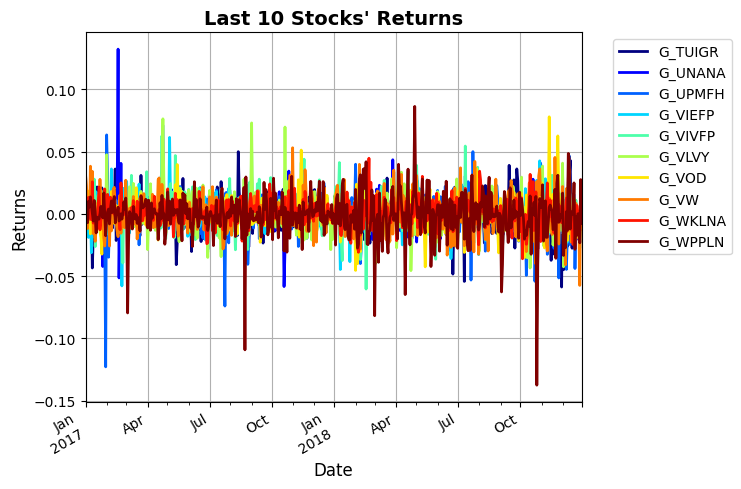

In [67]:
# Retrieve returns data.
df = pd.read_csv(data_folder + 'fsp_case_31_BSD.csv', index_col = 0, header = [0,1])
returns = df['ret'].copy().dropna(axis=1)
returns.index = pd.to_datetime(returns.index)
returns = returns.iloc[:, -10:] # Select only the last 10 stocks

# Plot and format the returns for the last 10 stocks
visualise_data(plt.gca(), returns)
format_plot(plt.gca(), 'Date', 'Returns', "Last 10 Stocks' Returns",
               display_names = returns.columns, legend_out = True)

# Split training and test data
half_split = int(returns.shape[0] / 2)
data_training = returns.iloc[:half_split, :]
data_test = returns.iloc[half_split:, :]

In [68]:
# Define portfolio stats dataframe.
port_stats = pd.DataFrame(index = ['Equally Weighted Training', 'Minimum Variance Training',
                                    'Equally Weighted Testing', 'Minimum Variance Testing'],
                        columns = ['Mean Return', 'Cumulative Return',
                                 'Variance', 'Theoretical Variance'])

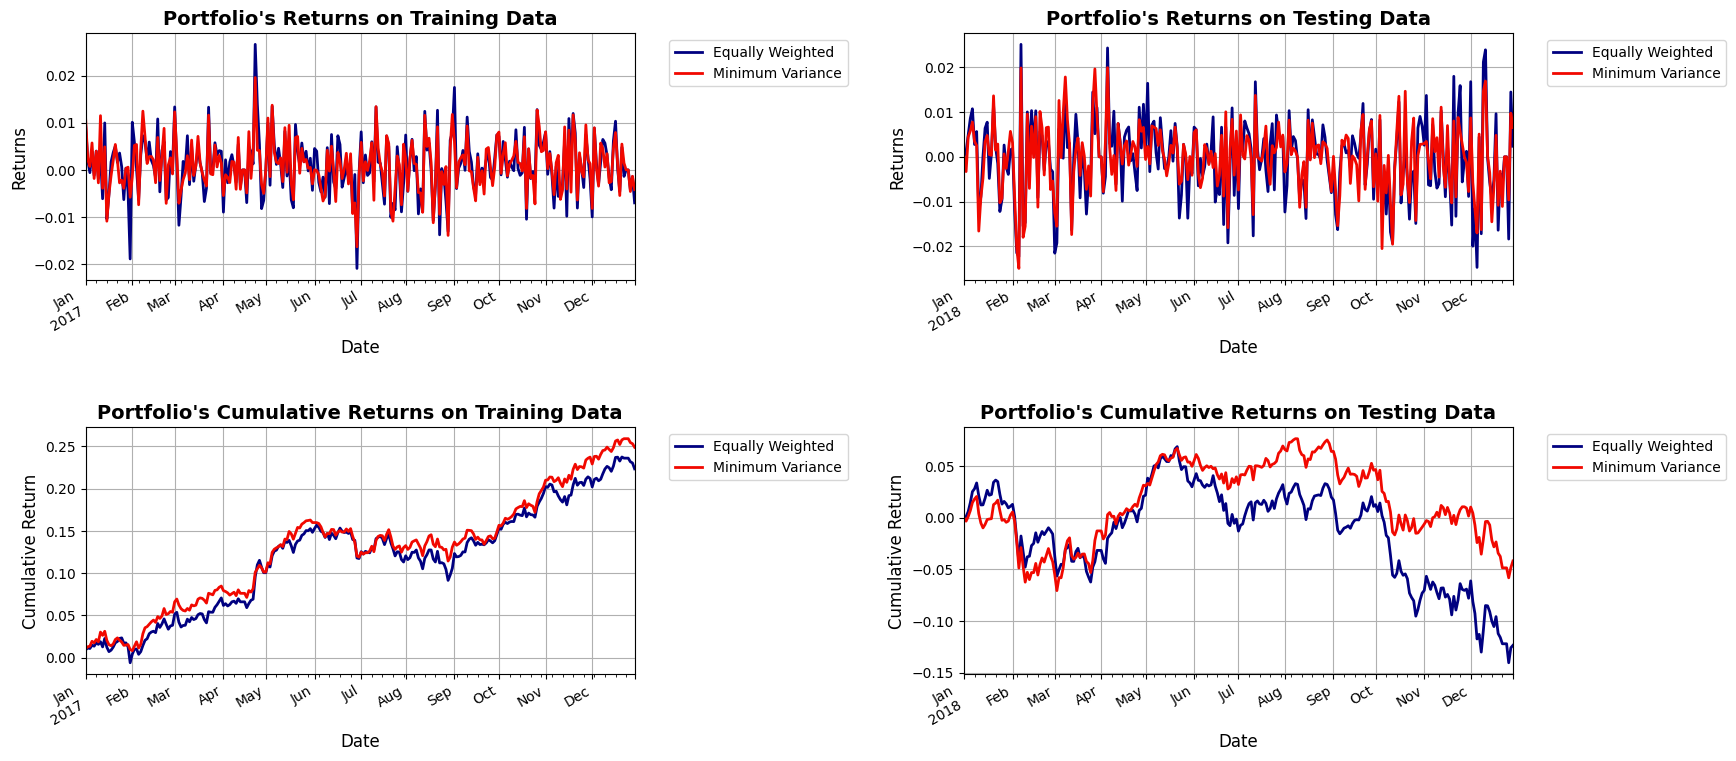

In [69]:
# Initialise subplot
fig, axes = configure_subplots(2, 2, fig_size = (15, 7))

# Axes index
i = 0

# For both training data and testing data
for portfolio in (data_training.mean(1), data_test.mean(1)):

    # Plot equally weighted portfolio returns and cumulative sum
    visualise_data(axes[0][i], portfolio, label = "Equally Weighted")
    visualise_data(axes[1][i], portfolio.cumsum(), label = "Equally Weighted")

    # Assign variable appropriately based on whether we are using training or testing data.
    if i == 0:
        dataset = data_training
        dataset_label = 'Training'
    else:
        dataset = data_test
        dataset_label = 'Testing'

    # Compute covariance and optimal weights.
    C = dataset.cov()
    opt_weights = compute_opt_weights(C, dataset)
    mvpf = (dataset * opt_weights).sum(1)
    one_matrix = np.ones((opt_weights.shape)).reshape(-1, 1)
    theo_var = 1 / (one_matrix.T @ np.linalg.inv(C).T @ one_matrix)

    # Equally weighted portfolio statistics.
    eq_wt_stats = get_portfolio_stats(portfolio) + ['-']
    port_stats.iloc[2 * i, :] =  eq_wt_stats

    # Minimum variance portfolio statistics.
    min_var_stats = get_portfolio_stats(mvpf) + [str(round(theo_var[0,0], 10))]
    port_stats.iloc[2 * i + 1, :] = min_var_stats

    # Plot minimum variance returns and cumulative sum.
    visualise_data(axes[0][i], mvpf, color = CMAP_OBJ(0.9), label = "Minimum Variance")
    visualise_data(axes[1][i], mvpf.cumsum(), color = CMAP_OBJ(0.9), label = "Minimum Variance")

    # Format axes.
    format_plot(axes[0][i], 'Date', 'Returns',  "Portfolio's Returns on " + dataset_label + " Data", legend_out=True)
    format_plot(axes[1][i], 'Date', 'Cumulative Return', "Portfolio's Cumulative Returns on " + dataset_label + " Data", legend_out=True)
    i += 1

The table below summarises key statistics obtained from the equally-weighted training set, the minimum-variance training set, the equally-weighted testing set and minimum-variance testing set.

In [70]:
port_stats

Mean Return Cumulative Return     Variance  \
Equally Weighted Training   0.0008595546         0.2234842   3.7495e-05   
Minimum Variance Training   0.0009579316      0.2490622063  2.86163e-05   
Equally Weighted Testing   -0.0004731904        -0.1235027  7.93339e-05   
Minimum Variance Testing   -0.0001602424     -0.0418232764  5.84487e-05   

                          Theoretical Variance  
Equally Weighted Training                    -  
Minimum Variance Training          2.86163e-05  
Equally Weighted Testing                     -  
Minimum Variance Testing           5.84487e-05

From the figure and table above, it is clear to see that the minimum-variance portfolio performs marginally better than the equally-weighted portfolio, with regards to all the key statistics for both the training and testing set. In the training set, the cumulative returns for both the equally-weighted portfolio and minimum-variance portfolio display a healthy upward trend, illustrating the premium associated with low volatility stocks. Conversely, in the testing set, even though the minimum-variance portfolio depicts higher cumulative return on average, both portfolios perform poorly, being unable to achieve a positive cumulative return. In order to rectify this, the training to test data split can be modified. Conventionally, a larger training set is used to generalise better, so choosing either a 60:40 or 70:30 split will be optimal.

Notably, the theoretical variance precisely aligns with the actual variance of the portfolio, a result that's expected since the optimal weights are applied to the training data.

### 3.1.3 Adaptive Minimum-Variance Portfolio Analysis

In this section, the minimum-variance optimisation method is employed recursively, with the weights being updated on a daily basis using a rolling window of length $M$. The figure below shows the cumulative returns for various rolling window sizes, $w$.

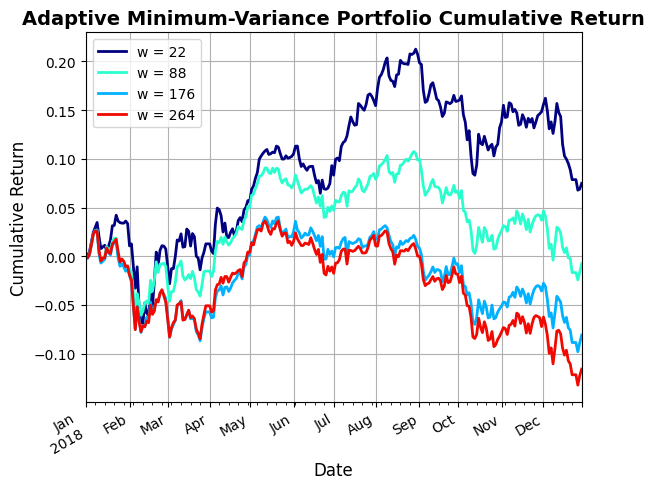

In [71]:
# Initialise window size and other variables.
windows =  [22, 88, 176, 264] # window lengths equal to 1, 4, 8 and 12 trading months
rets = []
cum_rets = []
variances = []
colors = [0, .4, .3, .9]

# Axes index
i = 0

# For all windows.
for window in windows:

    # Initialise portfolio and variables used for historical analysis.
    adaptive_min_var_port = pd.Series(dtype = 'float64')
    store_weights = []
    store_returns = []

    # For each timestamp
    for t in data_test.index:

        # Compute the current return, covariance matrix and optimal weights.
        curr_ret = returns[:t].iloc[(-window-1):-1]
        curr_cov = curr_ret.cov()
        opt_weights = compute_opt_weights(curr_cov, curr_ret)

        # Store the optimal weights and returns
        store_weights.append(opt_weights)
        adaptive_min_var_port[t] = sum(data_test.loc[t] * opt_weights)
        store_returns.append(adaptive_min_var_port[t])

    # Record the returns and variances.
    rets.append(store_returns)
    variances.append(adaptive_min_var_port.std() ** 2)

    # Plot the cumulative returns and format the axes.
    visualise_data(plt.gca(), adaptive_min_var_port.cumsum(), color = CMAP_OBJ(colors[i]),
                label = 'w = ' + str(windows[i]))
    format_plot(plt.gca(), 'Date', 'Cumulative Return', 'Adaptive Minimum-Variance Portfolio Cumulative Return')

    i += 1

The size of the window directly impacts the duration considered for covariance matrix estimation. As depicted in the plot above, shorter windows exhibit superior performance, adept at capturing short-term patterns within stock data. Of the analysed window sizes, $w=22$ had the best performance, achieving a positive cumulative return of $0.075$; this is distinctly better than the negative cumulative returns observed for both the equally-weighted and static minimum-variance model for the test set in Section 3.1.2. By updating the weights recursively, the model iteratively refines its predictions of covariance across assets, enhancing accuracy over time by effectively training on shorter time periods. However, as seen in the figure below, the variance is worse than the static minimum-variance model. This is likely due to overreaction to recent data and underestimation of long-term trends, which causes the model to overfit.

The figure below presents histograms for the logged returns for each window size.

<ipython-input-15-7b1abdda64a3>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


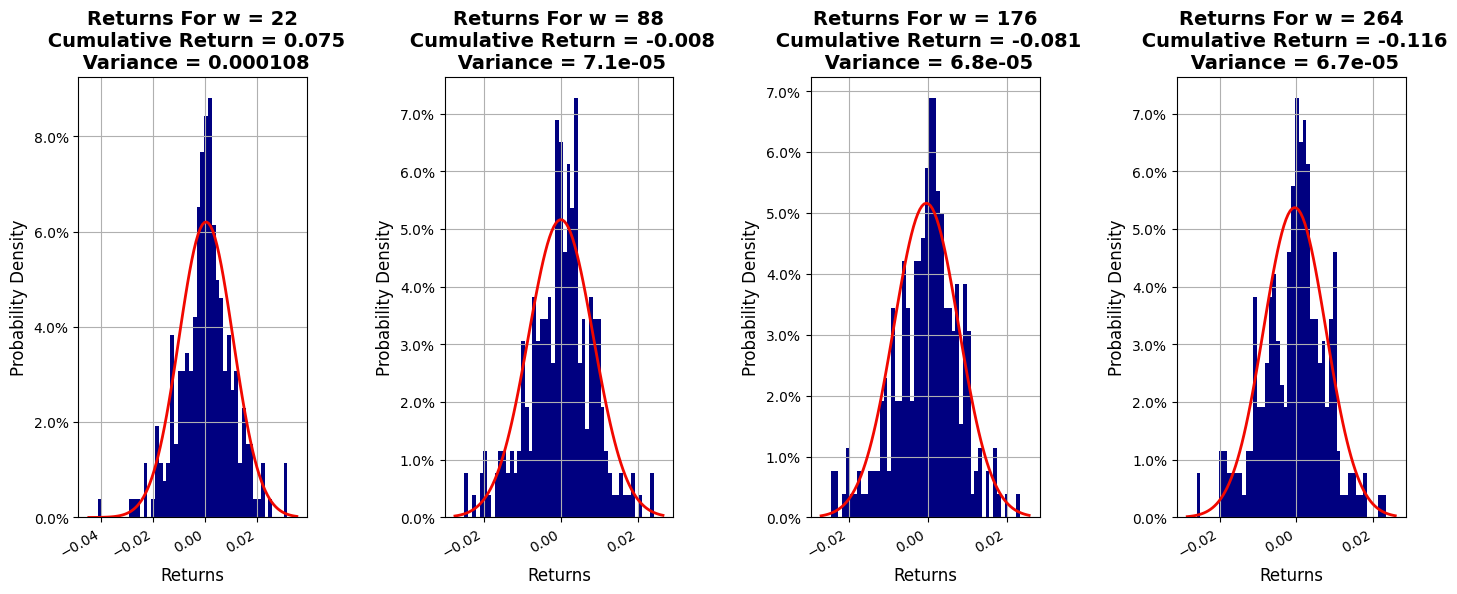

In [72]:
# Initialise subplot.
fig, axes = configure_subplots(1, 4, fig_size = (14, 5))

# For all windows.
for i in range(len(windows)):

    # Define title of the figure.
    text = "\n Cumulative Return = " + str(round(sum(rets[i]), 3)) + \
            "\n Variance = " + str(round(variances[i], 6))

    # Plot histograms for cumulative returns.
    hist_plot_w_gauss_fit(axes[i], rets[i], bins = 50)
    format_plot(axes[i], 'Returns', 'Probability Density',
                   'Returns For w = ' + str(windows[i]) + text, legend_on = False)

It's clear to see that the adaptive minimum-variance portfolio performs better than the static minimum-variance portfolio and equally-weighted portfolio for most window sizes but it could be further optimised by taking into account forecasted returns.

Furthermore, currently, the covariance matrix is estimated by using the returns of the past $M$ days being equally weighted; however, it would be beneficial to employ an exponential weighting strategy such that more relevance is given to recent price movements instead of former movements. This strategy will likely result in larger cumulative returns as recent price movements are given precedence.

# 4 Robust Statistics and Non-Linear Methods

## 4.1 Data Import and Exploratory Data Analysis

### 4.1.1 Import `AAPL.csv`, `IBM.csv`, `JPM.csv`, and `DJI.csv` into separate `pandas.DataFrames`, and set the date as the index column. For each stock and for each column, generate the key descriptive statistics (e.g. mean, median, standard deviation, etc.) that summarise the distribution of the dataset. Lastly, using the `adj. close` column for each stock, compute the 1-day returns and add them to their corresponding dataframe as a new column.

This section delves into the application of various descriptive statistics on three individual stocks (AAPL, IBM, JPM) and one index (DJI). Descriptive statistics serve as quantitative summaries of data, encompassing measures such as mean, median (representing central tendency), standard deviation, median absolute deviation, interquartile range (depicting dispersion), skewness (reflecting asymmetry), and kurtosis (indicating distribution tails). Each statistic possesses unique characteristics and responds differently to outliers, a facet that will be thoroughly examined in subsequent sections.

In general, measures of central tendency, namely mean and median, exhibit comparable tendencies across all assets. Conversely, measures of dispersion, such as standard deviation and median absolute deviation, may yield substantially different estimates, potentially leading to notable performance disparities (as seen in Section 4.4).

In [73]:
# Read data for all datasets.
AAPL = pd.read_csv(data_folder + 'AAPL.csv', index_col = 0)
AAPL.index = pd.to_datetime(AAPL.index)

IBM = pd.read_csv(data_folder + 'IBM.csv', index_col = 0)
IBM.index = pd.to_datetime(IBM.index)

JPM = pd.read_csv(data_folder + 'JPM.csv', index_col = 0)
JPM.index = pd.to_datetime(JPM.index)

DJI = pd.read_csv(data_folder + 'DJI.csv', index_col = 0)
DJI.index = pd.to_datetime(DJI.index)

all_dfs = {'AAPL': AAPL, 'IBM': IBM, 'JPM': JPM, 'DJI': DJI}

In [74]:
# Initialise necessary variables.
tickers = ['AAPL', 'IBM', 'JPM', 'DJI']
dtypes = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
stats = ['Mean', 'Median', 'StdDev', 'MAD', 'IQR', 'Skew', 'Kurtosis']
stats_df = pd.DataFrame(index = stats, columns = dtypes)
combined_stats = {'AAPL': stats_df.copy(), 'IBM': stats_df.copy(),
                  'JPM': stats_df.copy(), 'DJI': stats_df.copy()}
i = 0

In [75]:
# Step through each and every dataset and compute all the statistics
for ticker in tickers:

    data = all_dfs[ticker].copy()

    for dtype in dtypes:
        col = data[dtype]

        combined_stats[ticker][dtype]['Mean'] = col.mean()
        combined_stats[ticker][dtype]['Median'] = col.median()
        combined_stats[ticker][dtype]['StdDev'] = col.std()
        combined_stats[ticker][dtype]['MAD'] = mad(col, c = 1)
        combined_stats[ticker][dtype]['IQR'] = iqr(col)
        combined_stats[ticker][dtype]['Skew'] = col.skew()
        combined_stats[ticker][dtype]['Kurtosis'] = col.kurtosis()

In [76]:
# Display all statistics.
for ticker in tickers:
    print("\n\033[1m" + ticker + "\033[0m")
    display(combined_stats[ticker])


AAPL


Open        High         Low       Close   Adj Close  \
Mean      187.686694  189.561753  185.823705  187.711953  186.174273   
Median    186.289993  187.399994  184.940002  186.119995  184.351776   
StdDev     22.145621   22.281577   22.008797   22.160721   21.904664   
MAD        15.889999   15.610001   15.919998   15.940002   15.476044   
IQR             36.0   36.339996   36.059998   36.755004    35.68544   
Skew        0.259917    0.300385    0.220489    0.263849     0.29077   
Kurtosis   -0.912594   -0.924602   -0.917632   -0.932425   -0.928017   

                   Volume  
Mean      32704750.199203  
Median         29184000.0  
StdDev    14179721.592994  
MAD             7573900.0  
IQR            16311700.0  
Skew             1.743317  
Kurtosis         4.353182


IBM


Open        High         Low       Close   Adj Close  \
Mean      138.454382  139.492072  137.329243  138.363108  134.902751   
Median    142.809998  143.990005  142.059998  142.710007  138.566391   
StdDev     12.114308   11.913079   12.204633   12.028123   10.671648   
MAD         5.270004    5.309998    5.190002    5.230011    4.493515   
IQR        15.379998   14.720001   16.340004   15.504997   14.103938   
Skew       -0.676024   -0.622707   -0.713446   -0.682246   -0.811222   
Kurtosis   -0.585272   -0.623607   -0.561975   -0.584037   -0.420852   

                  Volume  
Mean      5198937.450199  
Median         4237900.0  
StdDev    3328955.530426  
MAD             920700.0  
IQR            1952950.0  
Skew            3.192896  
Kurtosis       11.796897


JPM


Open        High         Low       Close   Adj Close  \
Mean      108.707689  109.652072  107.682988  108.606574   107.26259   
Median        109.18  110.529999  107.790001  109.019997  107.219269   
StdDev      5.359081     5.20287    5.432537     5.30048    4.833316   
MAD         4.470001    4.309997    4.239998    4.350006    3.450157   
IQR         8.810006    8.845002    8.845001    8.834999    7.222442   
Skew       -0.420811   -0.376221   -0.377517   -0.374853   -0.344491   
Kurtosis   -0.322536   -0.544163     -0.2657   -0.396579   -0.105437   

                   Volume  
Mean      14700689.243028  
Median         13633000.0  
StdDev     5349770.564456  
MAD             3035400.0  
IQR             6233600.0  
Skew             1.693457  
Kurtosis         4.430197


DJI


Open          High           Low         Close  \
Mean      25001.257268  25142.041965  24846.002226  24999.153581   
Median    25025.580078  25124.099609  24883.039063  25044.289063   
StdDev      858.834708    815.203959    903.302186    859.132105   
MAD         543.541015     537.61914     601.56836    590.720703   
IQR         1109.43457   1077.816406   1204.418945   1158.155273   
Skew         -0.372127     -0.239367     -0.456447     -0.380147   
Kurtosis      0.485736      0.118153      0.557592      0.400668   

             Adj Close            Volume  
Mean      24999.153581  332889442.231076  
Median    25044.289063       313790000.0  
StdDev      859.132105    94078038.14115  
MAD         590.720703        50460000.0  
IQR        1158.155273       108930000.0  
Skew         -0.380147           1.73956  
Kurtosis      0.400668          5.857581

In [77]:
# Compute 1-day return using Adj Close column for each ticker and add to dataframe
for ticker in tickers:
    all_dfs[ticker]['Returns'] = all_dfs[ticker]['Adj Close'].pct_change()

### 4.1.2 Plot the histogram and probability density function of the *adj. close* and 1-day returns. Comment on the difference, if any, between the pdf of the *adj. close* and the returns.

The following figure illustrates both the empirical Probability Density Function (PDF), represented in red, and the histograms portraying the distributions, depicted in blue, of the 1-day returns and adjusted closing prices pertaining to the previously discussed tickers. As anticipated, the distribution of returns for each ticker closely approximates a normal distribution, while no discernible pattern is evident in the raw prices. This observation suggests that conventional statistical methodologies, predicated on a Gaussian distribution, are more applicable when analysing returns as opposed to prices. Consequently, in the context of price analysis, statistical metrics such as the median and median absolute deviation emerge as more effective alternatives to the mean and standard deviation.

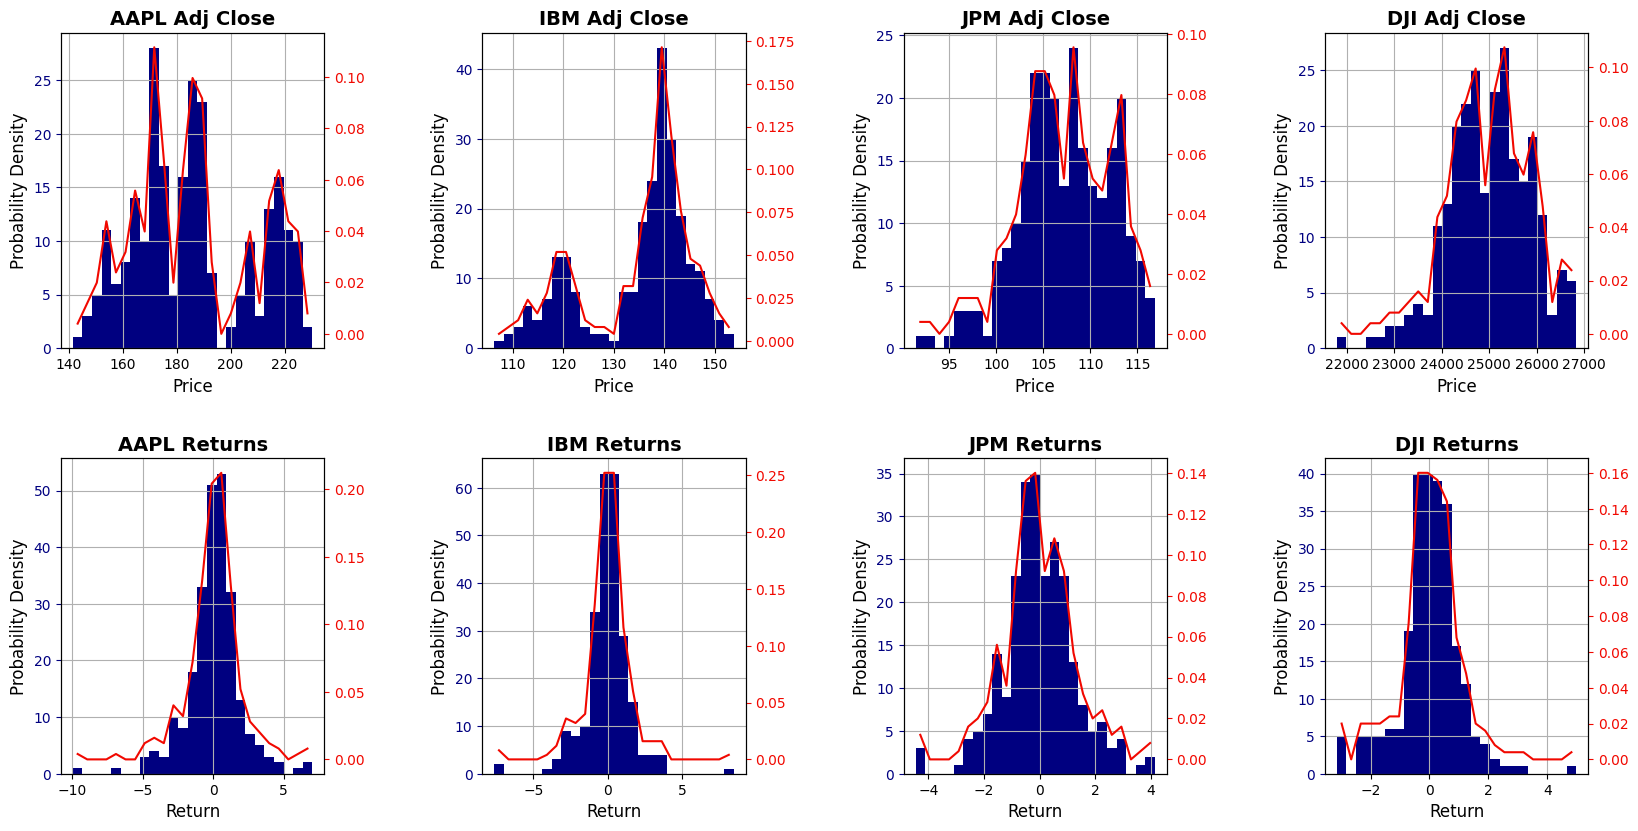

In [78]:
# Initialise subplot.
fig, axes = configure_subplots(2, 4, fig_size = (16, 8), hspace = 0.35)

for i in range(len(tickers)):

    # Retrieve price data
    price_data = all_dfs[tickers[i]]['Adj Close'].dropna()

    # Plot histogram
    tmp = axes[0][i].hist(price_data, bins=25, color=CMAP_OBJ(0))
    axes[0][i].tick_params(axis='y', colors=CMAP_OBJ(0))

    # Plot PDF
    tmp_ax = axes[0][i].twinx()
    tmp_ax.plot(tmp[1][1:]-0.5*(tmp[1][1]-tmp[1][0]), tmp[0]/sum(tmp[0]), color=CMAP_OBJ(0.9))
    tmp_ax.tick_params(axis='y', colors=CMAP_OBJ(0.9))

    # Format axes
    axes[0][i].set_title(tickers[i]+' Adj Close', **fmt_title)
    axes[0][i].set_xlabel('Price', **fmt_label)
    axes[0][i].set_ylabel('Probability Density', **fmt_label)
    axes[0][i].grid()

    # Retrieve returns data
    returns_data = 100*all_dfs[tickers[i]]['Returns'].dropna()

    # Plot histogram
    tmp = axes[1][i].hist(returns_data, bins=25, color=CMAP_OBJ(0))
    axes[1][i].tick_params(axis='y', colors=CMAP_OBJ(0))

    # Plot PDF
    tmp_ax = axes[1][i].twinx()
    tmp_ax.plot(tmp[1][1:]-0.5*(tmp[1][1]-tmp[1][0]), tmp[0]/sum(tmp[0]), color=CMAP_OBJ(0.9))
    tmp_ax.tick_params(axis='y', colors=CMAP_OBJ(0.9))

    # Format axes
    axes[1][i].set_title(tickers[i]+' Returns', **fmt_title)
    axes[1][i].set_xlabel('Return', **fmt_label)
    axes[1][i].set_ylabel('Probability Density', **fmt_label)
    axes[1][i].grid()

### 4.1.3 For each stock, plot the *adj. close*, the associated **rolling mean** (using a 5-day window), and the $\pm 1.5 \times$ standard deviations relative to the rolling mean. In a separate figure, repeat the steps above using the **rolling median** (using a 5-day window) and $\pm 1.5 \times$ **median absolute deviation** relative to the rolling median. Comment on the difference, if any, between the two figures.


In this section, we investigate the efficacy of two Z-score based techniques for outlier detection. Firstly, we employ a technique utilising the rolling price mean ($\mu$) and standard deviation ($\sigma$), identifying outliers as prices falling outside the range [μ - 1.5σ, μ + 1.5σ]. This method's results are depicted in the first figure below.

Similarly, a technique employing the rolling price median (*med*) and median absolute deviation (*mad*) is utilised, identifying prices outside the range [*med* - 1.5*mad*, *med* + 1.5*mad*] as outliers. The second figure below illustrates the outcomes obtained from this approach.

In both plots, the faded lilac region signifies the range within which prices are considered as inliers. Notably, the mean-based method exhibits a less stringent criterion, resulting in a wider range and fewer points flagged as outliers. This divergence can be attributed to the intrinsic characteristics of the descriptive statistics employed; namely, the mean's susceptibility to sudden data changes compared to the robustness of the median.

In [79]:
# Create an adj. close dataframe for all the assets and populate it.
adj_close_df = pd.DataFrame(columns = tickers)
for ticker in tickers:
    adj_close_df[ticker] = all_dfs[ticker]['Adj Close'].copy()

# Collect partial outliers data in a dataframe
outliers = pd.DataFrame(columns = ['Mean Method', 'Median Method'], index = tickers)

# Collect full outliers data in a dataframe
outliers_comp = pd.DataFrame(columns = ['Mean Method', 'Median Method', 'Mean Method With Outliers', 'Median Method With Outliers'], index = tickers)

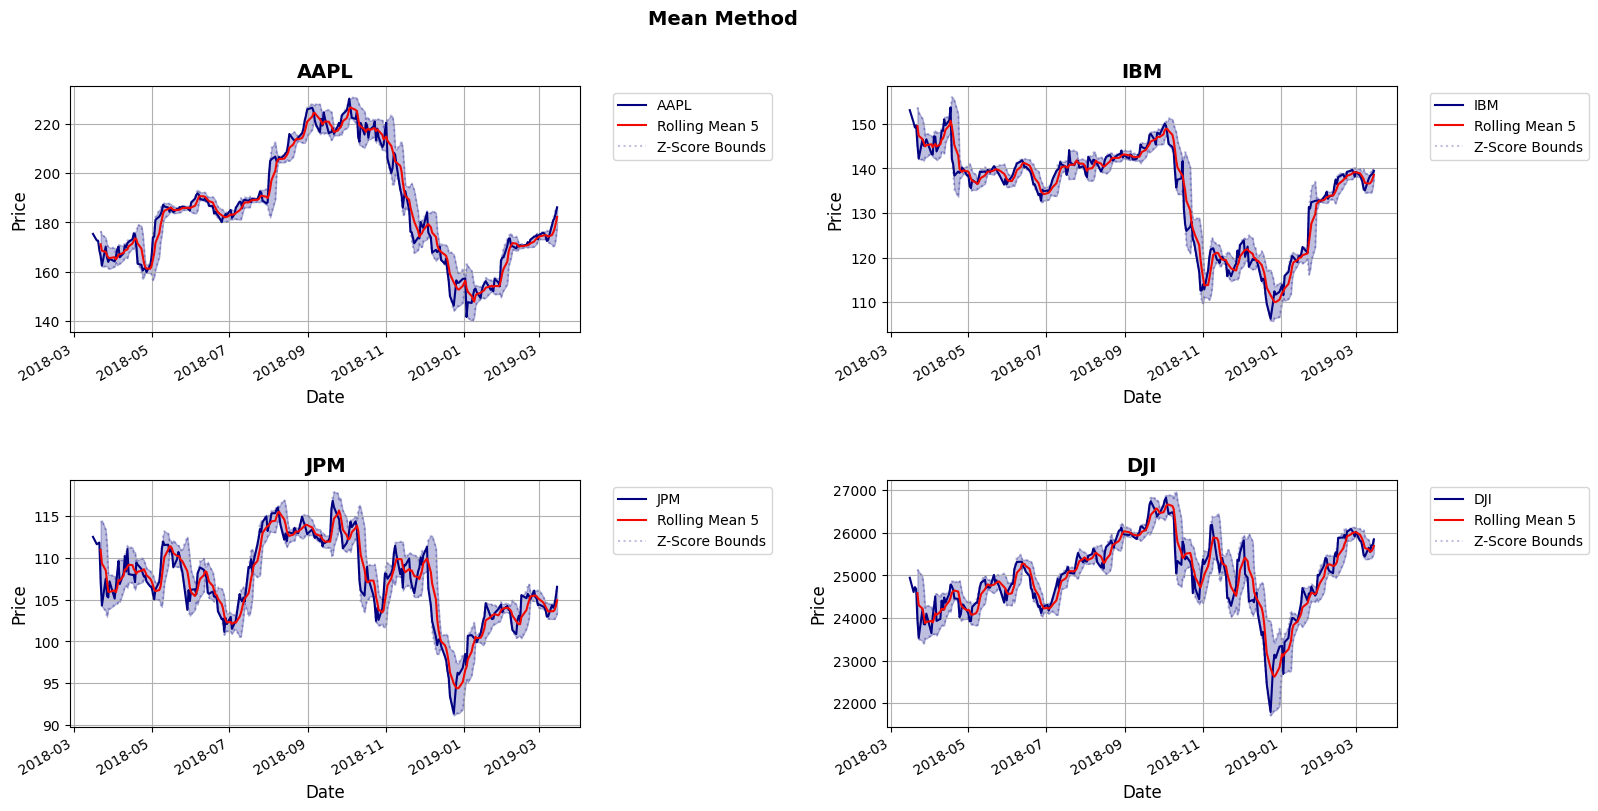

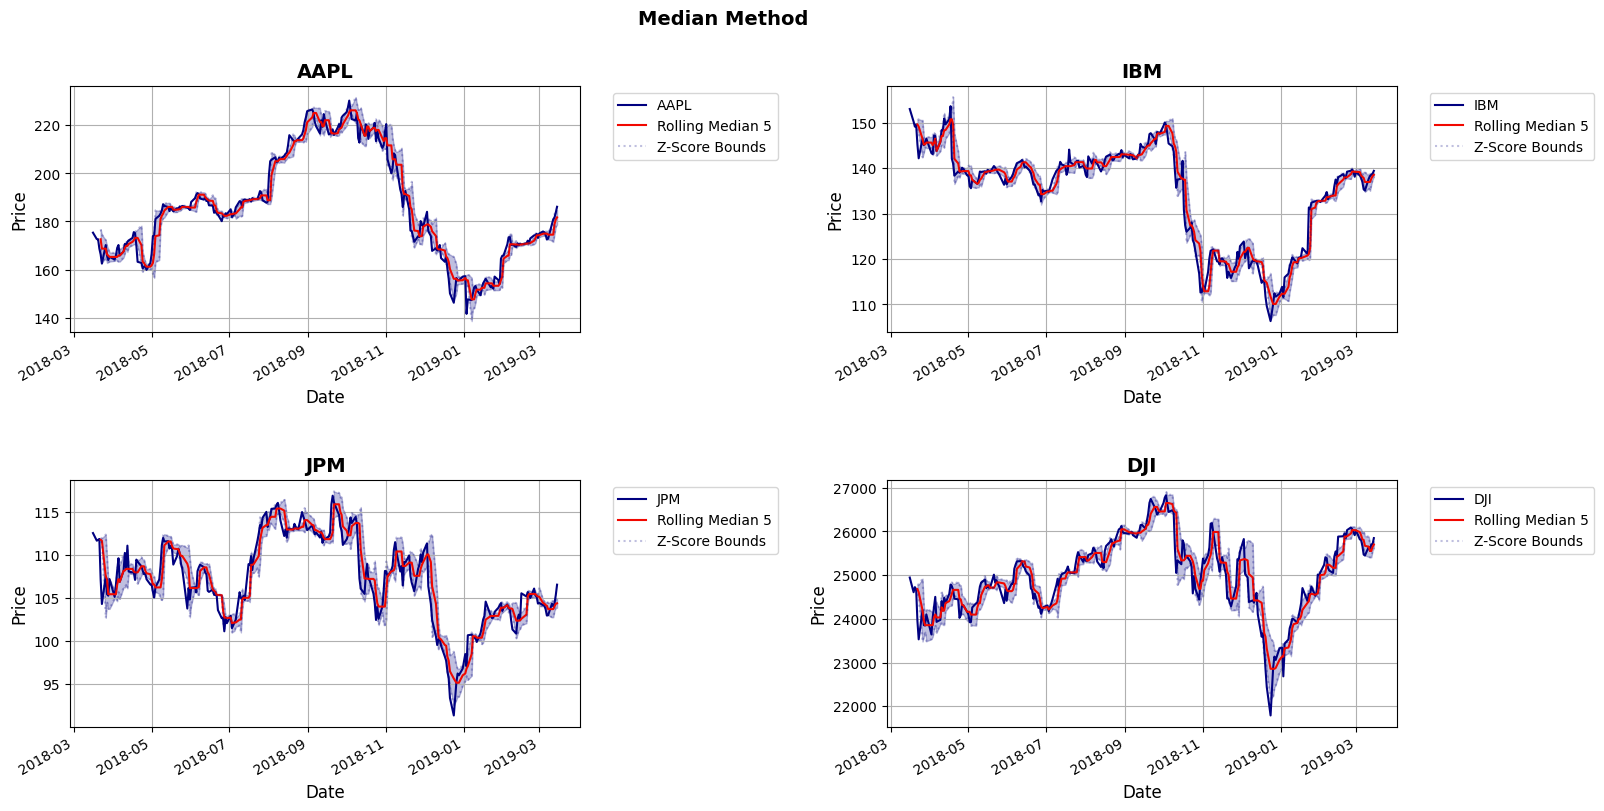

In [80]:
def mad_c1(data):
    return mad(data, c=1)

# Initialise subplots.
fig, axes = configure_subplots(2, 2, fig_size = (14, 7))
fig.suptitle("Mean Method", **fmt_title, y=1.08)

fig2, axes2 = configure_subplots(2, 2, fig_size = (14, 7))
fig2.suptitle("Median Method", **fmt_title, y=1.08)

# Define window size
w = 5
index = 0 # plot index

# Plot mean and median method analysis for all tickers
for ticker in tickers:

    # Copy ticker data.
    td = adj_close_df[ticker].copy()

    # Compute statistics.
    td_rolling_mean = td.rolling(w).mean()
    td_rolling_median = td.rolling(w).median()
    ub_mean = td_rolling_mean + 1.5 * td.rolling(w).std()
    lb_mean = td_rolling_mean - 1.5 * td.rolling(w).std()
    ub_median = td_rolling_median + 1.5 * td.rolling(w).apply(mad_c1, raw = True)
    lb_median = td_rolling_median - 1.5  * td.rolling(w).apply(mad_c1, raw = True)

    # Define axes
    if ticker == tickers[0]:
        ax = axes[0][0]
        ax2 = axes2[0][0]
    if ticker == tickers[1]:
        ax = axes[0][1]
        ax2 = axes2[0][1]
    if ticker == tickers[2]:
        ax = axes[1][0]
        ax2 = axes2[1][0]
    if ticker == tickers[3]:
        ax = axes[1][1]
        ax2 = axes2[1][1]

    # Define legends
    legend1 = [ticker, 'Rolling Mean 5', 'Z-Score Bounds']
    legend2 = [ticker, 'Rolling Median 5', 'Z-Score Bounds']

    # Plot z-score bounds.
    plot_z_bounds(ax, td, td_rolling_mean, ub_mean, lb_mean,
               xlabel = 'Date', ylabel = 'Price', title = ticker, legend = legend1)

    plot_z_bounds(ax2, td, td_rolling_median, ub_median, lb_median,
               xlabel = 'Date', ylabel = 'Price', title = ticker, legend = legend2)


    # Record outliers count.
    outliers.loc[ticker]['Mean Method'] = len(td[td > ub_mean]) + len(td[td < lb_mean])

    outliers.loc[ticker]['Median Method'] = len(td[td > ub_median]) + len(td[td < lb_median])

    outliers_comp.loc[ticker]['Mean Method'] = len(td[td > ub_mean]) + len(td[td < lb_mean])

    outliers_comp.loc[ticker]['Median Method'] = len(td[td > ub_median]) + len(td[td < lb_median])

    index += 1


A comparative analysis of the total outlier counts generated by both methods across all four assets is summarised in the table below.

In [81]:
print('Outliers Count:')
display(outliers)

Outliers Count:


Mean Method Median Method
AAPL          30           103
IBM           31            94
JPM           33           105
DJI           30            97

### 4.1.4 Introduce outlier points for the *adj. close* in the four dates {2018-05-14, 2018-09-14, 2018-12-14, and 2019-01-14}, with a value equal to 1.2 $\times$ the maximum value of the column. Comment on the impact of the outlier points in Part 3.


The first figure below shows the results of applying the mean method to the artificially manipulated dataset, whilst the second figure below shows the results of applying the median method to the same manipulated dataset.

In [82]:
# Define dates to be artificially modified.
dates = ['2018-05-14', '2018-09-14', '2018-12-14', '2019-01-14']

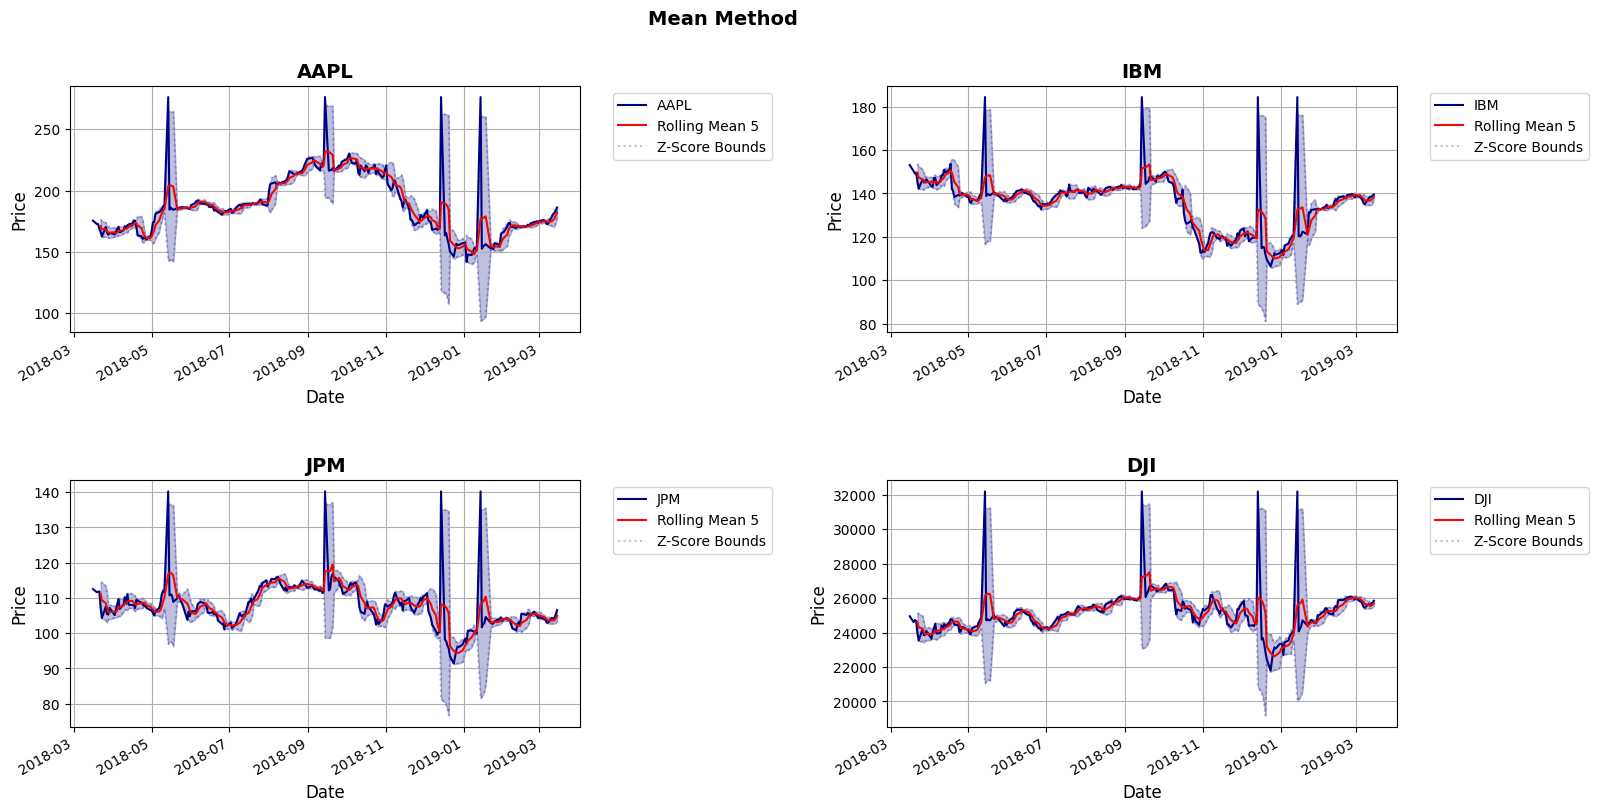

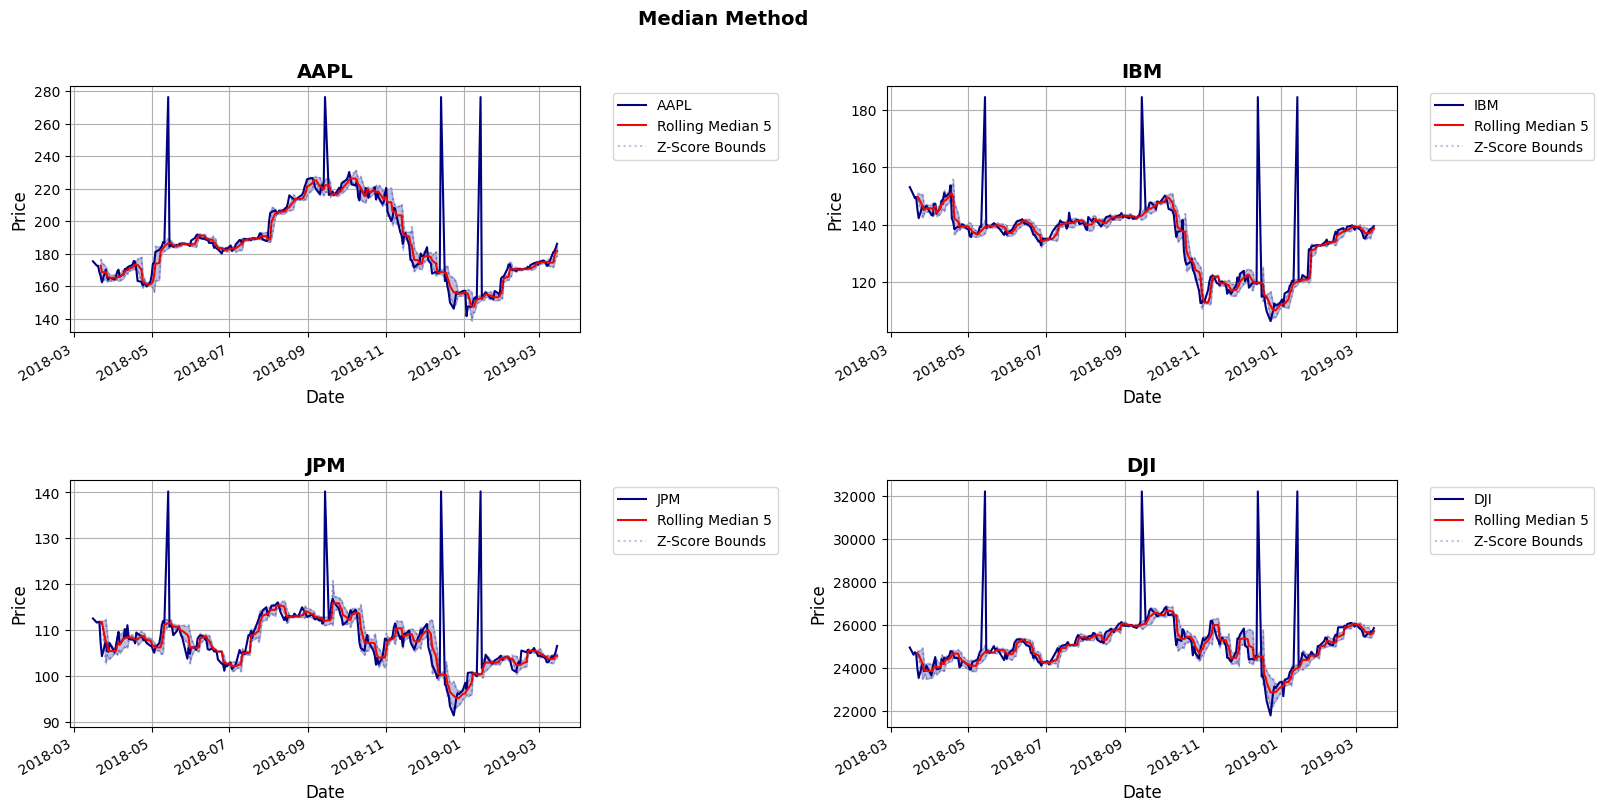

In [83]:
# Initialise subplots.
fig, axes = configure_subplots(2, 2, fig_size = (14, 7))
fig.suptitle("Mean Method", **fmt_title, y=1.08)

fig2, axes2 = configure_subplots(2, 2, fig_size = (14, 7))
fig2.suptitle("Median Method", **fmt_title, y=1.08)

# Define window size
w = 5
index = 0 # plot index

# Plot mean and median method analysis for all tickers
for ticker in tickers:

    # Read data.
    max_price = adj_close_df[ticker].max()
    td = adj_close_df[ticker].copy()

    # Artificially place outliers.
    for date in dates:
        td[date] = 1.2 * max_price

    # Compute statistics.
    td_rolling_mean = td.rolling(w).mean()
    td_rolling_median = td.rolling(w).median()
    ub_mean = td_rolling_mean + 1.5 * td.rolling(w).std()
    lb_mean = td_rolling_mean - 1.5 * td.rolling(w).std()
    ub_median = td_rolling_median + 1.5 * td.rolling(w).apply(mad_c1, raw = True)
    lb_median = td_rolling_median - 1.5 * td.rolling(w).apply(mad_c1, raw = True)

    # Define axes
    if ticker == tickers[0]:
        ax = axes[0][0]
        ax2 = axes2[0][0]
    if ticker == tickers[1]:
        ax = axes[0][1]
        ax2 = axes2[0][1]
    if ticker == tickers[2]:
        ax = axes[1][0]
        ax2 = axes2[1][0]
    if ticker == tickers[3]:
        ax = axes[1][1]
        ax2 = axes2[1][1]

    # Define legends
    legend1 = [ticker, 'Rolling Mean 5', 'Z-Score Bounds']
    legend2 = [ticker, 'Rolling Median 5', 'Z-Score Bounds']

    # Record full outliers count.
    outliers_comp.loc[ticker]['Mean Method With Outliers'] = len(td[td > ub_mean]) + len(td[td < lb_mean])

    outliers_comp.loc[ticker]['Median Method With Outliers'] = len(td[td > ub_median]) + len(td[td < lb_median])

    # Plot z-score bound plots.
    plot_z_bounds(ax, td, td_rolling_mean, ub_mean, lb_mean,
               xlabel = 'Date', ylabel = 'Price', title = ticker, legend = legend1)

    plot_z_bounds(ax2, td, td_rolling_median, ub_median, lb_median,
               xlabel = 'Date', ylabel = 'Price', title = ticker, legend = legend2)

    index += 1

In the first figure above, we see that the z-score bounds derived from the mean method are significantly impacted by the presence of outliers, whilst in the second figure, the z-score bounds derived the the median method remain relatively unaffected. This suggests the greater robustness of the moving median statistic when compared to the moving average statistic. A comprehensive table off all the findings from this section and the previous section are presented below.

In [84]:
print('Outliers Count:')
display(outliers_comp)

Outliers Count:


Mean Method Median Method Mean Method With Outliers  \
AAPL          30           103                        32   
IBM           31            94                        31   
JPM           33           105                        33   
DJI           30            97                        29   

     Median Method With Outliers  
AAPL                         102  
IBM                           93  
JPM                          101  
DJI                           96

### 4.1.5 Generate a box plot for the *adj. close* for each stock, describe the information the plot conveys and elaborate on any other observations you may have.

Boxplots display the distribution of a dataset based on five summary statistics: minimum, first quartile (Q1), median (second quartile, Q2), third quartile (Q3), and maximum. They provide information about the central tendency, spread, and skewness of the data, as well as any potential outliers. The figure below displays box plots for the four assets: AAPL, IBM, JPM and DJI.

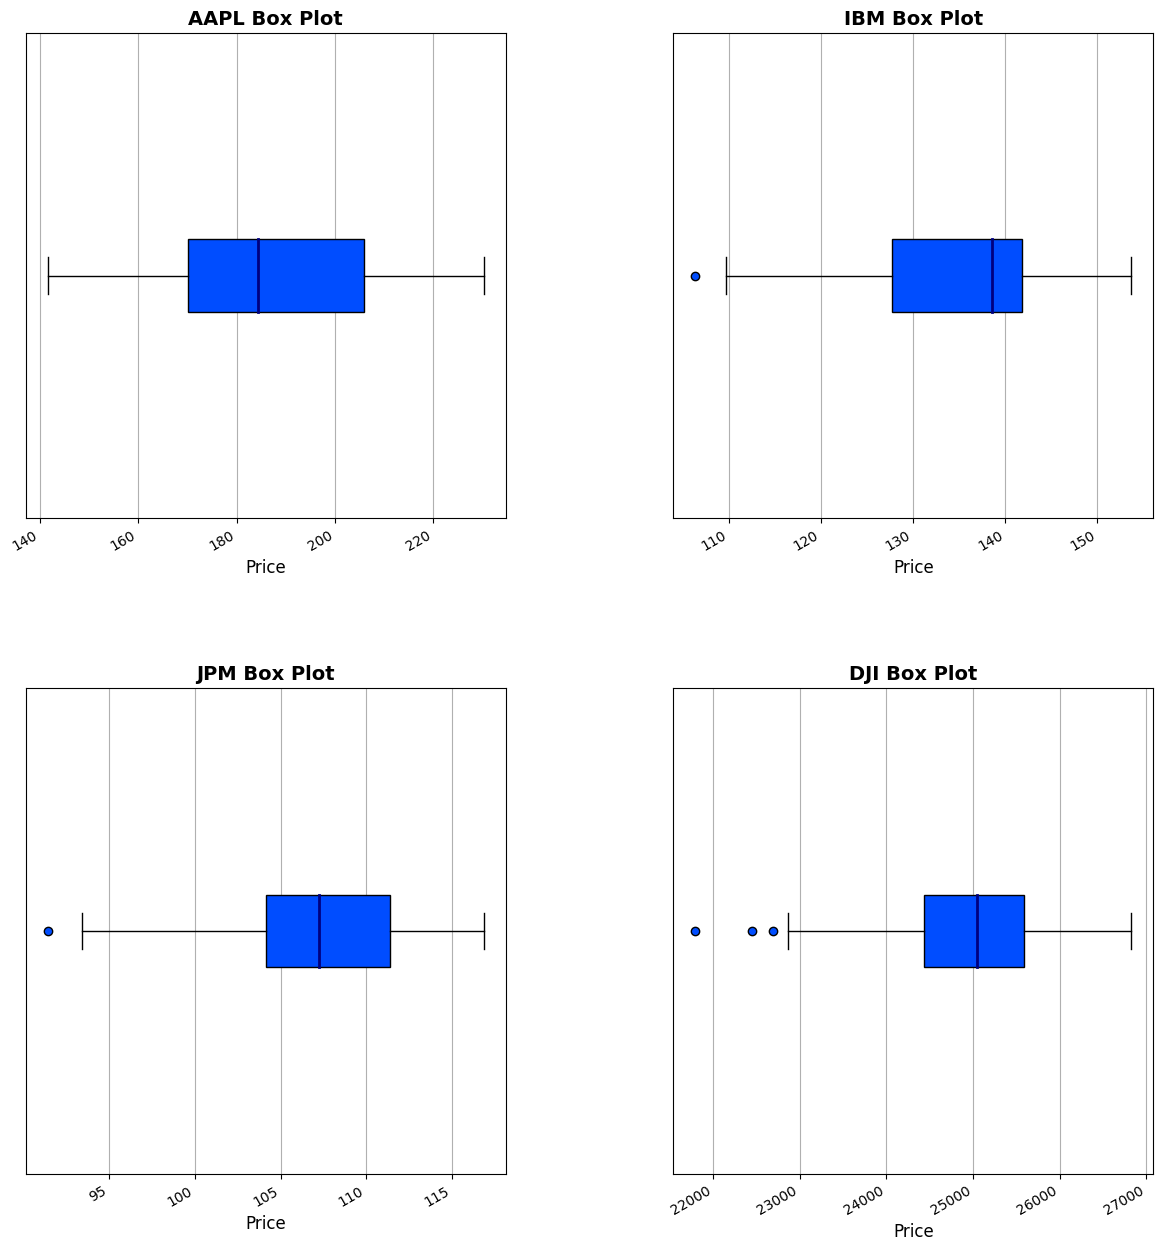

In [85]:
# Initialise variables and subplots.
flierprops = dict(markerfacecolor = CMAP_OBJ(0.2), marker= 'o')
medianprops = dict(color=CMAP_OBJ(0), linewidth = 2)

fig, axes = configure_subplots(2, 2, fig_size = (12, 12), hspace = 0.35, wspace = 0.35)
index = 0

# For each ticker, make box plots.
for ticker in tickers:

    # Define axes
    if ticker == tickers[0]:
        ax = axes[0][0]
    if ticker == tickers[1]:
        ax = axes[0][1]
    if ticker == tickers[2]:
        ax = axes[1][0]
    if ticker == tickers[3]:
        ax = axes[1][1]

    # Plot box plots and format.
    bplot = ax.boxplot(adj_close_df[ticker], vert=False, flierprops = flierprops,
                       patch_artist=True, medianprops = medianprops)
    bplot['boxes'][0].set_facecolor(CMAP_OBJ(0.2))

    ax.set_yticks([])
    ax.grid('on')
    format_plot(ax, "Price", "", ticker + " Box Plot", legend_on = False)

    index += 1

From left to right, each vertical line in a boxplot corresponds to the minimum, Q1, median, Q3 and maximum, respectively. The dots correspond to outliers, which we define as points that are outside 1.5 $\times$ the IQR. It can be seen that IBM has the largest skew magnitude (negative skew), implying that $50\%$ of the prices are much lower than the median. We can also see that AAPL has the largest normalised IQR, implying that the asset is highly volatile. Conversely, DJI has the smallest normalised IQR, implying that the asset is the least volatile.

## 4.2 Robust Estimators

### 4.2.1 Create a Python function for each estimator type that takes a `pandas.Series` as input and returns the estimator value as output.

In [86]:
def compute_median(data):
    '''
        Custom function to compute median.
    '''
    # Sort data
    sorted_data = data.sort_values()

    # Check for empty data
    if sorted_data.empty:
        return None

    # Calculate median
    if len(sorted_data) % 2 == 0:
        lower_median = sorted_data.iloc[len(sorted_data) // 2 - 1]
        upper_median = sorted_data.iloc[len(sorted_data) // 2]
        return (lower_median + upper_median) / 2
    else:
        return sorted_data.iloc[len(sorted_data) // 2]


def compute_iqr(data):
    '''
        Custom function to compute Inter-Quartile range.
    '''
    # Sort data
    sorted_data = data.sort_values()

    # Check for empty data
    if sorted_data.empty:
        return None

    # Calculate quartiles
    quart1 = sorted_data.iloc[len(sorted_data) // 4]
    quart3 = sorted_data.iloc[len(sorted_data) * 3 // 4]

    # Calculate IQR
    return quart3 - quart1

def compute_mad(data):
    '''
        Custom function to compute Median Absolute Deviation.
    '''
    # Compute deviations
    deviations = abs(data - compute_median(data))

    # Calculate MAD
    return compute_median(deviations)


The table below draws comparison between the results obtained by passing series data from the adjusted closing prices dataframe to the builtin functions and to the functions I created.

In [87]:
# Initialise and populate comparison dataframe.
comparison = pd.DataFrame(columns = ['Builtin Median', 'Builtin IQR', 'Builtin MAD', 'compute_median', 'compute_iqr', 'compute_mad'], index = tickers)

for ticker in tickers:
    data = adj_close_df[ticker].copy()
    comparison.loc[ticker] = [data.median(), iqr(data), mad(data, c = 1), compute_median(data), compute_iqr(data), compute_mad(data)]

In [88]:
display(comparison)

Builtin Median  Builtin IQR Builtin MAD compute_median  compute_iqr  \
AAPL     184.351776     35.68544   15.476044     184.351776    35.715225   
IBM      138.566391    14.103938    4.493515     138.566391    14.435798   
JPM      107.219269     7.222442    3.450157     107.219269     7.279045   
DJI    25044.289063  1158.155273  590.720703   25044.289063  1175.480468   

     compute_mad  
AAPL   15.476044  
IBM     4.493515  
JPM     3.450157  
DJI   590.720703

### 4.2.2 Assess and compare the respective relative computational efficiency of the different estimators.

To assess and compare the relative computational efficiency of each of the different estimators in terms of operations, we can analyse the number of operations performed by each function. To preface, $n$ refers to the size of the data.

Let's break down the operations for each function:

1. **compute_median**:
   - Sorting the data: $O(n \cdot \log(n))$
   - Checking for empty data: $O(1)$
   - Calculating the median: $O(1)$
   
For moderately sized datasets ($n < 1000$) the overall complexity is dominated by sorting the data so the complexity of this function can be approximated to $O(n \cdot \log(n))$.

2. **compute_iqr**:
   - Sorting the data: $O(n \cdot \log(n))$
   - Checking for empty data: $O(1)$
   - Calculating quartiles: $O(1)$
   - Calculating the IQR: $O(1)$

Similarly, the overall complexity is dominated by sorting the data so the complexity of this function can be approximated to $O(n \cdot \log(n))$.

3. **compute_mad**:
   - Sorting the data: $O(n \cdot \log(n))$
   - Checking for empty data: $O(1)$
   - Computing deviations: $O(n)$
   - Calculating the MAD following sorting: $O(n \cdot \log(n))$

The overall complexity of this function is dominated by sorting the data and computing deviations, so for moderate $n$, the complexity of this function can be approximated to $2 \cdot O(n \cdot \log(n)) + O(n)$.

Based on the analysis, it seems that the **compute_median** and **compute_iqr** functions have similar computational efficiency, as they both rely on sorting the data, which dominates the overall complexity. The **compute_mad** function has slightly higher complexity due to the additional step of computing deviations.

It is essential to note that the complexity of the functions vary for moderately sized datasets, but as the size of the dataset tends to infinity, the complexity of all the functions tend to $O(n \cdot \log(n))$

### 4.2.3 Assess and compare the breakdown points associated with the different estimators.

The breakdown point of an estimator is a measure of its robustness against outliers in a dataset. It refers to the proportion of data points that can be contaminated or corrupted by outliers before the estimator's performance becomes arbitrarily bad or misleading. In other words, the breakdown point indicates the threshold at which the estimator's accuracy or reliability starts to deteriorate rapidly due to the presence of outliers. A higher breakdown point implies greater robustness, as the estimator can withstand a larger proportion of contaminated data without significant degradation in performance.

The breakdown point of the median estimator is at $50\%$ as $n$ tends to $\infty$. This means that up to half of the data can be contaminated (with outliers) without affecting the median value. Beyond this point, the median will be influenced by outliers.

Similarly, the breakdown point of the MAD estimator is also at $50\%$ as $n$ tends to $\infty$, since it computes the median and then finds the median of absolute deviation. Therefore, only a maximum of half the data can be outliers, without influencing the median.

Distinctively, the breakdown point of the IQR estimator is $25\%$ as $n$ tends to $\infty$ because the array is split into four parts instead of two so up to 25% of the data can be contaminated (with outliers) without affecting the IQR value. Beyond this point, the IQR will be influenced by outliers.

Overall, the median estimator and MAD estimator are equally robust, having a breakdown point of $50\%$; however, the IQR estimator has a breakdown point of $25\$, meaning it is less robust when compared to the other two estimators.

## 4.3 Robust and OLS Regression

In this section, we will compare and contrast the performance of the Ordinary Least Square (OLS) regression method with the Huber regression method by regressing the returns of each stock against the DJI index.

In [89]:
# Retrieve returns data.
returns = pd.DataFrame(columns = tickers)

for ticker in tickers:
    returns[ticker] = all_dfs[ticker]['Returns'].copy().dropna()

# Initialise joint parameters dataframe.
params = pd.DataFrame(columns = tickers, index = ['OLS ' + greek_chars[':alpha'], 'OLS ' + greek_chars[':beta'], 'Huber ' + greek_chars[':alpha'], 'Huber ' + greek_chars[':beta']])

# Initialise OLS parameters dataframe
ols_params = pd.DataFrame(columns = tickers, index = ['OLS ' + greek_chars[':alpha'], 'OLS ' + greek_chars[':beta']])

# Initialise Huber parameters dataframe
huber_params = pd.DataFrame(columns = tickers, index = ['Huber ' + greek_chars[':alpha'], 'Huber ' + greek_chars[':beta']])

### 4.3.1 Regress each stock's 1-day returns against the 1-day returns of DJI using Ordinary Least Squares (OLS) regression.

The regression problem is defined as:

\begin{equation}
    \mathbf{r} = \mathbf{X}\mathbf{b} + \mathbf{e}
\end{equation}

Here, $\mathbf{r}$ denotes the returns vector for the stock, $\mathbf{X}$ is the matrix comprising a column of ones and a column of DJI returns, and $\mathbf{e}$ denotes the error vector. The OLS method minimises the squared error $ ||e||^2 = ||r - Xb||^2 $, with the solution $ \hat{b} = (X^TX)^{-1}X^Tr $.

The figure below depicts the results of the OLS regression.


<ipython-input-90-8036970552d9>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  params[ticker]['OLS ' +  greek_chars[':alpha']] = float(ols_regr_model.intercept_)
<ipython-input-90-8036970552d9>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  params[ticker]['OLS ' +  greek_chars[':beta']] = float(ols_regr_model.coef_)
<ipython-input-90-8036970552d9>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ols_params[ticker]['OLS ' +  greek_chars[':alpha']] = float(ols

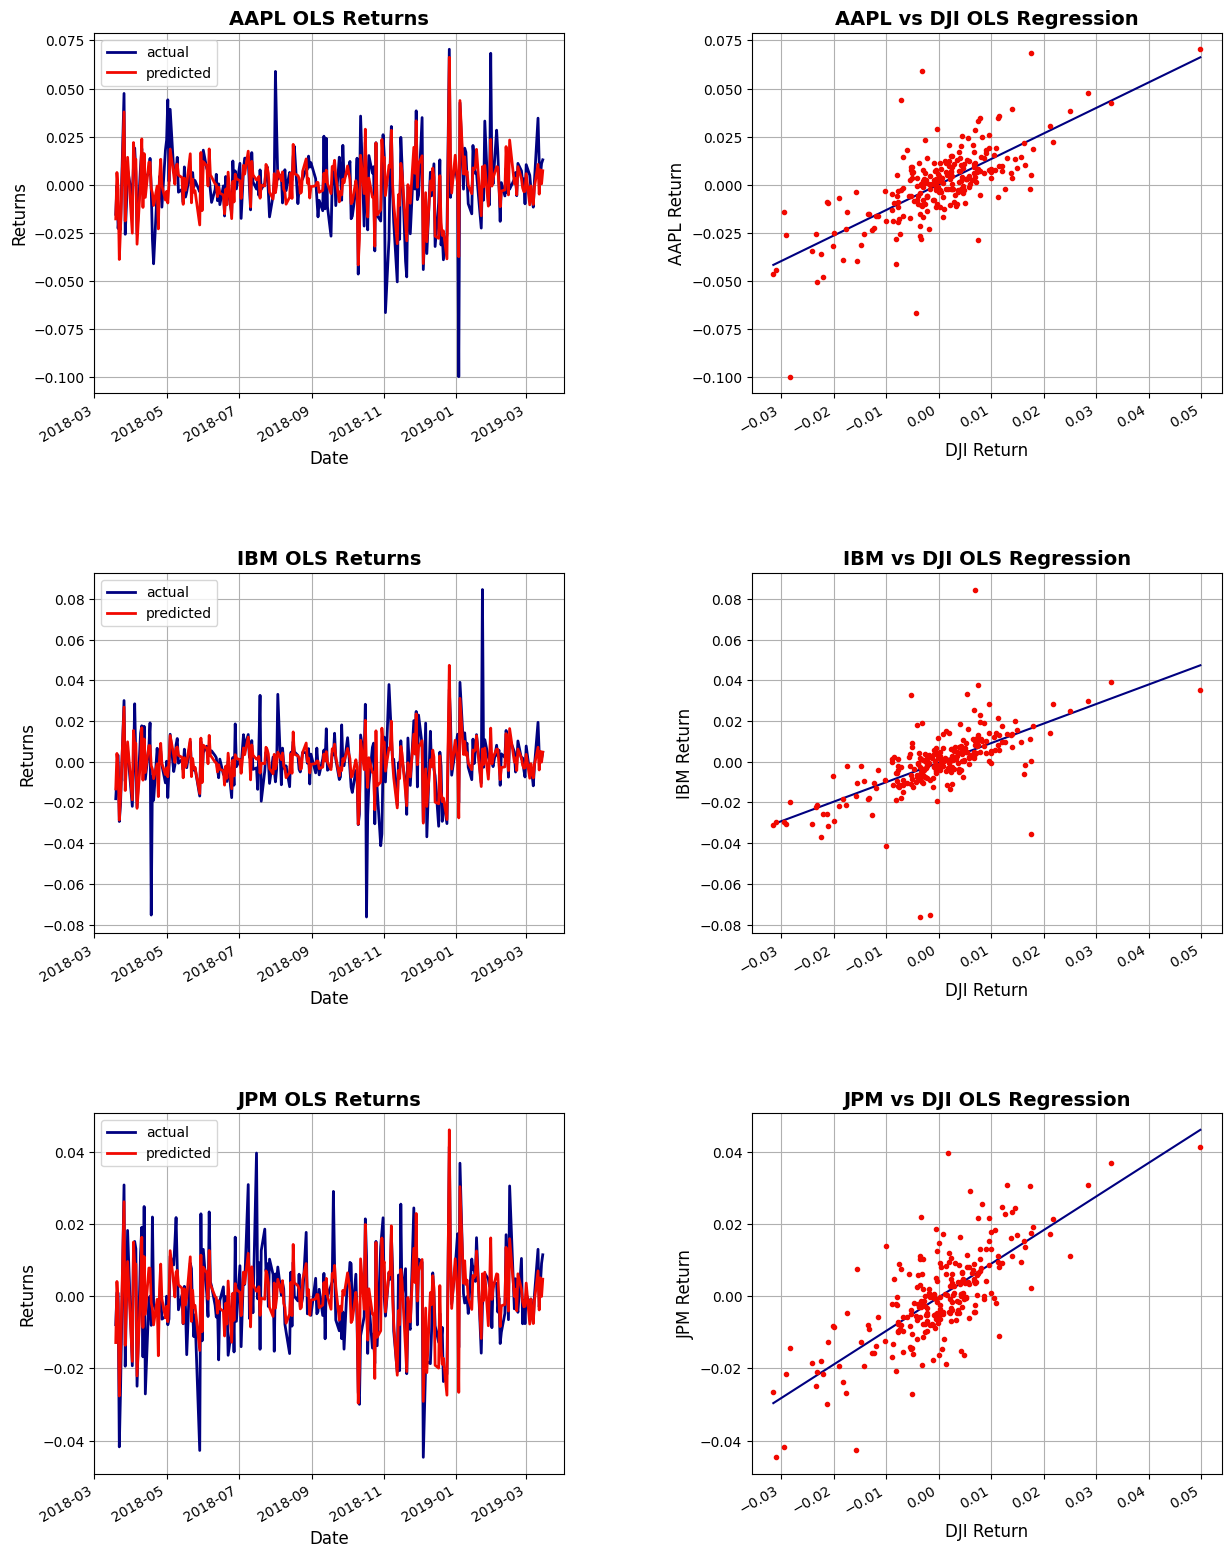

In [90]:
index = 0

# Define regression model (OLS)
ols_regr_model = linear_model.LinearRegression()

# Initialise subplot.
fig, axes = configure_subplots(3, 2, fig_size = (12, 15), wspace = 0.4, hspace = 0.5)

# Plot predictions and regression fit for each stock ticker.
for ticker in tickers:

    x = returns['DJI'].copy().values.reshape(-1, 1)
    linspace_x = np.linspace(x.min(), x.max())

    # Get stock returns data
    y = returns[ticker].copy().values.reshape(-1, 1)

    # Fit OLS model
    ols_regr_model.fit(x, y)

    # Log parameters.
    params[ticker]['OLS ' +  greek_chars[':alpha']] = float(ols_regr_model.intercept_)
    params[ticker]['OLS ' +  greek_chars[':beta']] = float(ols_regr_model.coef_)
    ols_params[ticker]['OLS ' +  greek_chars[':alpha']] = float(ols_regr_model.intercept_)
    ols_params[ticker]['OLS ' +  greek_chars[':beta']] = float(ols_regr_model.coef_)

    if ticker != 'DJI':
        # Define axes.
        ax0 = axes[index][0]
        ax1 = axes[index][1]

        # Compute predictions.
        predictions = ols_regr_model.predict(x)

        # Plot actual returns and predicted returns.
        visualise_data(ax0, returns[ticker].index, var2 = y, label = 'actual')
        visualise_data(ax0, returns[ticker].index, var2 = predictions, label = 'predicted', color = CMAP_OBJ(0.9))
        format_plot(ax0, 'Date', 'Returns', ticker + ' OLS Returns')

        # Fit model and retrieve coefficients.
        model = ols_regr_model.fit(x, y.ravel())
        coef = model.coef_ * linspace_x + model.intercept_

        # Plot regression fit.
        ax1.plot(linspace_x, coef, color = CMAP_OBJ(0))
        ax1.plot(x, y, '.', color = CMAP_OBJ(0.9))
        format_plot(ax1, 'DJI Return', ticker + ' Return',
                       ticker + ' vs DJI OLS Regression', legend_on = False)
        index += 1

### 4.3.2 Regress the 1-day returns for each stock against the 1-day returns of DJI using Huber Regression.

Huber regression offers a robust alternative to the traditional OLS method, which is highly sensitive to outliers due to its minimisation of squared errors. While OLS assumes a constant underlying distribution with constant variance, it struggles under heteroscedasticity or in the presence of outliers. Huber regression, on the other hand, minimises the squared error for deviations within a certain threshold $\epsilon$ and switches to minimising absolute error for deviations beyond that threshold. By making the error quadratic for small values and linear for larger values, Huber regression effectively mitigates the influence of outliers on parameter estimation. Essentially, by tuning $\epsilon$, it is possible to control the point at which a datapoint is considered an outlier.

The figure below shows the results of this regression, along with a table that enables a comparison to be drawn from the parameters derived via OLS and the parameters derived using Huber.

<ipython-input-91-85a2702a0cd3>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  params[ticker]['Huber ' + greek_chars[':beta']] = float(huber_regr_model.coef_)
<ipython-input-91-85a2702a0cd3>:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  huber_params[ticker]['Huber ' + greek_chars[':beta']] = float(huber_regr_model.coef_)
<ipython-input-91-85a2702a0cd3>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  params[ticker]['Huber ' + greek_chars[':beta']] = float(h

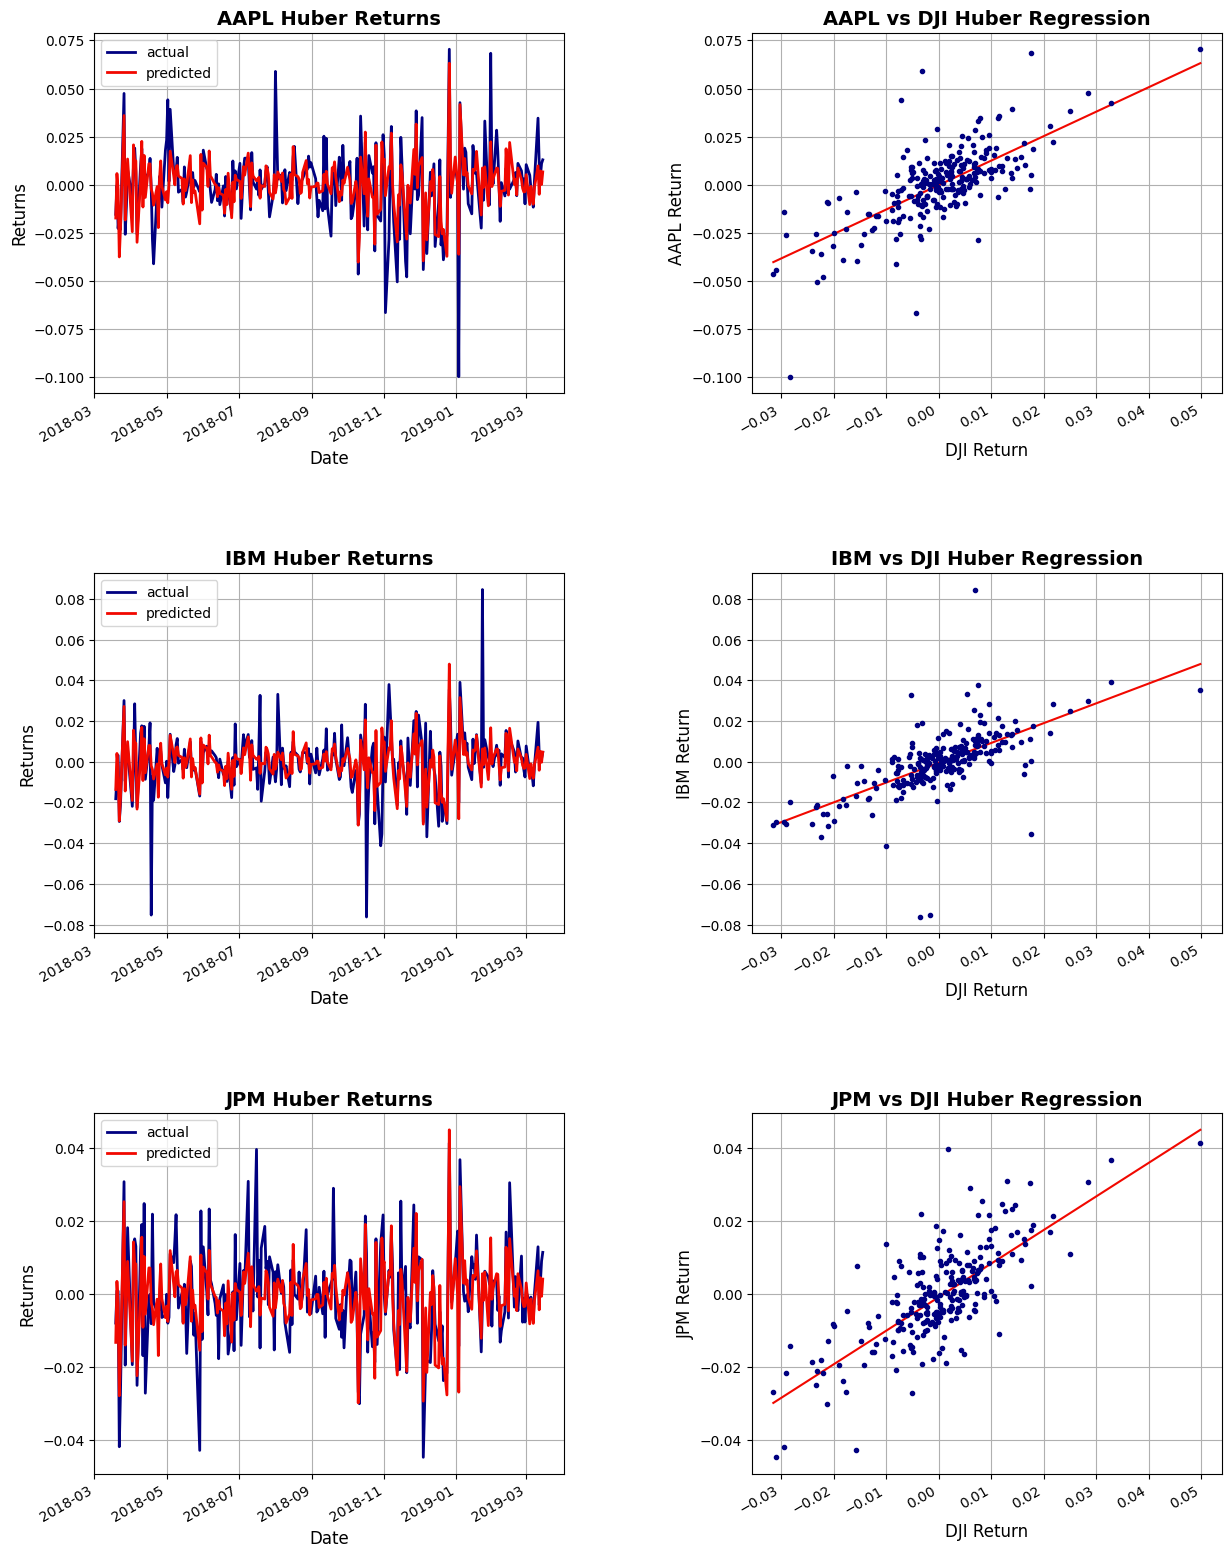

In [91]:
index = 0

# Define regression model (Huber)
huber_regr_model = linear_model.HuberRegressor()

# Initialise subplot.
fig, axes = configure_subplots(3, 2, fig_size = (12, 15), wspace = 0.4, hspace = 0.5)

# Plot predictions and regression fit for each stock ticker.
for ticker in tickers:

    x = returns['DJI'].copy().values.reshape(-1,1)
    linspace_x = np.linspace(x.min(), x.max())

    # Get stock return data.
    y = returns[ticker].copy().values.reshape(-1)

    # Fit regression model
    huber_regr_model.fit(x, y)

    # Log parameters.
    params[ticker]['Huber ' + greek_chars[':alpha']] = float(huber_regr_model.intercept_)
    params[ticker]['Huber ' + greek_chars[':beta']] = float(huber_regr_model.coef_)
    huber_params[ticker]['Huber ' + greek_chars[':alpha']] = float(huber_regr_model.intercept_)
    huber_params[ticker]['Huber ' + greek_chars[':beta']] = float(huber_regr_model.coef_)

    if ticker != 'DJI':
        # Define axes.
        ax0 = axes[index][0]
        ax1 = axes[index][1]

        # Compute predictions.
        predictions = huber_regr_model.predict(x)

        # Plot actual returns and predicted returns.
        visualise_data(ax0, returns[ticker].index, var2 = y, label = 'actual')
        visualise_data(ax0, returns[ticker].index, var2 = predictions, label = 'predicted', color = CMAP_OBJ(0.9))
        format_plot(ax0, 'Date', 'Returns', ticker + ' Huber Returns')

        # Fit model and retrieve coefficients.
        model = huber_regr_model.fit(x, y.ravel())
        coef = model.coef_ * linspace_x + model.intercept_

        # Plot regression fit.
        ax1.plot(linspace_x, coef, color = CMAP_OBJ(0.9))
        ax1.plot(x, y, '.', color = CMAP_OBJ(0))

        format_plot(ax1, 'DJI Return', ticker + ' Return',
                       ticker + ' vs DJI Huber Regression', legend_on = False)
        index += 1

In [92]:
display(params)

AAPL       IBM       JPM  DJI
OLS α    0.000165 -0.000441 -0.000316  0.0
OLS β     1.32558  0.960092  0.931408  1.0
Huber α  -0.00013 -0.000509 -0.000801  0.0
Huber β  1.270212  0.973562  0.919662  1.0

### 4.3.3. Assess and compare the results obtained using both regression methods and the impact of outliers in both cases.

In this section, we will evaluate and compare the robustness of both regression methods. From the table above, it is clear to see that fairly similar estimates of the coefficients are produced by both methods. In order to evaluate the robustness of the methods in the presence of outliers, a similar approach to Section 4.4.1 can be taken, where outliers can be artificially induced with values equal to $1.2 \times$ the maximum value, and the mean absolute percentage change of the parameter values can be recorded to make a statement on the robustness of each regression method i.e. the method with the lower mean absolute percentage change is more robust.

In [93]:
# Define dates to be artificially modified.
dates = ['2018-05-14', '2018-09-14', '2018-12-14', '2019-01-14']

# Artificially manipulate data.
for ticker in tickers:
    max_price = returns[ticker].max()
    for date in dates:
        returns[ticker][date] = 1.2 * max_price

# Initialise joint outliers parameters dataframe.
outliers_parameters = pd.DataFrame(columns = tickers, index = ['OLS with Outliers ' + greek_chars[':alpha'], 'OLS with Outliers ' + greek_chars[':beta'], 'Huber with Outliers ' + greek_chars[':alpha'], 'Huber with Outliers ' + greek_chars[':beta']])

# Initialise OLS outliers parameters dataframe.
ols_outliers_parameters = pd.DataFrame(columns = tickers, index = ['OLS with Outliers ' + greek_chars[':alpha'], 'OLS with Outliers ' + greek_chars[':beta']])

# Initialise Huber outliers parameters dataframe.
huber_outliers_parameters = pd.DataFrame(columns = tickers, index = ['Huber with Outliers ' + greek_chars[':alpha'], 'Huber with Outliers ' + greek_chars[':beta']])

In [94]:
# OLS regression
ols_regr_model = linear_model.LinearRegression()

for ticker in tickers:
    x = returns['DJI'].copy().values.reshape(-1,1)
    y = returns[ticker].copy().values.reshape(-1,1)
    ols_regr_model.fit(x, y)
    outliers_parameters[ticker]['OLS with Outliers ' +  greek_chars[':alpha']] = float(ols_regr_model.intercept_)
    outliers_parameters[ticker]['OLS with Outliers ' +  greek_chars[':beta']] = float(ols_regr_model.coef_)
    ols_outliers_parameters[ticker]['OLS with Outliers ' +  greek_chars[':alpha']] = float(ols_regr_model.intercept_)
    ols_outliers_parameters[ticker]['OLS with Outliers ' +  greek_chars[':beta']] = float(ols_regr_model.coef_)

# Huber regression
huber_regr_model = linear_model.HuberRegressor()

for ticker in tickers:
    x = returns['DJI'].copy().values.reshape(-1,1)
    y = returns[ticker].copy().values.reshape(-1)
    huber_regr_model.fit(x, y)
    outliers_parameters[ticker]['Huber with Outliers ' +  greek_chars[':alpha']] = float(huber_regr_model.intercept_)
    outliers_parameters[ticker]['Huber with Outliers ' +  greek_chars[':beta']] = float(huber_regr_model.coef_)
    huber_outliers_parameters[ticker]['Huber with Outliers ' +  greek_chars[':alpha']] = float(huber_regr_model.intercept_)
    huber_outliers_parameters[ticker]['Huber with Outliers ' +  greek_chars[':beta']] = float(huber_regr_model.coef_)

<ipython-input-94-6a1bdcc05493>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  outliers_parameters[ticker]['OLS with Outliers ' +  greek_chars[':alpha']] = float(ols_regr_model.intercept_)
<ipython-input-94-6a1bdcc05493>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  outliers_parameters[ticker]['OLS with Outliers ' +  greek_chars[':beta']] = float(ols_regr_model.coef_)
<ipython-input-94-6a1bdcc05493>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ols_outlier

In [95]:
params

AAPL       IBM       JPM  DJI
OLS α    0.000165 -0.000441 -0.000316  0.0
OLS β     1.32558  0.960092  0.931408  1.0
Huber α  -0.00013 -0.000509 -0.000801  0.0
Huber β  1.270212  0.973562  0.919662  1.0

In [96]:
outliers_parameters

AAPL       IBM       JPM  DJI
OLS with Outliers α     0.00035 -0.000063 -0.000467  0.0
OLS with Outliers β    1.350465   1.22204  0.906468  1.0
Huber with Outliers α  0.000122 -0.000339 -0.000933  0.0
Huber with Outliers β  1.330773  1.066643  0.890359  1.0

Subsequent analysis indicated significant alterations in the OLS method's parameters, with a substantial 81% deviation from previous values. In contrast, the Huber method exhibited a more modest change of 54%, underscoring its empirical robustness in the face of outliers.

## 4.4 Robust Trading Strategies

The *Moving Average Crossover* is a simple trading strategy based on the following rules:

<ol type="a">
    <li>Buy X shares of a stock when its 20-day MA > 50-day MA.</li>
    <li>Sell X shares of the stock when its 20-day MA < 50-day MA.</li>
</ol>

In this section, robust variations of the *Moving Average Crossover* strategy will be implemented.

### 4.4.1 For each stock, plot the *adj. close*, the 20-day and 50-day MAs, and highlight the crossover points and the regions to buy or sell. In a separate figure, repeat these steps using the *adj. close* values corrupted with outliers for each stock.

The figure below shows plots of the *adj. close* prices, the 20-day and 50-day Moving Averages, with the crossover points, indicating when to buy and sell indicated by green and red dashed lines, respectively, for each and every asset.

In [97]:
# Set seed for reproducibility.
np.random.seed(0)

# create adj. close dataframe for all the assets
adj_close_df = pd.DataFrame(columns = tickers)
for ticker in tickers:
    adj_close_df[ticker] = all_dfs[ticker]['Adj Close'].copy()

# create adj. close dataframe for all the assets but with random outliers.
adj_close_df_with_outliers = pd.DataFrame(columns = tickers)
for ticker in tickers:
    data = adj_close_df[ticker].copy()
    delta = data.max() - data.mean()

    for index in range(0, 250, 25):
        data[index] += float([-2,2][np.random.randint(0, 2)] * delta)
    adj_close_df_with_outliers[ticker] = data

In [99]:
# Similarity between strategies.
strategic_similarity = pd.DataFrame(columns = ['MA Strategic Similarity w/out Outliers',
                                         'MM Strategic Similarity w/out Outliers'], index = tickers
                              )

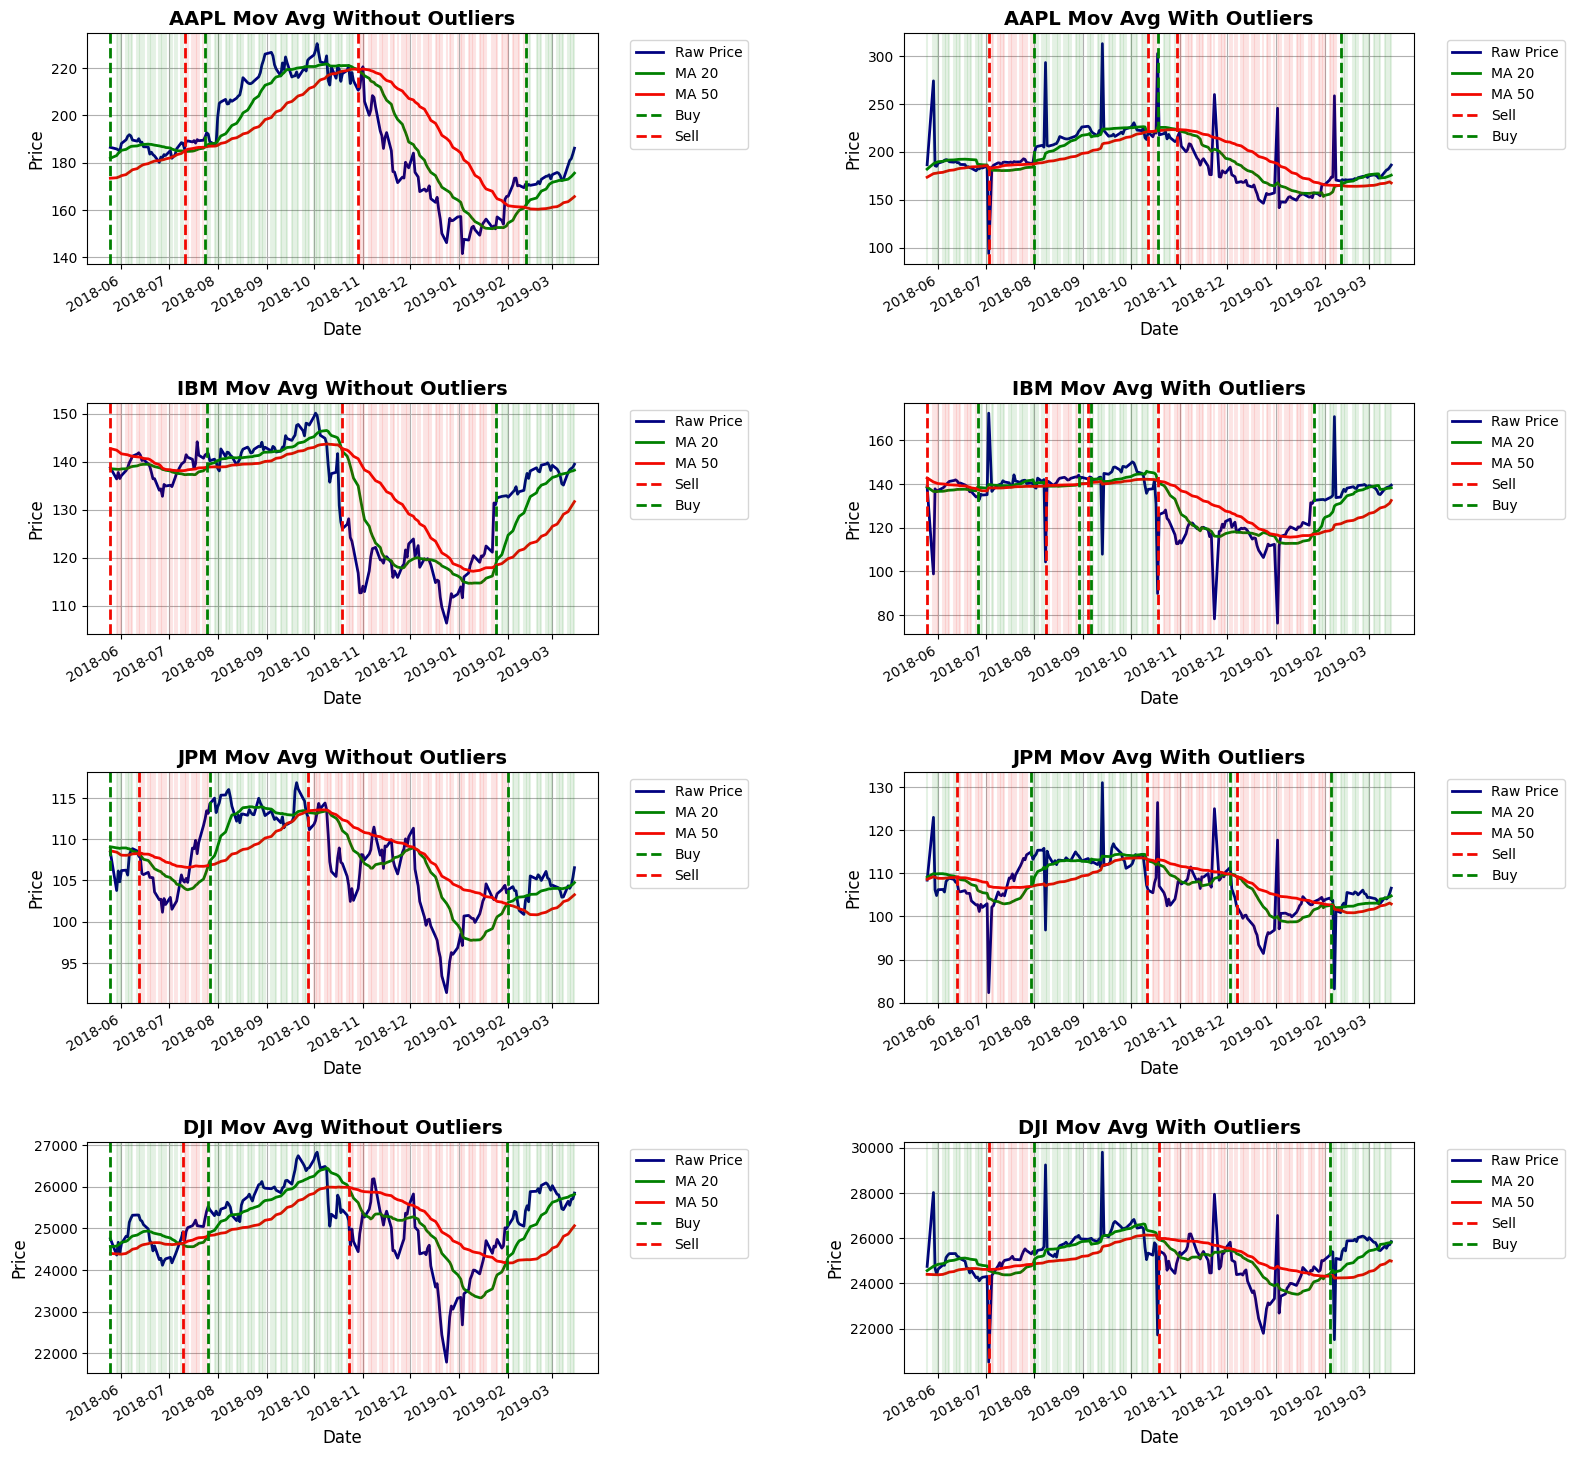

In [100]:
# Initialise subplot and row index.
fig, axes = configure_subplots(4, 2, fig_size = (14, 17))
row = 0

for ticker in tickers:

    # Initialise variables.
    ma_buy_decisions = []
    outliers_ma_buy_decisions = []
    col = 0
    previous_decision = 0

    # For both data with/out outliers.
    for adj_close_data in [adj_close_df, adj_close_df_with_outliers]:

        # Priming
        ax = axes[row][col]
        data = adj_close_data[ticker].dropna()

        # Compute moving average crossover.
        ma_20 = data.rolling(20).mean()
        ma_50 = data.rolling(50).mean()
        ma_buy_sell = np.sign((ma_20 - ma_50).dropna())

        # Plot time-series
        start_index = ma_buy_sell.index[0]
        visualise_data(ax, data[start_index:], label = "Raw Price") # Plot raw time series in black
        visualise_data(ax, ma_20[start_index:], color = 'g', label = "MA 20") # Plot MA20 in green
        visualise_data(ax, ma_50[start_index:], color = CMAP_OBJ(0.9), label = "MA 50") # Plot MA50 in red

        # Highlight regions to buy and sell (green and red, respectively)
        buy_action = 'Buy'
        sell_action = 'Sell'
        for buy_index in ma_buy_sell.index:

            # Plot buying/selling decision daily as green or red vertical lines.
            current_decision = ma_buy_sell[buy_index]

            ## Green lines - BUY.
            if current_decision == 1:
                if previous_decision != current_decision:
                    ax.axvline(x = buy_index, alpha = 1, color = 'g', linewidth = 2, linestyle = '--', label = buy_action)
                    buy_action = ''
                else :
                    ax.axvline(x = buy_index, alpha = 0.1, color = 'g')

            ## Red lines - SELL.
            if ma_buy_sell[buy_index] == -1:
                if previous_decision != current_decision:
                    ax.axvline(x = buy_index, alpha = 1, color = CMAP_OBJ(0.9), linewidth = 2, linestyle = '--', label = sell_action)
                    sell_action = ''
                else:
                    ax.axvline(x = buy_index, alpha = 0.1, color = CMAP_OBJ(0.9))
            previous_decision = current_decision

        if col == 0:
            ma_buy_decisions = ma_buy_sell
        else:
            outliers_ma_buy_decisions = ma_buy_sell

        # Define title.
        if col == 0:
            title = ticker + " Mov Avg Without Outliers"
        else:
            title = ticker + " Mov Avg With Outliers"

        # Format axes.
        format_plot(ax, "Date", "Price", title, legend_out=True)
        col += 1

    # Log strategic similarity between with and without outliers.
    strategic_similarity.loc[ticker]['MA Strategic Similarity w/out Outliers'] = \
         len(outliers_ma_buy_decisions[outliers_ma_buy_decisions == ma_buy_decisions]) / \
         len(ma_buy_decisions) * 100
    row += 1

As seen in previous sections, the crossover regions have been drastically impacted by the introduction of outliers. The table in Section 4.4.2 presents a measure of strategic similarity between corrupted and uncorrupted datasets using the MA and MM methodologies. The results allow us to make a statement on which method is more robust.

### 4.4.2. Instead of using the rolling mean (MA), use the rolling median and repeat the steps in Part 1. Comment on the difference between the trading signals generated when using the mean vs the median for the data points corrupted with synthetic outliers.


In this section, instead of using the rolling mean (MA), the rolling median (MM) was used. The figure below presents the raw price data, the 20-day and 50-day Moving Averages, along with the crossover points, indicating when to buy and sell indicated by green and red dashed lines, respectively, for each and every asset.

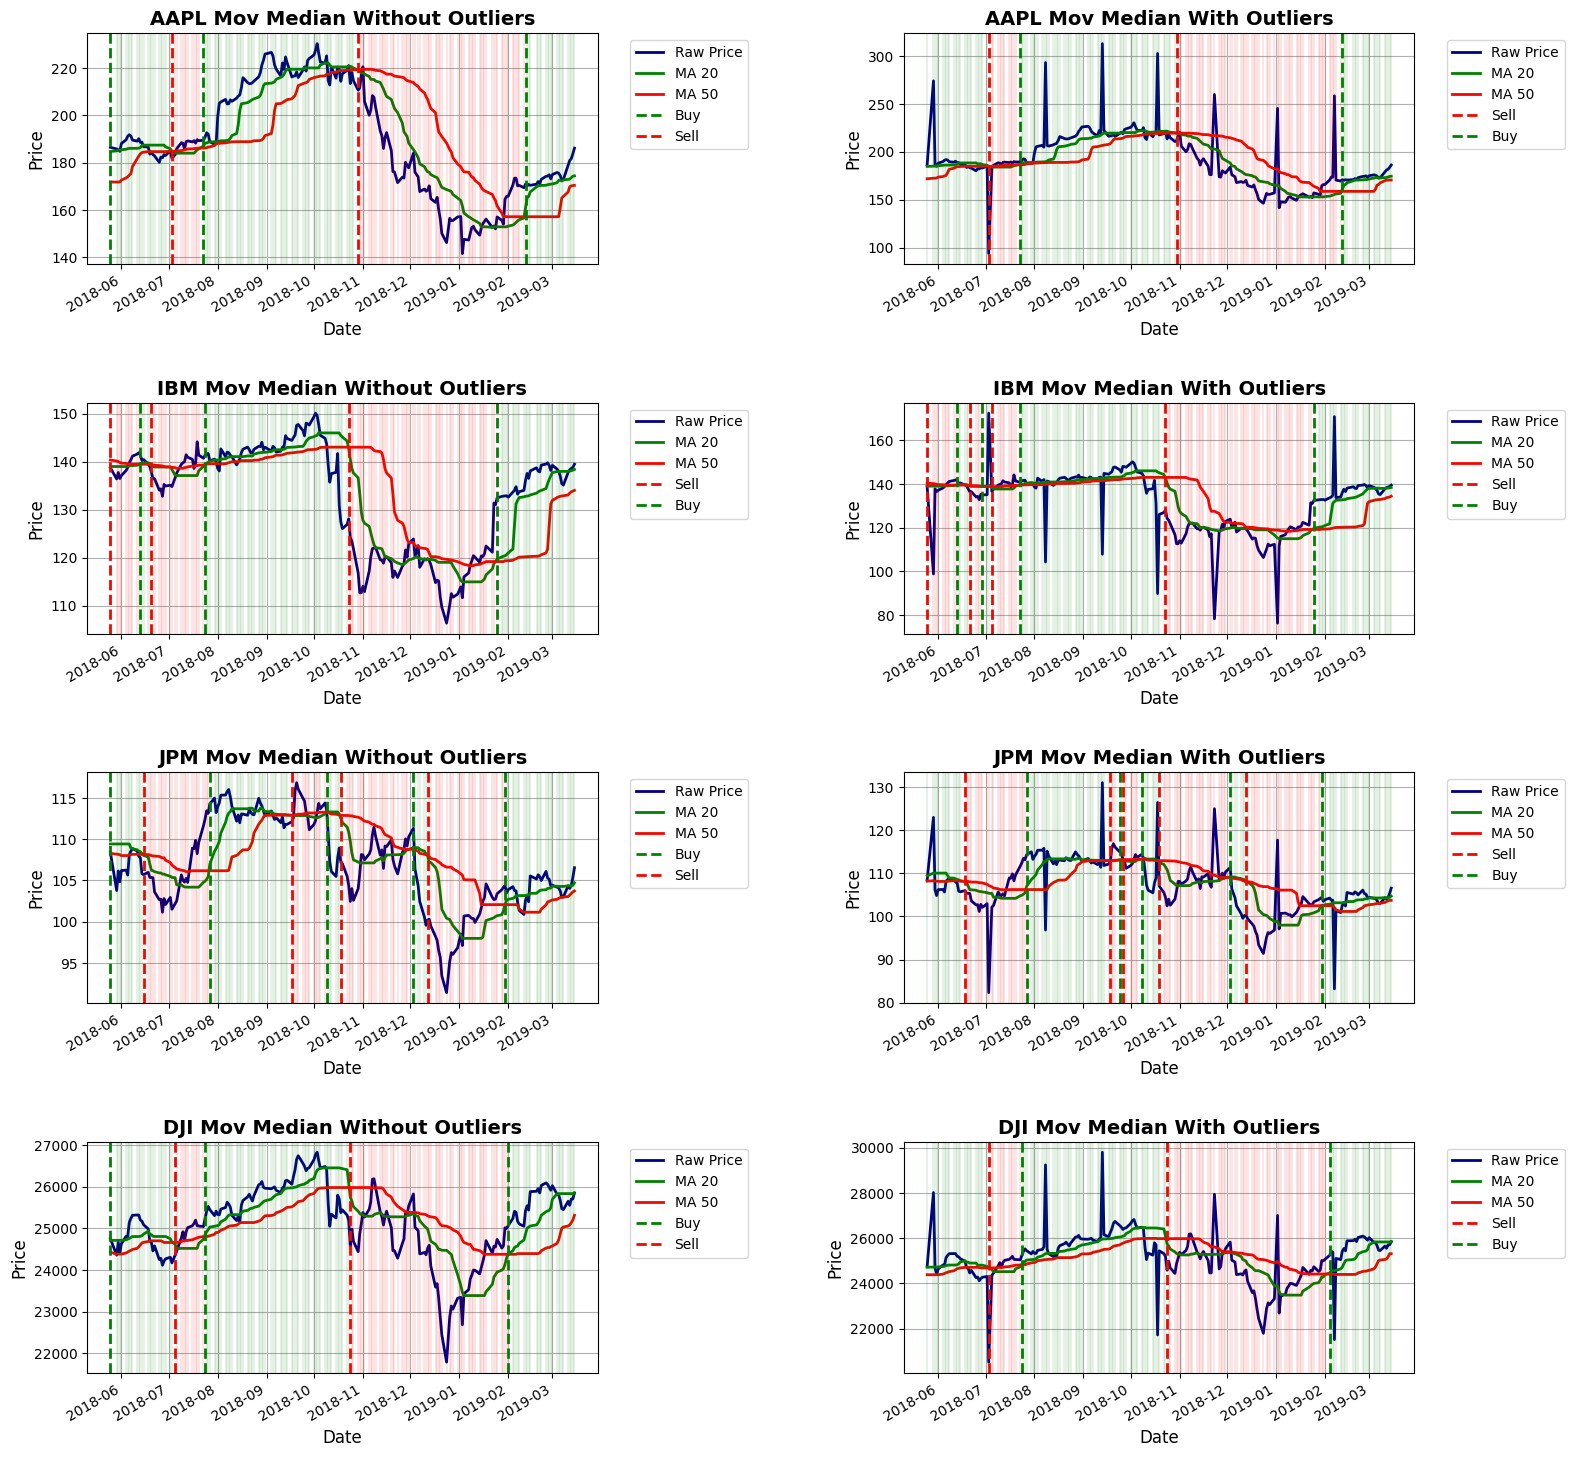

In [101]:
# Initialise subplot.
fig, axes = configure_subplots(4, 2, fig_size = (14, 17))
row = 0

for ticker in tickers:

    # Initialise variables.
    mm_buy_decisions = []
    outliers_mm_buy_decisions = []
    col = 0
    previous_decision = 0

    # For both data with/without outliers.
    for adj_close_data in [adj_close_df, adj_close_df_with_outliers]:

        # Priming
        ax = axes[row][col]
        data = adj_close_data[ticker].dropna()

        # Compute moving median crossover
        mm_20 = data.rolling(20).median()
        mm_50 = data.rolling(50).median()
        mm_buy = np.sign((mm_20 - mm_50).dropna())

        # Plot time-series
        start_index = mm_buy.index[0]
        visualise_data(ax, data[start_index:], label = "Raw Price")
        visualise_data(ax, mm_20[start_index:], color = 'g', label = "MA 20")
        visualise_data(ax, mm_50[start_index:], color = CMAP_OBJ(0.9), label = "MA 50")

        # Plot green and red zones.
        buy_action = 'Buy'
        sell_action = 'Sell'
        for buy_index in mm_buy.index:

            # Plot buying/selling decision daily as green or red vertical lines.
            current_decision = mm_buy[buy_index]

            ## Green lines - BUY.
            if  current_decision == 1:
                if previous_decision != current_decision:
                        ax.axvline(x = buy_index, alpha = 1, color = 'g', linewidth = 2, linestyle = '--', label = buy_action)
                        buy_action = ''
                else :
                    ax.axvline(x = buy_index, alpha = 0.1, color = 'g')

            ## Red lines - SELL.
            if mm_buy[buy_index] == -1:
                if previous_decision != current_decision:
                    ax.axvline(x = buy_index, alpha = 1, color = CMAP_OBJ(0.9), linewidth = 2, linestyle = '--', label = sell_action)
                    sell_action = ''
                else:
                    ax.axvline(x = buy_index, alpha = 0.1, color = CMAP_OBJ(0.9))
            previous_decision = current_decision

        if col == 0:
            mm_buy_decisions = mm_buy
        else:
            outliers_mm_buy_decisions = mm_buy

        # Define title.
        if col == 0:
            title = ticker + " Mov Median Without Outliers"
        else:
            title = ticker + " Mov Median With Outliers"

        # Format axes.
        format_plot(ax, "Date", "Price", title, legend_out=True)
        col += 1

    # Log strategic similarity between with and without outliers.
    strategic_similarity.loc[ticker]['MM Strategic Similarity w/out Outliers'] = \
         len(outliers_mm_buy_decisions[outliers_mm_buy_decisions == mm_buy_decisions]) / \
         len(mm_buy_decisions) * 100
    row += 1

As seen in the table and printed computation below, the strategic similarity between corrupted and uncorrupted data is higher on average using the median estimate, when compared to the mean estimate, implying that the introduction of outliers essentially has negligible impact on the median strategy due to the greater robustness of the median estimate when compared to the median estimate.

In [102]:
strategic_similarity

MA Strategic Similarity w/out Outliers  \
AAPL                              91.584158   
IBM                               80.693069   
JPM                               91.584158   
DJI                               94.059406   

     MM Strategic Similarity w/out Outliers  
AAPL                               99.50495  
IBM                               97.524752  
JPM                               96.039604  
DJI                               99.009901

In [103]:
mean_sim_ma = strategic_similarity['MA Strategic Similarity w/out Outliers'].mean()
mean_sim_mm = strategic_similarity['MM Strategic Similarity w/out Outliers'].mean()

clean_print((mean_sim_ma, mean_sim_mm), ('Mean Strategic Similarity using Moving Average','Mean Strategic Similarity using Moving Median'))

----------------------------------------------------------
Mean Strategic Similarity using Moving Average : 89.48019801980197
Mean Strategic Similarity using Moving Median  : 98.01980198019803
----------------------------------------------------------


# 5 Graphs in Finance

## 5.1 Load the `snp_allstocks_2015_2019.csv`and the `snp_info.csv` files, as shown in previous sections of the coursework. Consider log-returns. Choose up to 10 assets of your choice, explaining your motivations (e.g. they could be stocks within a given sector, or the stocks with the highest market-cap of each sector, industry, location or criterion of your choice).

This section will explore the use of graphs to analyse the relationships between a subset of 10 stocks in the S&P 500 index fund. These 10 stocks are a curated list of companies falling under the GICS Sector of "Information Technology" and situated in either San Diego, San Francisco or San Jose, California. These 10 stocks were deliberatly chosen to streamline the analysis by confining it to a single sector and particular geographic location. By doing so, the intricacies introduced by diverse regional factors, such as state laws and local demographics, are mitigated, allowing for a more focused examination. Despite these constraints, the "Information Technology" sector is vast encompassing sub-industries like semiconductors, data processing, communications, and software services for the forthcoming analysis will be interesting. The table below presents the key information relating to the companies included in this analysis.

In [104]:
# Load and format csv files
snp_allstocks = pd.read_csv(data_folder + 'snp_allstocks_2015_2019.csv', header = 0, index_col = 0)
snp_info = pd.read_csv(data_folder + 'snp_info.csv', index_col = 0)

# Refine locations.
locations = ['San Diego, California', 'San Francisco, California', 'San Jose, California']

In [105]:
# Set index and filter for IT Companies.
selected_market = snp_info.copy().set_index('Symbol')
selected_market = selected_market.loc[selected_market['GICS Sector'] == 'Information Technology']

# Select the 10 IT companies based in either San Diego, San Francisco or San Jose.
selected_stocks = [selected_market['Headquarters Location'][i] in locations for i in selected_market.index]
selected_market = selected_market.loc[selected_stocks]

# Sort the list by sub-industry and display table
selected_market = selected_market.sort_values('GICS Sub Industry')
display(selected_market[['Security', 'GICS Sector', 'GICS Sub Industry', 'Headquarters Location']])

Security             GICS Sector  \
Symbol                                                          
ADBE                Adobe Systems Inc  Information Technology   
CDNS           Cadence Design Systems  Information Technology   
CSCO                    Cisco Systems  Information Technology   
PYPL                           PayPal  Information Technology   
CRM                    Salesforce.com  Information Technology   
V                           Visa Inc.  Information Technology   
AVGO                         Broadcom  Information Technology   
MXIM    Maxim Integrated Products Inc  Information Technology   
QCOM                    QUALCOMM Inc.  Information Technology   
XLNX                           Xilinx  Information Technology   

                            GICS Sub Industry      Headquarters Location  
Symbol                                                                    
ADBE                     Application Software       San Jose, California  
CDNS                     Application Software       San Jose, California  
CSCO                 Communications Equipment       San Jose, California  
PYPL    Data Processing & Outsourced Services       San Jose, California  
CRM              Internet Software & Services  San Francisco, California  
V                Internet Software & Services  San Francisco, California  
AVGO                           Semiconductors       San Jose, California  
MXIM                           Semiconductors       San Jose, California  
QCOM                           Semiconductors      San Diego, California  
XLNX                           Semiconductors       San Jose, California

The table below presents the logarithmic returns, from 2015 to 2019, for the 10 stocks considered in this analysis.

In [106]:
# Get log-returns for ten stocks.
stocks = selected_market.index
returns = np.log(snp_allstocks[stocks]).diff(1).dropna()

display(returns)

ADBE      CDNS      CSCO      PYPL       CRM         V  \
Date                                                                     
2015-07-07  0.001117 -0.005692  0.005130 -0.002455  0.015780 -0.005151   
2015-07-08 -0.007473 -0.002598 -0.013616 -0.053855 -0.012460 -0.015465   
2015-07-09  0.005983  0.011896 -0.002968 -0.005780  0.008181  0.004784   
2015-07-10  0.001490  0.006662  0.013656  0.005492  0.016726  0.020226   
2015-07-13  0.010492  0.010668  0.018522  0.058503 -0.001266  0.015949   
...              ...       ...       ...       ...       ...       ...   
2018-12-24 -0.017587 -0.009383 -0.038237 -0.013918 -0.012938 -0.020571   
2018-12-26  0.083157  0.055020  0.052943  0.071844  0.075461  0.067497   
2018-12-27  0.009775  0.019070  0.010307  0.018072  0.032780  0.013576   
2018-12-28 -0.008968 -0.001614 -0.003268 -0.012532 -0.003854 -0.008138   
2018-12-31  0.013842  0.003225  0.013008  0.009919  0.016860  0.007608   

                AVGO      MXIM      QCOM      XLNX  
Date                                                
2015-07-07 -0.010186 -0.013257 -0.004924  0.004135  
2015-07-08 -0.036725 -0.026139 -0.014273 -0.022254  
2015-07-09 -0.026670 -0.025279 -0.000808 -0.019170  
2015-07-10  0.040552  0.007465  0.013966  0.002148  
2015-07-13 -0.005096 -0.004348  0.011097  0.013735  
...              ...       ...       ...       ...  
2018-12-24 -0.046425 -0.032887 -0.022121 -0.027866  
2018-12-26  0.059527  0.055442  0.042156  0.072376  
2018-12-27  0.010862  0.013093  0.002320 -0.010854  
2018-12-28  0.010864  0.003197  0.012755  0.000474  
2018-12-31  0.002717  0.014260  0.001759  0.009793  

[879 rows x 10 columns]

## 5.2 Construct a graph using your selected stocks based on their correlation matrix. Explain the role of the correlation matrix and show the results as clearly as possible.

The correlation matrix serves as a fundamental tool in analysing the relationship between different stocks in a portfolio. By quantifying the degree of linear association between pairs of stocks, the correlation matrix provides insights into how these assets move in relation to each other.

In the figure below, the correlation matrix and mean correlation, corresponding to the returns for the 10 stocks examined in Section 5.1, have been plotted using a heatmap. As expected, the correlation matrix is symmetric; self-correlation is displayed along the diagonal, exhibiting a maximum value of 1 and denoted by a dark blue shade, whilst cross-asset correlations are explicitly labeled and colour-coded according to the designated colour map.

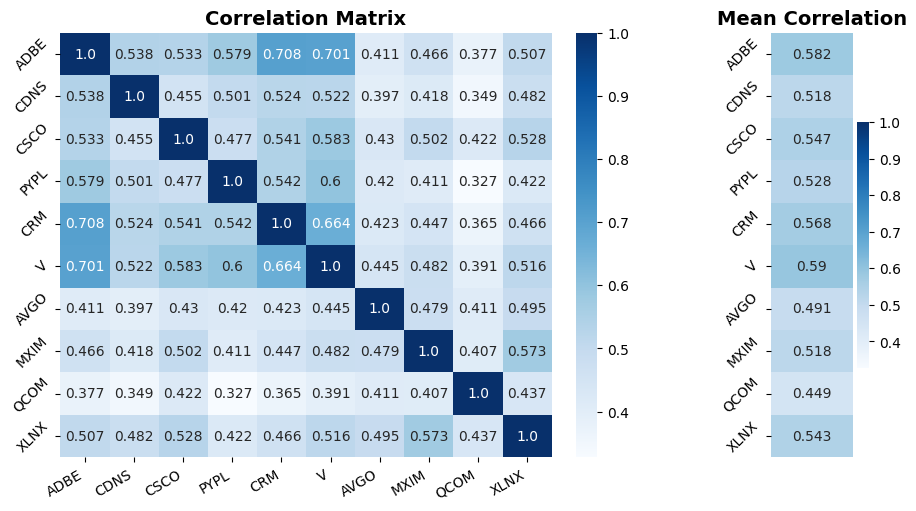

In [107]:
# Compute correlation.
corr = returns.corr()

# Plot the heatmap.
fig = plt.figure(constrained_layout=True, figsize = (9, 5))
gridspec = fig.add_gridspec(1, 8)

# Define axes.
ax0 = fig.add_subplot(gridspec[0:6])
ax1 = fig.add_subplot(gridspec[7:8])

# Plot correlation heatmap.
corr_heatmap = sns.heatmap(corr, annot = True, xticklabels = corr.columns, yticklabels = corr.columns, cmap = 'Blues', fmt = '.3', ax = ax0)
corr_heatmap.set_yticklabels(corr_heatmap.get_yticklabels(), rotation=45)

# Compute means.
means = pd.DataFrame(index = stocks)
means.loc[:, -1] = np.array(corr.mean())
means.index.name = ''

# Plot means heatmmap.
means_heatmap = sns.heatmap(means, annot = True, xticklabels = '', cmap = 'Blues', vmax = 1, vmin = min(corr.min()), fmt = '.3', ax = ax1)
means_heatmap.set_yticklabels(means_heatmap.get_yticklabels(), rotation=45)

# Format axes.
format_plot(ax0, title = 'Correlation Matrix', grid_on = False, legend_on = False)
format_plot(ax1, title = 'Mean Correlation', grid_on = False, legend_on = False)

To construct a network based on the correlation matrix, we can use the correlation coefficients as the lengths of the edges connecting the stocks in the graph. A higher correlation coefficient between two stocks would result in a shorter edge connecting them in the graph, while a lower correlation coefficient would correspond to a longer edge. By spacially representing the cross-asset correlations, we can identify clusters of stocks that tend to move together, as well as outliers that exhibit unique or divergent behaviour. The network-based graphical analysis of correlations is shown in the figure below for the following minimum correlations thresholds: $0.35$, $0.40$, $0.45$, $0.50$. As well as deriving information from spacial data, the colour of the edges have been colour-coded to represent strength of correlation; darker shades represent stronger correlations between stocks whilst lighter shades represent weaker correlations between stocks. Furthermore, the node size has also been set to be dynamic; larger nodes represent stocks with larger mean correlation.

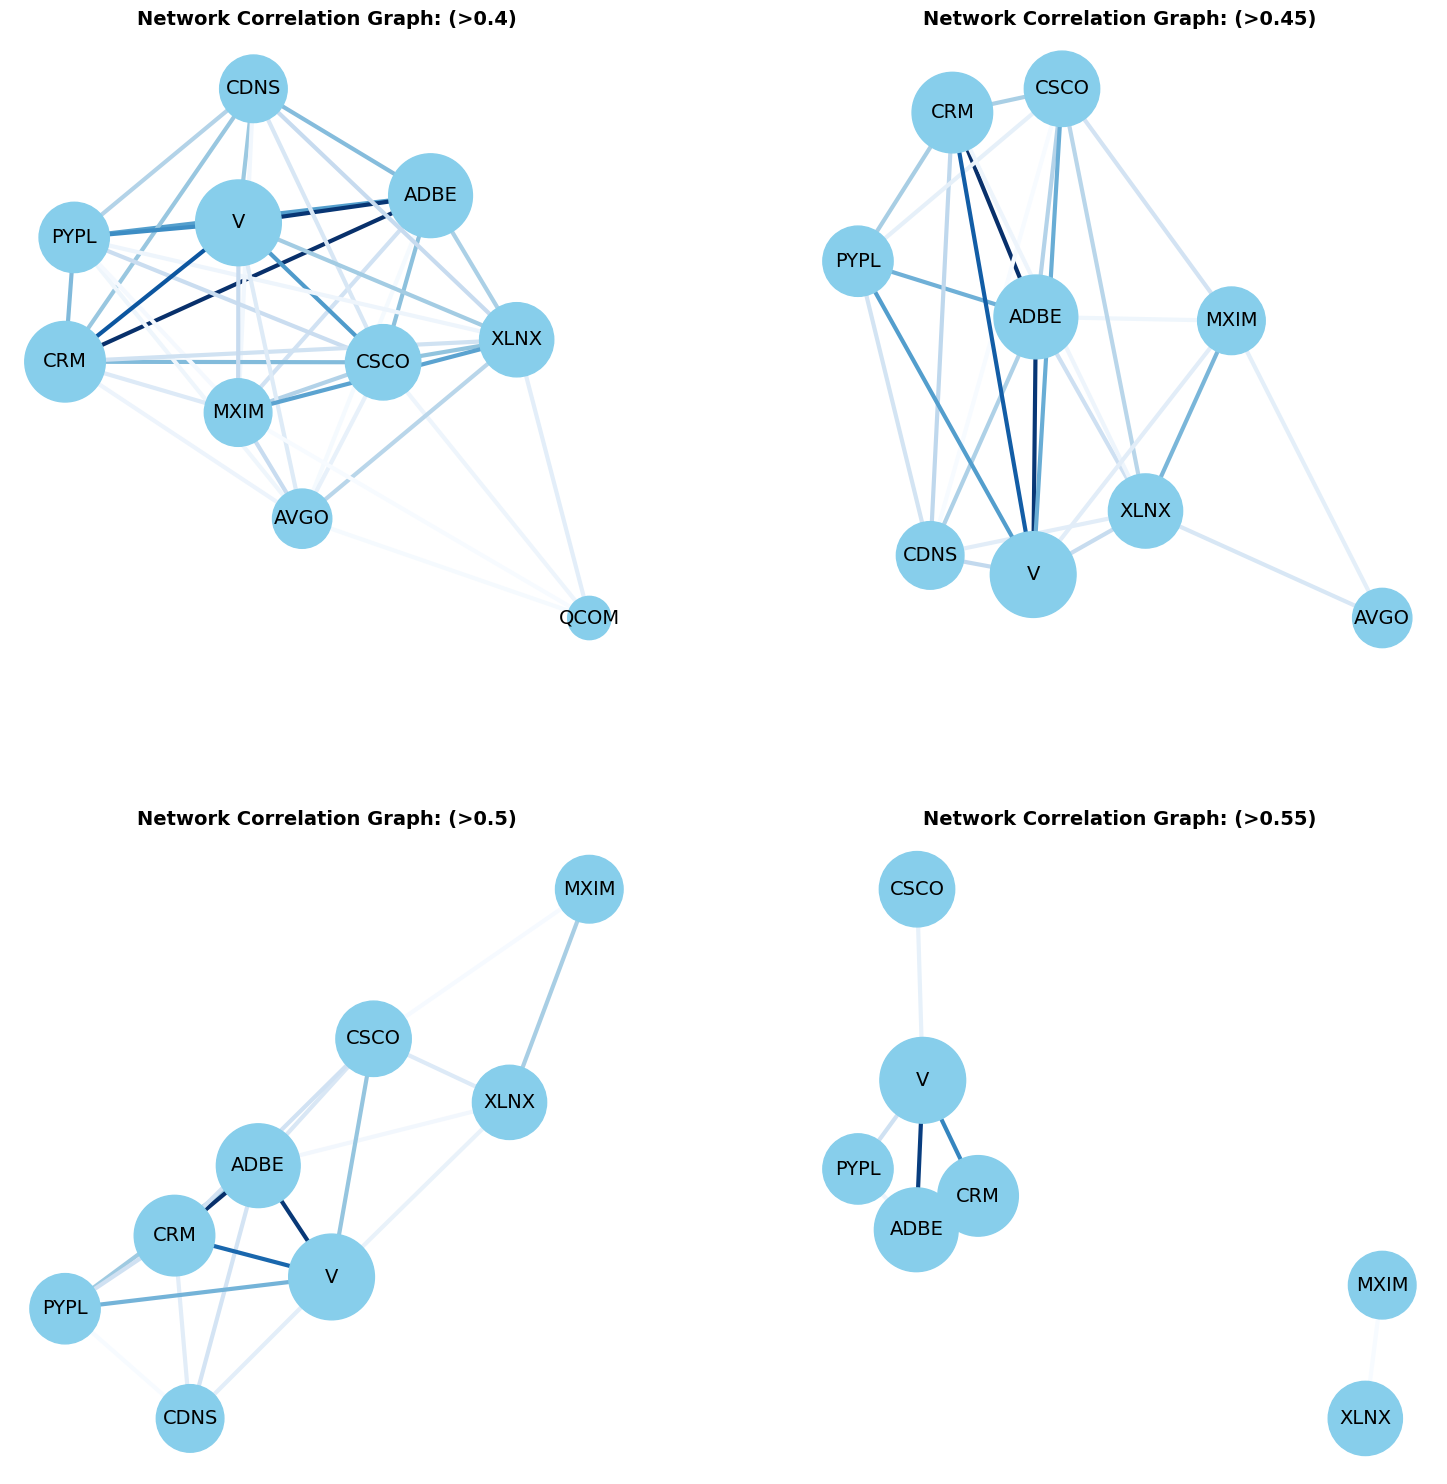

In [108]:
# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2', 'value']

# Correlations to filter.
filter_corrs = [0.40, 0.45, 0.50, 0.55]

# Initialise subplot and axes index
fig, axes = configure_subplots(2, 2, fig_size = (15, 15), hspace = 0.25, wspace = 0.25)
index = 0

# For each correlation threshold
for c in filter_corrs:

    # Define axes.
    ax = axes[int(index > 1)][int(index % 2)]

    # Compute links that have met minimum threshold (mmt_links)
    mmt_links = links.loc[ abs(links['value'] > c) & (links['var1'] != links['var2']) ]

    # Plot the network:
    network_plotter(mmt_links, ax = ax, mean_corrs = means)
    format_plot(ax, title = 'Network Correlation Graph: (\u003E' + str(c) + ')', legend_on = False)

    index += 1

## 5.3 Discuss your results, especially whether the topology of your graph is dictated by the nature of the data. Would the re-ordering of graph vertices affect your results? Would the re-ordering of your time-series data affect your results?

The graphical depiction in the preceding figure facilitates the identification of the most influential companies in the Information Technology GICS Sector, with Headquarters based in California, whose performances closely dictate the performances of other companies in the same sector. As expected, companies like QUALCOMM Inc. (QCOM) and Broadcom (AVGO) are weakly correlated with the remainder of the portfolio because they operate in a hardware-based sub-industry that minimally liaises with software companies so the successes or failures of both sub-industries are usually independent of one another. Furthermore, hardware companies are notorious for not liaising with competitors in the same sub-industry, preferring to do everything in house. This weak cross-correlation of the QCOM and AVGO stocks is evidenced by their node's increasing isolation from other nodes as the correlation threshold increases, and by the sparse and lightly shaded connections that their nodes establish.

Conversely, companies like Adobe Systems Inc (ADBE), Visa Inc (V), and Salesforce.com (CRM) emerge as pivotal entities within the network structure, occupying central positions in the correlation plots. Their prominence is underscored by the multitude of robust connections they have with other companies within the portfolio, owing to the widespread adoption of the software services they provide. This observation suggests a strong degree of interdependence or shared market influence among these entities. Furthermore, with an increase in the minimum correlation threshold, discernible clusters of companies begin to emerge within the network. These clusters signify cohesive groups of companies that exhibit a heightened level of correlation or collaborative interactions. Such groupings may reflect shared industry affiliations, business partnerships, or similar market exposures among the constituent companies. This deeper analysis unveils the intricate web of relationships and dynamics that underlie the interactions within the Information Technology market sector. In the final subplot, we observe the emergence of distinct clusters, with one cluster predominantly comprising software companies and another cluster primarily consisting of hardware companies.

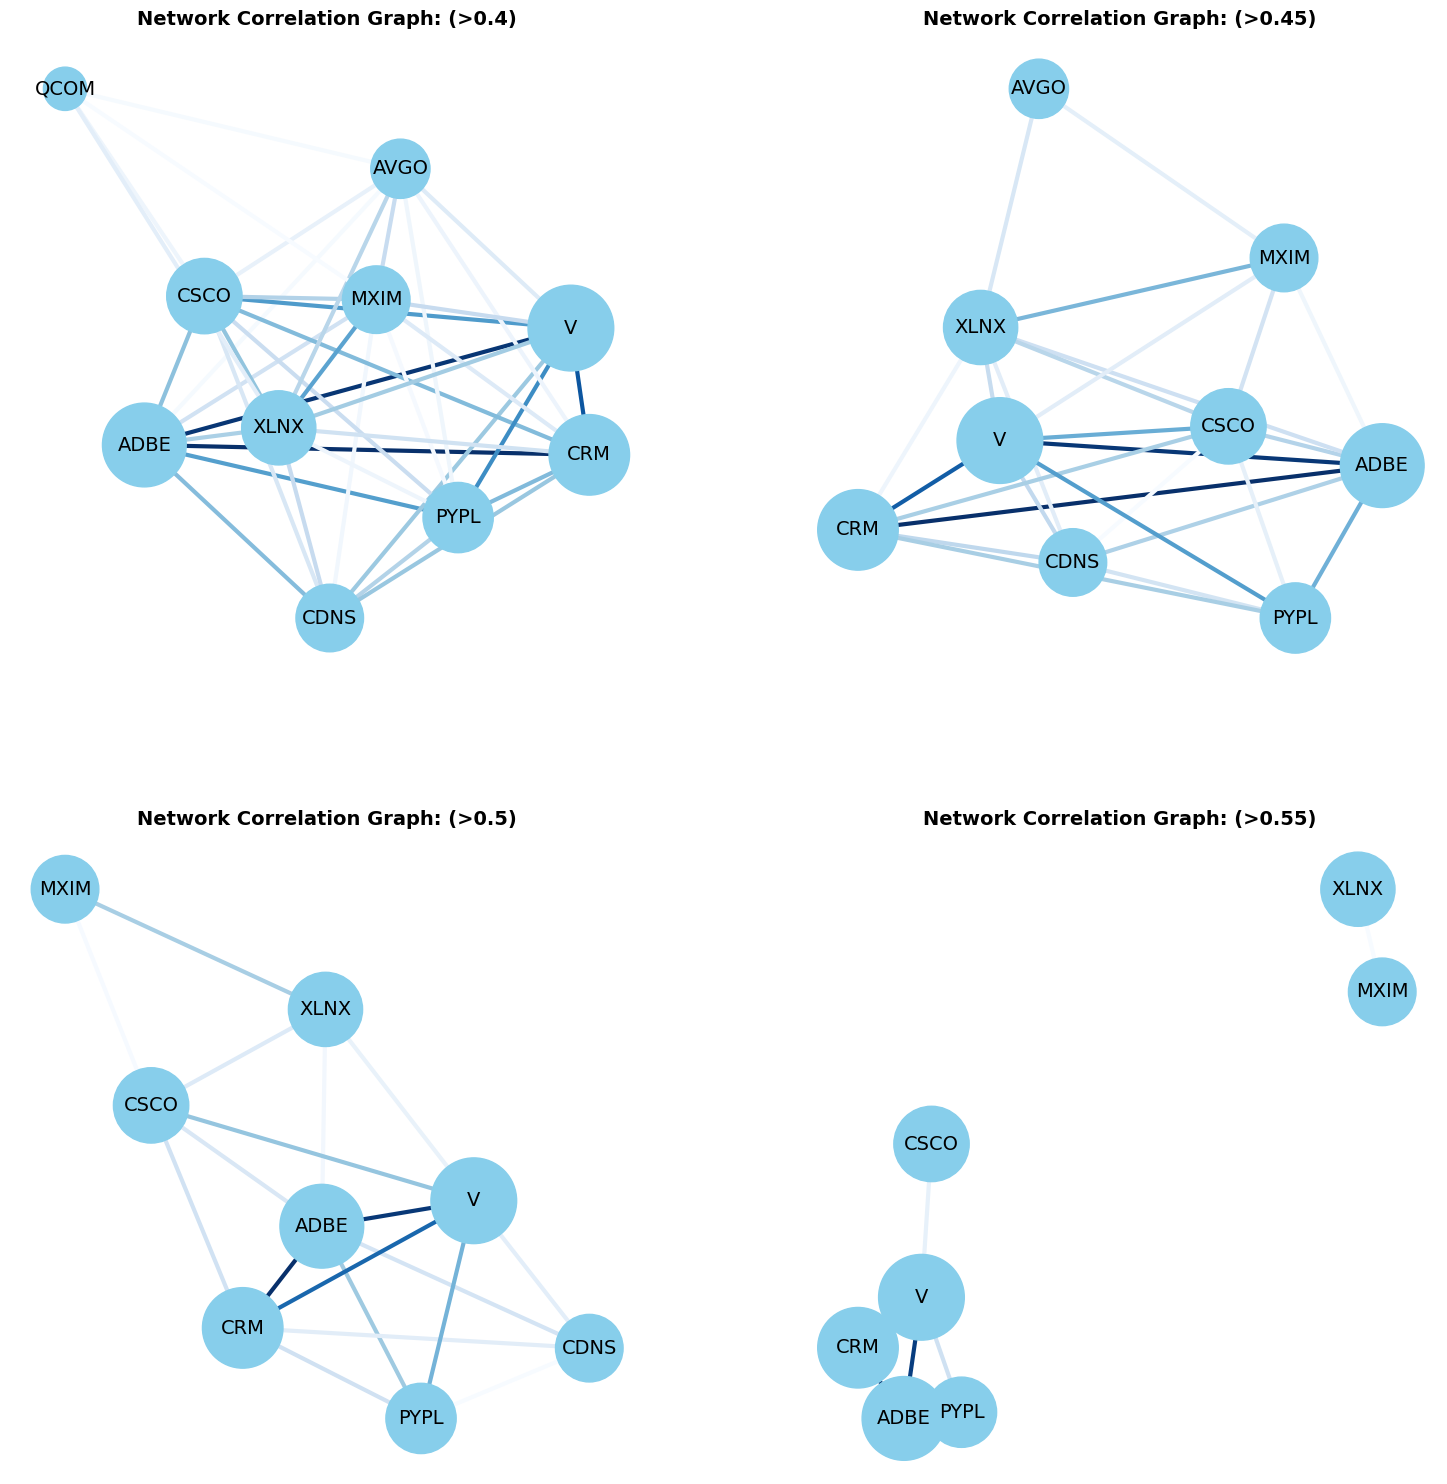

In [109]:
# Calculate correlation matrix.
corr = returns.sample(frac=1, axis=0).corr()

# Transform it in a links data frame (3 columns only).
links = corr.stack().reset_index()
links.columns = ['var1', 'var2', 'value']

# Correlations to filter.
filter_corrs = [0.40, 0.45, 0.50, 0.55]

# Initialise subplot and axes index
fig, axes = configure_subplots(2, 2, fig_size = (15, 15), hspace = 0.25, wspace = 0.25)
index = 0

# For each correlation threshold
for c in filter_corrs:

    # Define axes.
    ax = axes[int(index > 1)][int(index % 2)]

    # Compute links that have met minimum threshold (mmt_links)
    mmt_links = links.loc[ abs(links['value'] > c) & (links['var1'] != links['var2'])]

    # Plot the network.
    network_plotter(mmt_links, ax = ax, mean_corrs = means)
    format_plot(ax, title = 'Network Correlation Graph: (\u003E' + str(c) + ')', legend_on = False)

    index += 1

Correlation, as a measure of similarity between two stocks, remains unaffected by the re-ordering of data. However, due to the internal workings of the $\texttt{networkx}$ package, the exact positioning of nodes in the visual representation of data may vary. Nevertheless, the link shade and node shade remain consistent, as they are derived from the deterministic confusion matrix. Therefore, reshuffling data along both row and column axes results in equivalent plots in terms of information presented, barring differences in node arrangement. The figure directly above illustrates the same data as conveyed in the figure in Section 5.2, albeit recalculated after rearranging the input data.

## 5.4 Dynamic time warping distance matrix and network

In this section, we delve into an alternative similarity measure, known as Dynamic Time Warping (DTW), and compare its results to those obtained from the correlation analysis conducted in Sections 5.2 and 5.3. DTW has been selected as the distance metric for analysing the returns of stocks in a portfolio for the the following reasons:

1. ***Robustness to Local Variations***: DTW allows for local distortions or shifts in the time axis, which is beneficial when comparing stock returns that may exhibit similar trends but with slight variations in timing or magnitude. This robustness to local variations makes DTW suitable for capturing similarities in stock return patterns even if they are not perfectly aligned.

2. ***Applicability to Noisy Data***: Stock returns data often contains noise due to market fluctuations, news events, or other external factors. DTW is resilient to noise and can identify similarities in time series patterns even in the presence of noise, making it suitable for analysing noisy stock returns data.

3. ***Versatility***: DTW can be applied to a wide range of time series data, including irregularly sampled data, which may occur in the context of stock returns when trading occurs on non-continuous time intervals (e.g., trading halts, holidays). This versatility makes DTW a flexible choice for analysing stock returns across different trading frequencies and data irregularities.

DTW's heightened complexity enables the identification of patterns in the data that may not be discerned through conventional correlation analysis. As a result, DTW is widely adopted as a similarity measure technique in the realm of stock returns analysis and prediction.

The figure below illustrates the DTW similarity matrix alongside with the mean DTW per stock represented as heatmaps. In contrast to the previous heatmap representations, darker shades in the heatmaps denote diminishing similarity among the stock returns of different companies, while lighter shades indicate increasing similarity. As anticipated, the main diagonal of the matrix consists of zeros, signifying that the dynamic time warping distance of an asset's returns data to itself is inherently zero i.e. it's maximally similar.

In [110]:
# Initialise the similarity matrix to have the same dimensions as the correlation matrix
dtw_matrix = corr.copy()

# Go through tickers and repopulate similarity matrix
for series_row in returns.columns:
    for series_column in returns.columns:
      distance = ts_dtw(returns[series_row].values, returns[series_column].values)
      dtw_matrix[series_row][series_column] = distance

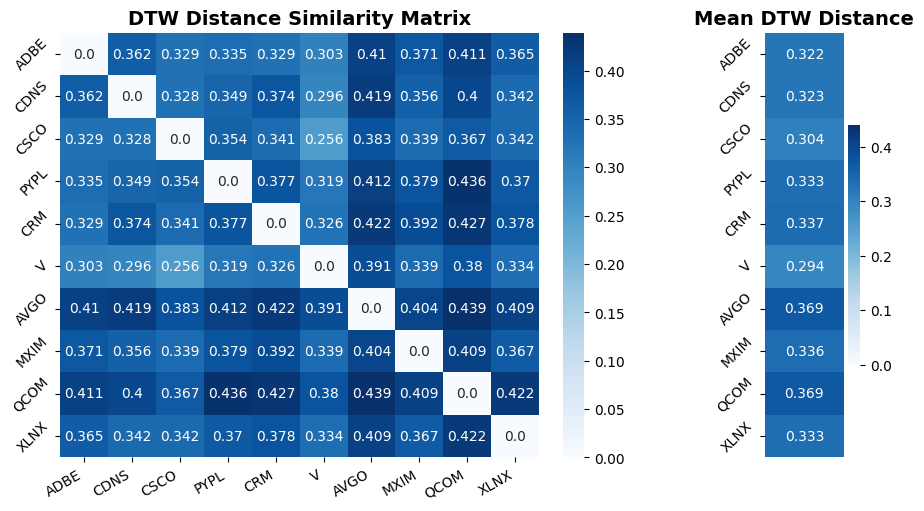

In [111]:
# Plot the heatmap.
fig = plt.figure(constrained_layout=True, figsize = (9, 5))
gridspec = fig.add_gridspec(1, 8)

# Define axes.
ax0 = fig.add_subplot(gridspec[0:6])
ax1 = fig.add_subplot(gridspec[7:8])

# Plot DTW distance similarity matrix heatmap.
dtw_heatmap = sns.heatmap(dtw_matrix, annot = True, xticklabels = dtw_matrix.columns, yticklabels = dtw_matrix.columns, cmap = 'Blues', fmt = '.3', ax = ax0)
dtw_heatmap.set_yticklabels(dtw_heatmap.get_yticklabels(), rotation=45)

# Compute means.
means = pd.DataFrame(index = stocks)
means.loc[:, -1] = np.array(dtw_matrix.mean())
means.index.name = ''

# Plot means heatmap.
means_heatmap = sns.heatmap(means, annot = True, xticklabels = '', cmap = 'Blues', vmax = max(dtw_matrix.max()), vmin = min(dtw_matrix.min()), fmt = '.3', ax = ax1)
means_heatmap.set_yticklabels(means_heatmap.get_yticklabels(), rotation=45)

# Format axes.
format_plot(ax0, title = 'DTW Distance Similarity Matrix', grid_on = False, legend_on = False)
format_plot(ax1, title = 'Mean DTW Distance', grid_on = False, legend_on = False)

The network-based graphical analysis of DTW distances is shown in the figure below for the following minimum DTW distance thresholds: $0.400$, $0.375$, $0.350$, $0.325$. In this network graph, in contrast to before, darker shaded links correspond to diminishing similarities, whilst lighter shaded links correspond to increasing similarities between the returns of stocks.

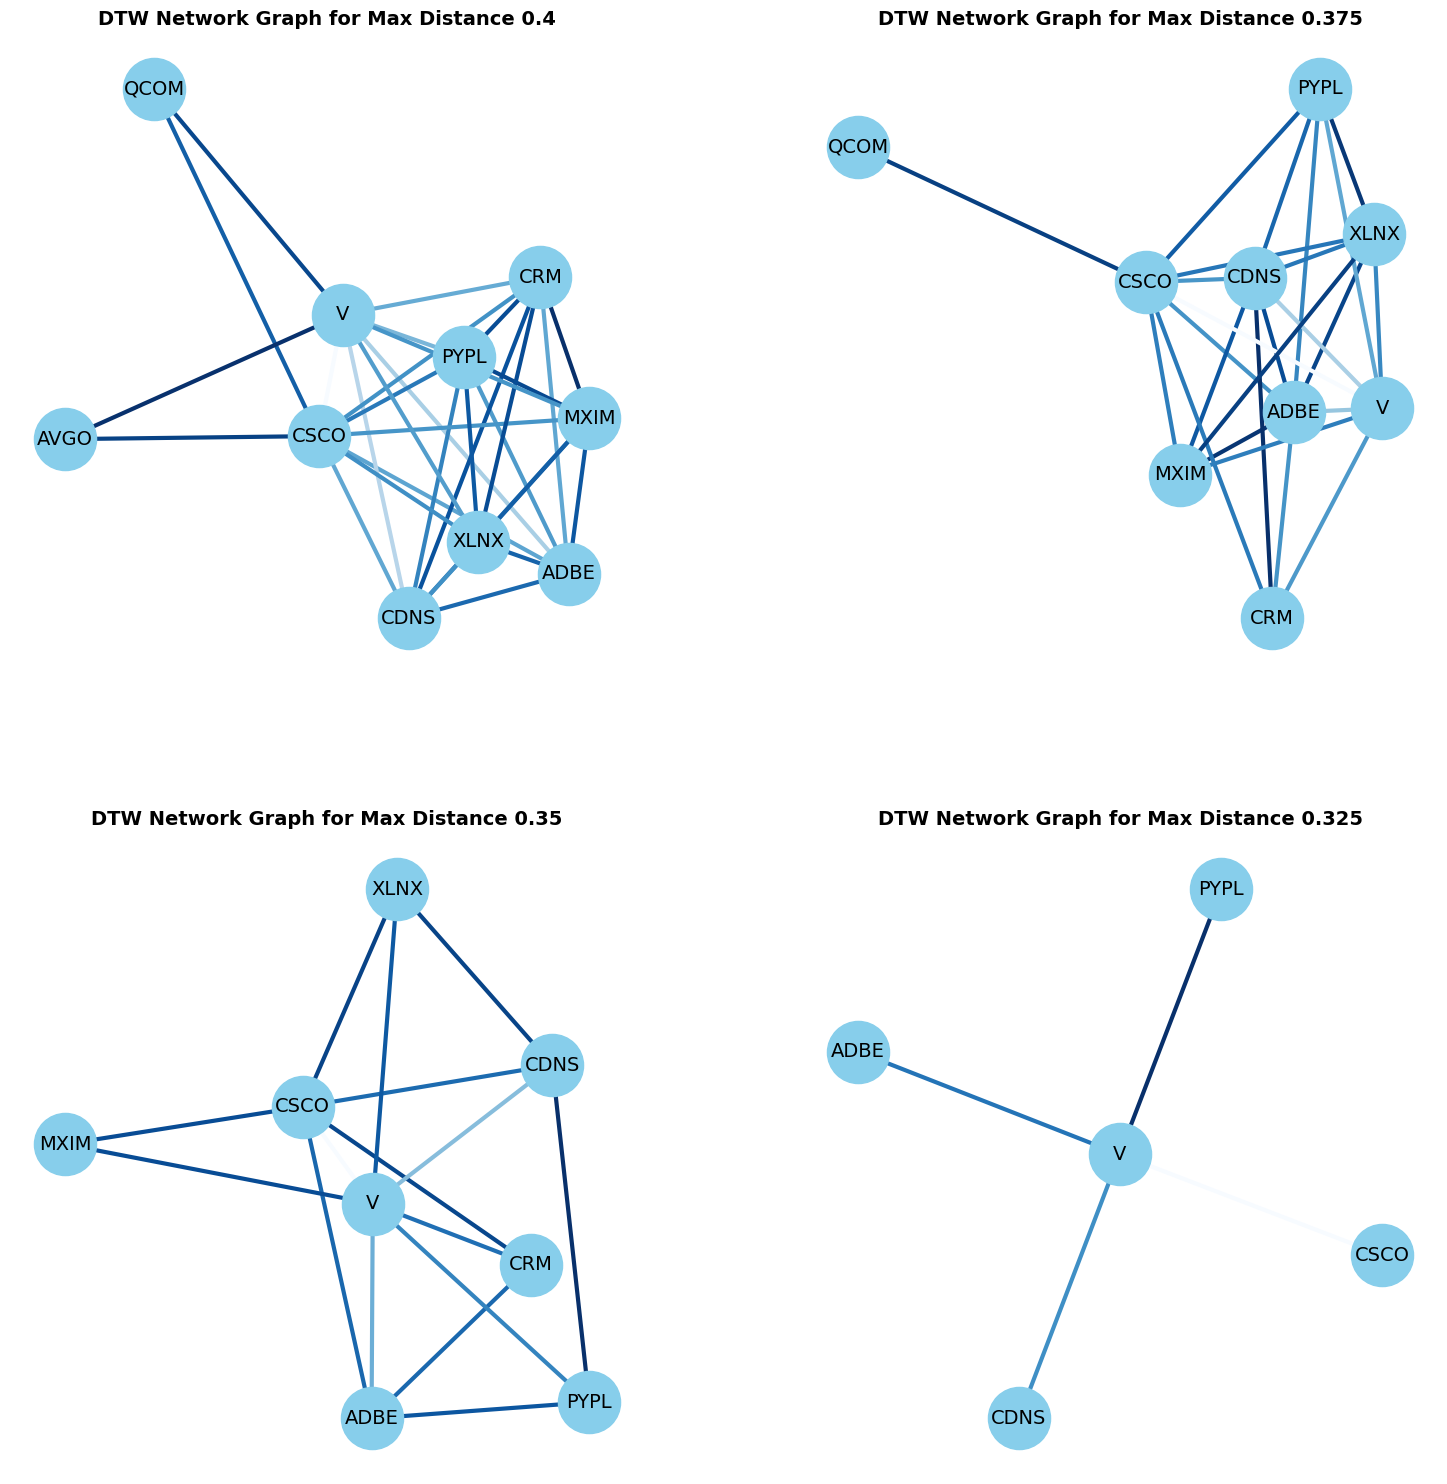

In [112]:
# Transform it in a links data frame (3 columns only):
links = dtw_matrix.stack().reset_index()
links.columns = ['var1', 'var2', 'value']

# Warps to filter
dtws = [0.400, 0.375, 0.350, 0.325]

# Initialise subplot and axes index
fig, axes = configure_subplots(2, 2, fig_size = (15, 15), hspace = 0.25, wspace = 0.25)
index = 0

# For each warp
for w in dtws:

    # Define axes
    ax = axes[int(index > 1)][int(index % 2)]

    # Compute links that have met minimum threshold (mmt_links)
    mmt_links = links.loc[abs(links['value'] < w) & (links['var1'] != links['var2'])]

    # Plot the network.
    network_plotter(mmt_links, ax = ax)
    format_plot(ax, title = 'DTW Network Graph for Max Distance ' + str(w), legend_on = False)

    index += 1

Following visual inspection of the matrix and network graphs, we can conclude that Dynamic Time Warping identifies different patterns when compared to the findings from Section 5.2. Overall, when dealing with returns data that has a sporadic sample rate, as in our case due to incomplete data, Dynamic Time Warping (DTW) offers several advantages over correlations. Its capability to manage temporal misalignments, resilience to irregularities in data, and adaptability in capturing non-linear relationships render it a superior option in comparison to correlations in stock returns analysis and prediction.

After reshuffling the time-series, we obtain the following DTW distance matrix and network graphs.

In [113]:
# Shuffle returns
returns = returns.sample(frac=1, axis=0)
corr = returns.corr()

# Initialise the similarity matrix to have the same dimensions as the correlation matrix
dtw_matrix = corr.copy()

# Go through tickers and repopulate similarity matrix
for series_row in returns.columns:
    for series_column in returns.columns:
      distance = ts_dtw(returns[series_row].values, returns[series_column].values)
      dtw_matrix[series_row][series_column] = distance

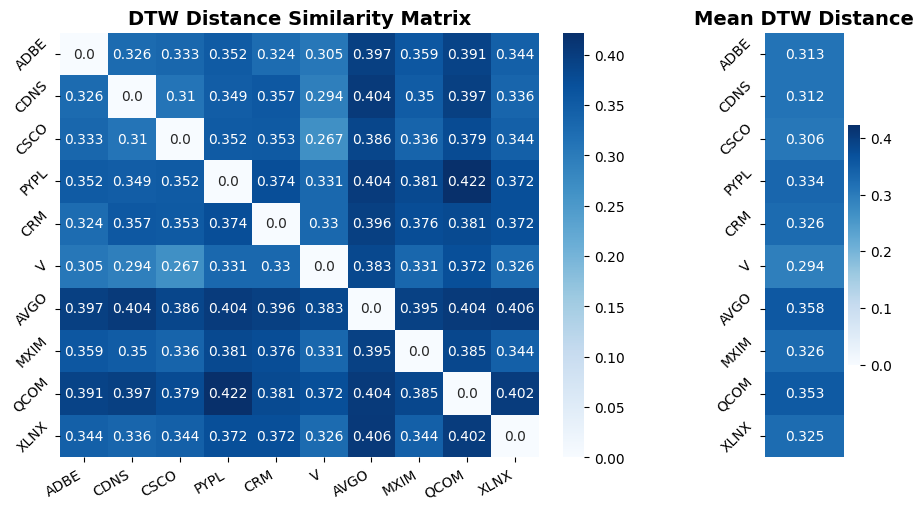

In [114]:
# Plot the heatmap.
fig = plt.figure(constrained_layout=True, figsize = (9, 5))
gridspec = fig.add_gridspec(1, 8)

# Define axes.
ax0 = fig.add_subplot(gridspec[0:6])
ax1 = fig.add_subplot(gridspec[7:8])

# Plot DTW distance similarity matrix heatmap.
dtw_heatmap = sns.heatmap(dtw_matrix, annot = True, xticklabels = dtw_matrix.columns, yticklabels = dtw_matrix.columns, cmap = 'Blues', fmt = '.3', ax = ax0)
dtw_heatmap.set_yticklabels(dtw_heatmap.get_yticklabels(), rotation=45)

# Compute means.
means = pd.DataFrame(index = stocks)
means.loc[:, -1] = np.array(dtw_matrix.mean())
means.index.name = ''

# Plot means heatmap.
means_heatmap = sns.heatmap(means, annot = True, xticklabels = '', cmap = 'Blues', vmax = max(dtw_matrix.max()), vmin = min(dtw_matrix.min()), fmt = '.3', ax = ax1)
means_heatmap.set_yticklabels(means_heatmap.get_yticklabels(), rotation=45)

# Format axes.
format_plot(ax0, title = 'DTW Distance Similarity Matrix', grid_on = False, legend_on = False)
format_plot(ax1, title = 'Mean DTW Distance', grid_on = False, legend_on = False)

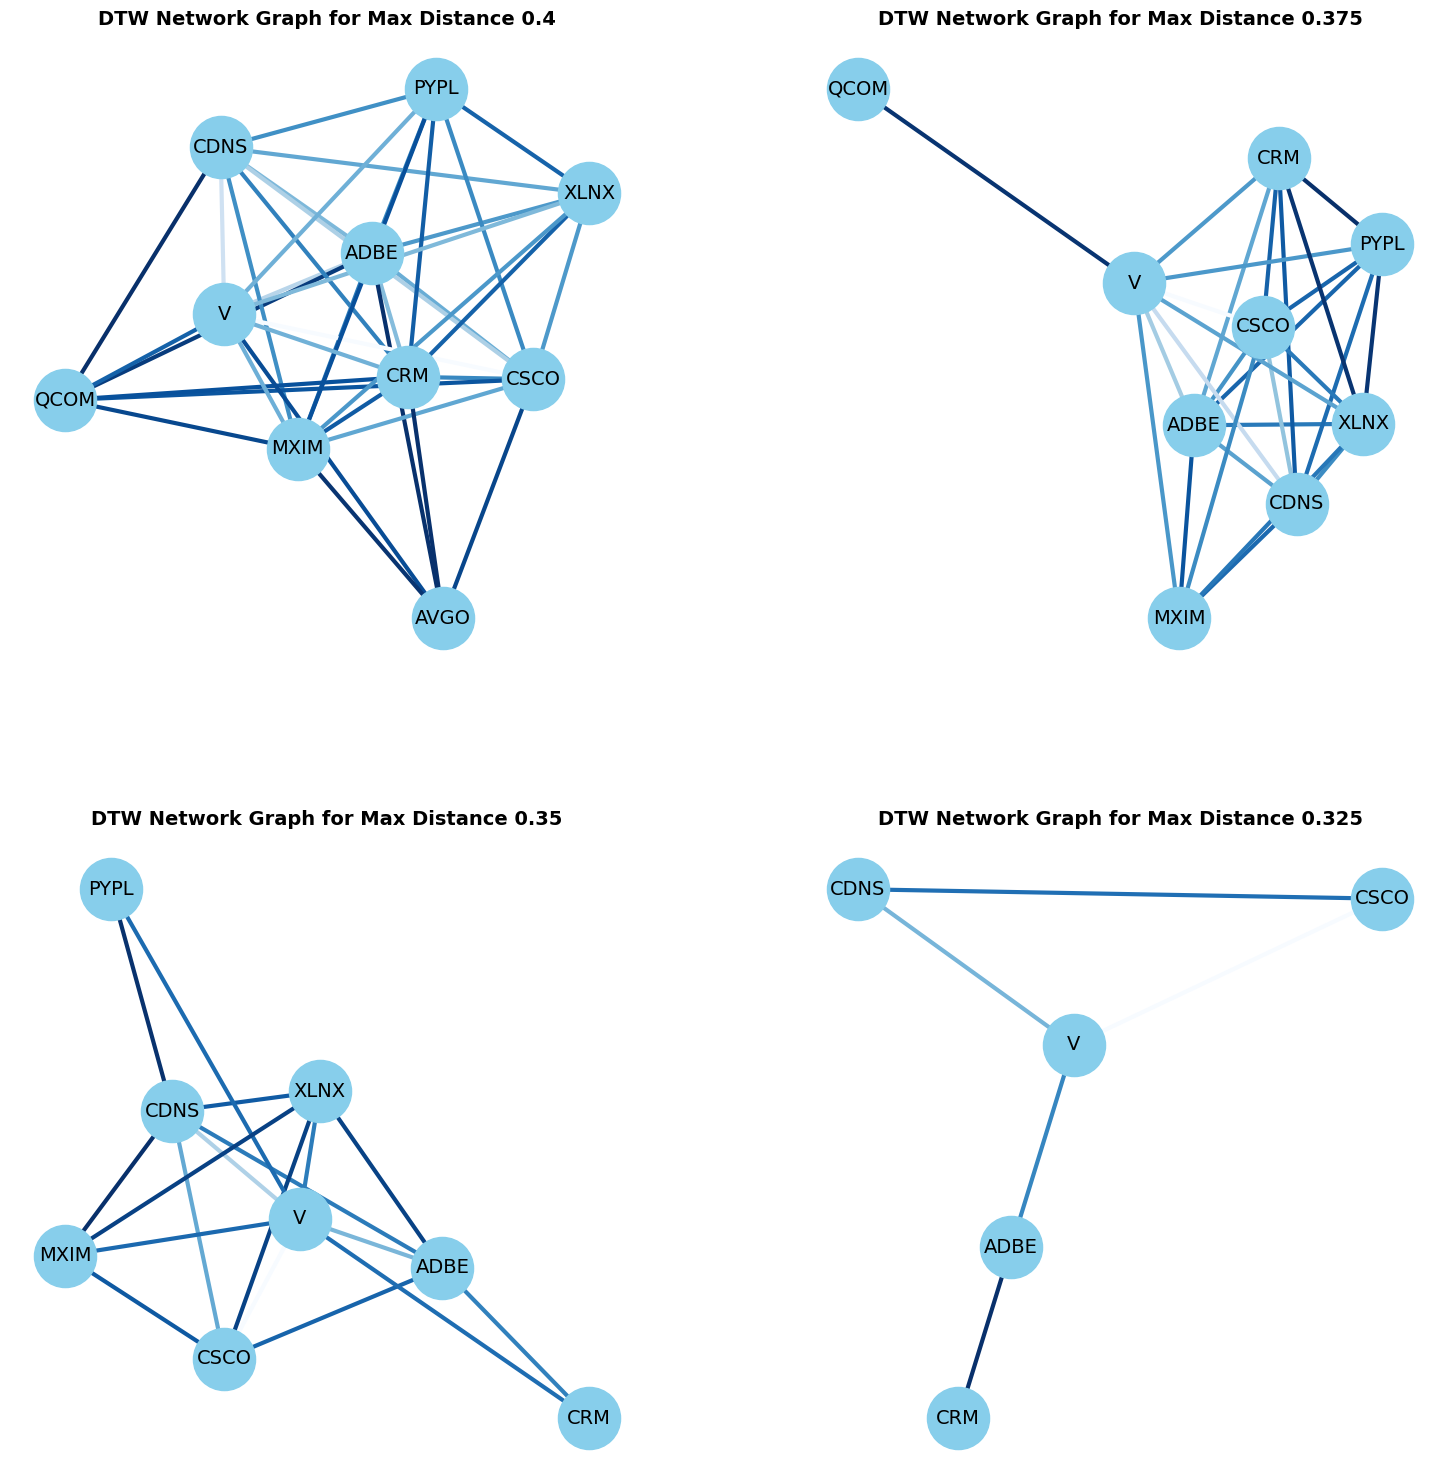

In [117]:
# Transform it in a links data frame (3 columns only):
links = dtw_matrix.stack().reset_index()
links.columns = ['var1', 'var2', 'value']

# Warps to filter
dtws = [0.400, 0.375, 0.350, 0.325]

# Initialise subplot and axes index
fig, axes = configure_subplots(2, 2, fig_size = (15, 15), hspace = 0.25, wspace = 0.25)
index = 0

# For each warp
for w in dtws:

    # Define axes
    ax = axes[int(index > 1)][int(index % 2)]

    # Compute links that have met minimum threshold (mmt_links)
    mmt_links = links.loc[abs(links['value'] < w) & (links['var1'] != links['var2'])]

    # Plot the network.
    network_plotter(mmt_links, ax = ax, std = max(dtw_matrix.max()), factor = 10000)
    format_plot(ax, title = 'DTW Network Graph for Max Distance ' + str(w), legend_on = False)

    index += 1

We can clearly see that rearranging the returns data has resulted in a substantial alteration of the analysis outcome. In contrast to correlation, which is time-invariant and can be reshuffled without affecting the analysis outcome, Dynamic Time Warping (DTW) requires the order of the time-series data to be maintained, in order to make a fair and accurate judgement of the results.

## 5.5 Considering Raw Prices for Analysis: Implications and Considerations

By considering raw prices instead of log-returns in Q1, there is no need to apply the logarithmic transformation, so we would directly load the price values for each stock, from the respective CSV files, over the given time period.

For Q2, instead of computing the correlation matrix based on log-returns, we would compute the correlation matrix directly from the raw price data. This correlation matrix captures the linear relationship between the raw price movements of the selected stocks over the specified period. Unlike log-returns, which capture relative price movements, raw prices capture absolute price movements. Consequently, this shift may accentuate the magnitude of price changes rather than their directional aspects, potentially leading to different insights and interpretations. Furthermore, raw prices typically exhibit higher volatility compared to log-returns, particularly for assets with higher absolute prices. This could impact the calculated correlations between stocks. Moreover, interpreting asset relationships based solely on raw prices may prove more challenging than with log-returns, as raw prices can be influenced by extraneous factors unrelated to underlying asset performance.

The discussion in Q3 would need to consider the implications of using raw prices on the topology of the graph. Since raw prices can be influenced by factors such as inflation, economic events, and market sentiment, the resulting graph may exhibit a different topology compared to the graph constructed using log-returns. Reordering the returns data could still affect the interpretation of relationships between assets, but the specific impact would depend on how the data is reordered.

In Q4, when adopting a distance metric other than correlation, we would apply the chosen dissimilarity measure directly to the raw price data instead of log-returns. If we choose Dynamic Time Warping (DTW) as the distance metric, it would measure the similarity between two time series while allowing for variations in the timing and speed of price movements.

Overall, considering raw prices instead of log-returns would lead to a different perspective on the relationships between assets, potentially uncovering distinct patterns and dynamics in the data. It is imperative to meticulously weigh the implications of using raw prices and select appropriate analytical techniques to glean meaningful insights from the dataset.